## Аналитика HH.ru

**Описание:** Анализ данных портала [hh.ru](https://hh.ru/) вакансий аналитиков данных
и системных аналитиков.

**Цель анализа:** Выявить различия в вакансиях для аналитиков данных
и системных аналитиков.

**Ключевые задачи:** 
- Анализ требований и условий рынка труда по предоставленным вакансиям.
- Определение требований для DA/SA специалистов в разрезе градаций.
- Разработать рекомендации по ключевым навыкам для соискателей и рекрутеров.

<a name='Описание-данных'>**Описание данных** <br> </a>
Данные получены посредством API [hh.ru](https://hh.ru/) и составляют два xlsx файла:
1) vacancies_sa.xlsx - датасет вакансий SA
2) vacancies_da (1).xlsx - датасет вакансий DA

По структуре два файла идентичны.

Ссылка на данные: https://disk.yandex.ru/d/***

Описание полей в данных:
- id - Уникальный идентификатор вакансии.
- name - Название вакансии.
- published_at - Дата публикации.
- alternate_url - Ссылка на вакансию.
- type - Статус вакансии на момент получения данных от api и передачи их в базу.
- employer - Работодатель.
- department - Работодатель, отдел.
- area - Регион места работы.
- experience - Требуемый опыт работы.
- key_skills - Ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от api.
- schedule - График работы.
- employment - Тип занятости.
- description - Описание вакансии.
- description_lemmatized - Лемматизированное описание вакансии.
- salary_from - Нижняя граница предлагаемой заработной платы.
- salary_to - Верхняя граница предлагаемой заработной платы.
- salary_bin - Категория зарплаты.
- key_skills_from_key_skills_field - Ключевые навыки из поля вакансии key_skills.
- hard_skills_from_description - “Твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api. 
- soft_skills_from_description - “Мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.

<a name='Термины'>**Принятые сокращения и термины:**</a>
* DA - data analyst, аналитик данных.
* SA - system analyst, системный аналитик.
* Градация - обозначение компетенций специалиста. Основное деление на junior, middle, senior, lead. [Подробнее](https://practicum.yandex.ru/blog/urovni-junior-middle-senior/). Здесь используем следующую разделение: 

        Junior - без опыта, 
        Junior+ - с опытом от 1го года до 3х лет, 
        Middle - с опытом от 3х лет до 6и лет, 
        Senior - с опытом более 6и лет.
* API - Application Programming Interface, это программный интерфейс для организации взаимодействия различных приложений друг с другом.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

### Открытие файлов с данными и вывод общей информации

In [2]:
# адреса локальных файлов
files = ['local1.xlsx', 'local2.xlsx']

# URLs на файлы
urls = [
    r'https://docs.google.com/spreadsheets/d/***',
    r'https://docs.google.com/spreadsheets/d/***'
       ]
try: # по возмажности локальный файл
    df_sa, df_da = (pd.read_excel(file) for file in files)
except: # иначе URL
    for num, url in enumerate(urls): # из скопированных url 'прямые'
        urls[num]='https://drive.google.com/uc?id=' + url.split('/')[-2]
    df_sa, df_da = (pd.read_excel(file) for file in urls)

display(df_da.head(2), df_da.tail(2))
display(df_sa.head(2), df_sa.tail(2))

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1799,99989203,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:40:04,https://hh.ru/vacancy/99989203,Открытая,Марс,NaN,Одинцово,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN
1800,99989339,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:41:22,https://hh.ru/vacancy/99989339,Открытая,Марс,NaN,Ульяновск,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",Полный день,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1913,99975404,Системный аналитик/System Analyst (junior),2024-07-07 15:12:34,https://hh.ru/vacancy/99975404,Открытая,Aston,NaN,Уфа,Junior+ (1-3 years),"['SOA', 'XML', 'Atlassian Jira', 'Use cases', ...",Удаленная работа,Полная занятость,системный аналитик / system analyst junior мы ...,системный аналитик system analyst junior аутсо...,80000.0,110000.0,От 100 тысяч до 200 тысяч,"Системный анализ, System Analysis, Use cases, ...",confluence,NaN
1914,99991121,Старший системный аналитик 1C (Sminex Finance),2024-07-08 11:18:03,https://hh.ru/vacancy/99991121,Открытая,Sminex,Sminex Информационные технологии,Москва,Senior (6+ years),"['Документация', '1С: Предприятие', '1С: Бит Ф...",Полный день,Полная занятость,"привет! мы - команда sminex it, и мы ищем тала...",привет команда sminex it искать талантливый си...,280000.0,340000.0,Больше 300 тысяч,"1С: Бит Финанс, 1С: Предприятие, MS Excel, MS ...",NaN,Документация


In [3]:
# Выводим общую информацию df_da
display(df_da.info())
display(df_da.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule                          1801 non-null 

None

,id,published_at,salary_from,salary_to
count,1.801000e+03,1801,348.000000,228.000000
mean,9.722646e+07,2024-05-04 07:51:09.441421312,109525.086207,153846.714912
min,7.799231e+07,2024-02-13 21:45:51,50.000000,25000.000000
25%,9.544812e+07,2024-04-11 06:46:59,70000.000000,85000.000000
50%,9.735636e+07,2024-05-11 21:45:07,90000.000000,120000.000000
75%,9.942526e+07,2024-05-29 13:39:52,137750.000000,200000.000000
max,1.017465e+08,2024-06-11 15:07:30,398000.000000,497500.000000
std,2.894522e+06,NaN,63011.338914,97255.738565


В df_da содержится:
1) 1801 запись
2) период данных: с 13 февраля 2024 по 11 июня 2024

Задачи по данным в df_da:
1. Разобраться почему минимальная нижняя граница зарплаты аномально низкая (50 рублей)
2. Посчитать количество дней в периоде данных

In [4]:
# Выводим общую информацию df_sa
display(df_sa.info())
display(df_sa.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule                          1915 non-null 

None

,id,published_at,salary_from,salary_to
count,1.915000e+03,1915,356.000000,279.000000
mean,1.001074e+08,2024-07-04 19:50:42.855352576,154117.587079,223633.580645
min,5.241017e+07,2024-06-27 06:08:10,280.000000,20000.000000
25%,9.881442e+07,2024-07-01 17:17:51,85000.000000,145000.000000
50%,1.022884e+08,2024-07-05 08:58:44,150000.000000,220000.000000
75%,1.031315e+08,2024-07-08 10:22:25,200000.000000,300000.000000
max,1.035847e+08,2024-07-09 12:47:11,350000.000000,580000.000000
std,5.214258e+06,NaN,74335.125628,103654.639332


В df_sa содержится:
1) 1915 запись
2) период данных: с 27 июня 2024 по 09 июля 2024

Задачи по данным в df_sa:
1. Разобраться почему минимальная нижняя граница зарплаты аномально низкая (280 рублей)
2. Посчитать количество дней в периоде данных

### Предобработка данных

Надо выполнить в предобработки:
1) Объединить датафреймы с указанием датасета данных
2) Перевести поля salary_from и salary_to в формат int
3) Добавить поле с указанием месяца размещения вакансии
4) Добавить поле с указанием грейда
5) Добавить поле с требованием по образованию
6) Заменить пропуски на подходящие значения или 'no data' в столбцах department, key_skills_from_key_skills_field, hard_skills_from_description, soft_skills_from_description
7) Проверка категориальных данных в полях area, experience, schedule, employment, salary_bin
8) Проверить соотношения зарплат и грейда
9) Проверить на дубликаты 
10) Добавить переменные с указанием выборки по DA/SA, с указанием выборки грейда для удобства фильтрации

#### Определяем функции

In [5]:
# поиск леммы в описание с учетом привязки по расстоянию с корневым словом
def find_lemma_between(description, words_list, min_range=0, max_range=5, test=True):
    """
    :param description: лемматизированное описание
    :param words_list: список списков с нужными леммами. Первый список это корневое слово
    (основное слово в поисковой структуре), все последующие - уровни вложения.
    :param min_range: минимальное кол-во слов между леммами (по умолчанию 0)
    :param max_range: максимальное кол-во слов между леммами (по умолчанию 5)
    :param test: флаг тестирования (по умолчанию True). В случае True выдает 'не определенно',
                        где найдено только корневое слово. Нужно для отладки возможных лемм.
    :return: возвращаем строку с найденными леммами. Первыми идут леммы 1 уровня, потом остальное,
                                                                            окончание - корневое слово

    Функция ищет в лемматизированном тексте слова по уровням вложенности с заданным количеством слов между
    леммой и корневым словом (в обе стороны от корневого слова). Чтобы избежать случаев,
     когда лемма была использована в другом контексте. Возвращает строку найденных лемм.
    """

    output_list = list() # данные возвращаем списком
    root_word = str(words_list[0]) # корневое слово

    if re.search(fr'\b{root_word}\b', description) is None: # через regex чтобы указать начало и конец слова
        return 'no_data'  # корневого слова не встречается

    # поиск лемм по уровням вложенности
    for i in range(1, len(words_list)): # с 1 списка т.к. 0-корневое слово
        lvl_words = words_list[i] # записываем слово текущего уровня
        for word in lvl_words: # если это слово есть в описании, то формируем паттерн
            # паттерн - регулярное выражение, между известными словами
            pattern = (
                    fr'\b{word}\b[\s,/]*(\b\w+\b[\s,/]*){{{min_range},{max_range}}}\b{root_word}\b|'
                    fr'\b{root_word}\b[\s,/]*(\b\w+\b[\s,/]*){{{min_range},{max_range}}}\b{word}\b'
            ) # 'слово'-'корневое слово' ИЛИ 'корневое слово'-'слово'
            if re.search(pattern, description): # используем регулярные выражения для поиска
                 output_list.append(word) # добавляем лемматизирование значение в выходной список

    if not output_list: # если нашли только корневое слово, то выводим "не определено"
        if test: # если включен флаг тестирования, для отладки
            return 'не определенно' 
        else:
            return 'no_data'

    #формируем вывод
    output_list.append(root_word)
    return ' '.join(output_list) # возвращаем объединенную строку

In [6]:
# функция для подготовки списка навыков
def prepare_skills(input_list):
    """
    :param input_list: входной список с навыками
    :return: обработанный список навыков
    Выполняем преобразования во входном списке. Заменяем и удаляем необходимые значения.
    Регистр нужно подготовить заранее.
    """

    # создаем множество с разделителями (для случаев, где строка с перечислением)
    sep_set = {',', '•', ' -', '- ', r'/'}

    # создаем словарь замен ключ-старое значение
    replace_dict = {
        'умение легко находить контакт с людьми':'коммуникабельность',
        '1c':'1с',
        'panda':'pandas',
        'панда':'pandas',
        'пандас':'pandas',
        'sql(select':'sql',
        'excel (vba':'excel',
        'a':'а/в-тестирования',
        'а':'а/в-тестирования',
        'ab-test':'а/в-тестирования',
        'confluence (желательно)':'confluence',
        'jira (желательно)':'jira',
        'phyton':'python',
        'английский — b1 — средний':'английский язык',
        'английский — a1 — начальный':'английский язык',
        'английский язык (upper-intermediate)':'английский язык',
        'английский – а2':'английский язык',
        'техническая документация':'чтение технической документации'
                }

    # создаем множество слов которые надо исключить из навыков
    block_set = {'стажер', 'ca', 'da', 'артефакты', 'нотаций',
                  'анализ', 'аналитик', 'аналитик данных', 'системный аналитик',
                  'аналитика', 'it', 'моделирование', 'по', 'обучение', 'ит',
                  'atlassian', 'информационные технологии', 'join',
                  'ms', 'регламанты', 'риски', 'фт', 'данных', 'мало опыта',
                  'анализ данных', 'бу', 'analyst', 'data analyst',
                  'system analyst', 'высшее образование', 'образование',
                  'data', 'са', 'да', 'microsoft', 'data analysis',
                  'опыт работы в ком', '', 'user stories', 'ltv',
                  '‒ интерес и широкий кругозор', 'высшее образование (экономическое или системный анализ)',
                  'b', 'в', 'умение работать с программами', 'в-тестирования', 'n',
                  'b тесты', 'internet', 'документация', 'аналитика данных'
                 }

    # создаем белое множество слов, которые всегда пропускаем
    white_set = {'ms sql', 'ms office', 'ms офис',
                  'google таблицы', 'google sheets', 'google docs', 'google документы'}

    # создаем множество 'неправильных' начал
    start_fail_set = {'ms ', 'google ', 'microsoft ', 'мс ',
                  'atlassian ', 'знание ',
                       '-', '‒', '•'}

    # создаем множество 'неправильных' окончаний
    end_fail_set = {'.', '8', '8.0', '8.3'}

    # создаем множество 'неправильных' окончаний
    end_fail_set = {'.'}

    output_list = list() # выходной список

    # подготовка входного списка
    for sep in sep_set: # перечисляем разделители
        for skill in input_list: # перечисляем навыки
            if sep in skill:  # если разделитель есть в навыке (элементе)
                input_list.remove(skill) # удаляем элемент который будем разделять
                # разделяем элемент на навыки и добавляем в конец списка
                input_list.extend(skill.split(sep)) 


    # обработка элементов входного, подготовленного списка
    for skill in input_list:
        skill = skill.strip() # удаляем начальные и конечные пробелы

        if skill in block_set: # если скилл в блок-списке, то пропускаем
            continue

        if skill in white_set: # если в белом, то пропускаем без обработки
            output_list.append(skill)
            continue

        if skill in replace_dict.keys(): # если скилл в списке на замену, то меняем
            skill = replace_dict[skill]

        for start_str in start_fail_set:
            # если начинает "неправильно", то удаляем "неправильную" часть
            if skill.startswith(start_str): 
                skill = skill.replace(start_str, '').lstrip() # лишние пробелы тоже удаляем

        for end_str in end_fail_set:
            # если заканчивает "неправильно", то удаляем "неправильную" часть
            if skill.endswith(end_str): 
                skill = skill.replace(end_str, '').rstrip() # лишние пробелы тоже удаляем

        output_list.append(skill) # добавляем в список

    return sorted(output_list) # возвращаем отсортированный список

In [7]:
# поиск слова в описание и возврат списка или множества
def find_words(text, words, return_list=True):
    """
    :param text: текст, по которому ведется поиск
    :param words: список слов, которые надо найти
    :return_list: флаг возрата списка или множества (по умолчанию список)
    :return: список или множество найденных слов
    """
    
    # создаем список слов с экранированием спец символов
    escaped_words = [re.escape(word) for word in words]
    
    # компилируем регулярное выражение для поиска слов
    word_pattern = re.compile(r'(?:^|\W)(' + '|'.join(escaped_words) + r')(?:\W|$)')
    # находим все слова в тексте и удаляем дубликаты используя множество
    found_words = set(word_pattern.findall(text))
    
    if return_list:
        # возвращаем в виде сортированного списка
        return sorted(list(found_words))
    else:
        # возвращаем в виде множества
        return found_words

In [8]:
# функция распределяет значения по спискам согласно маске
def distribution_skills(skill_keys, df_distrib):
    """
    :param skill_keys: список с навыками вакансии
    :param df_distrib: df с булевым обозначением типа навыка (маска)
    :return: два списк hard и soft навыков
    функция распределяет значения по спискам согласно маске
    """

    output_hard = list()
    output_soft = list()

    # итеррируем список навыков в вакансии
    for skill in skill_keys:
        try:
            if df_distrib.loc[skill].hard: # если hard True
                output_hard.append(skill)
            elif df_distrib.loc[skill].soft: # если soft True
                output_soft.append(skill)
        except KeyError:
            continue
    return output_hard, output_soft

In [9]:
# функция вывода df с абсолютным и относительным распределением
def create_df_abs_rel(series):
    """
    :param series: входные данные тип Series
    :return: df с абсолютным и относительным распределением значений
    Функция принимает Series и рассчитывает абсолютное (количественное) и
        относительное (в %) распределения уникальных значений внутри Series
    """

    # подсчет абсолютного распределения вакансий по грейду
    val_count = series.value_counts(
        sort=False).reset_index().set_index('salary_bin')
    # подсчет относительного распределения вакансий по грейду
    val_percent = series.value_counts(
        normalize=True, sort=False).reset_index().set_index('salary_bin') * 100

    # выводим 
    return val_count.merge(val_percent, how='left', left_index=True, right_index=True)

In [10]:
def temp_df_cnt(df, flag_1, flag_2, column, min_val=5, max_val=10):
    """
    :df: DataFrame из которого принимаем данные
    :param flag_1: первый флаг-маска
    :param flag_2: второй флаг-маска. Возможна передача None для построения по 1 флагу
    :param column: поле для анализа
    :min_val: минимальное количество строк для возврата
    :max_val: максимальное количество строк для возврата в случае совпадения значений
    :return:DataFrame с результатами

    Функция принимает два флага-маски и столбец. Возвращает DataFrame с топ-5 значениями
    по указанному полю и их процентным соотношением к общему количеству строк после
    фильтрации по флагам. Если количество значений для минимальной строки совпадает с последующими,
    функция возвращает все строки с одинаковыми значениями, но не более чем max_val строк.
    """
    if flag_2 is None: # если передан None, то строим по 1 флагу
        flag_2 = True
    # создаем таблицу по заданным условиям
    # explode нужен если на вход подается Series со списком
    df_temp = df[flag_1 & flag_2][column].explode().value_counts().head(max_val).reset_index()
    
    # добавляем поле с относительными значениями
    df_temp['percent'] = (df_temp['count'] / df[flag_1 & flag_2].shape[0] * 100).round(2)
    # выбираем значение для фильтрации количества
    if df_temp.shape[0] >= min_val:
         min_count = df_temp.loc[(min_val-1), 'count'] # минимальное значение количества
    else: # случай когда строк меньше значения min_val 
        min_count = df_temp['count'].min() # берем все значения
    
    return df_temp[df_temp['count'] >= min_count] # возвращаем результат

In [11]:
# функция для отрисовки графиков для разных грейдов с разделением DA/SA
def draw_bps(df, column, flag, name_grade, text_title):
    """
    :param df: DataFrame из которого принимаем данные
    :param column: поле по которому строятся графики
    :param flag: флаг по каким градациям идет распределение
    :param name_grade: название градации для заголовка
    :param text_title: текст заголовка (начало, до указания градации)
    :return: отображает графики sns.barplot с разделениями по специализации и 
    указаной градации. 
    Использует функцию temp_df_cnt для построения df с нужными параметрами
     
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Строим график DA
    temp_df = temp_df_cnt(df, flag_da, flag, column)
    # ограничиваем максимальную длину названий
    temp_df[column] = temp_df[column].str[:30]
    sns.barplot(data=temp_df, x="count", y=column,
                color='skyblue', width=0.8, ax=ax[0])

    # Строим график SA
    temp_df = temp_df_cnt(df, flag_sa, flag, column)
    # ограничиваем максимальную длину названий
    temp_df[column] = temp_df[column].str[:30]
    sns.barplot(data=temp_df, x="count", y=column,
                color='skyblue', width=0.8, ax=ax[1])

    # Настройки графиков
    ax[0].set_title(f"{text_title} {name_grade} DA")
    ax[1].set_title(f"{text_title} {name_grade} SA")
    # находим максимальное значение по оси X
    max_x = max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])
    for axn in ax:  # настройка меток для всех графиков
        axn.set_ylabel("")
        axn.set_xlabel("Количество вакансий")
        axn.set_xlim(0, int(max_x))  # устанавливаем одинаковую градацию по Х
        axn.tick_params(labelsize=12)  # размер шрифта меток

    # увеличиваем расстояние между графиками
    plt.subplots_adjust(wspace=0.65)  # регулируем расстояние по Х

#### Объединяем датафреймы

In [12]:
# в каждый df добавляем поле с указанием источника данных
df_da['source'] = 'df_da'
df_sa['source'] = 'df_sa'

In [13]:
# объединяем df_da и df_sa в общий df
df = pd.concat([df_da, df_sa], ignore_index=True) # с переопределением индексов
df.sample(5)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
2799,103261264,System Analyst/Cистемный Аналитик,2024-07-04 08:20:17,https://hh.ru/vacancy/103261264,Открытая,Aston,NaN,Мытищи,Middle (3-6 years),['SQL'],...,Полная занятость,"мы – аутсорсинговая it-компания aston, разраба...",аутсорсинговый it компания aston разрабатывать...,NaN,NaN,ЗП не указана,SQL,NaN,NaN,df_sa
212,101257112,Senior Data Analyst / Старший Аналитик Данных,2024-06-04 12:59:30,https://hh.ru/vacancy/101257112,Открытая,Wannabe,NaN,Москва,Middle (3-6 years),"['MS SQL', 'Коммуникация', 'A/B тесты', 'Pytho...",...,Полная занятость,команда wannabe recruitment ищет аналитика дан...,команда wannabe recruitment искать аналитика д...,280500.0,467500.0,Больше 300 тысяч,"Data Analysis, Python, MS SQL, Black box testi...",NaN,Коммуникация,df_da
1107,96841381,Аналитик данных,2024-04-12 19:01:33,https://hh.ru/vacancy/96841381,Открытая,ТехноГрупп,NaN,Москва,Junior+ (1-3 years),[],...,Полная занятость,техногрупп — ведущий российский производитель ...,техногруппа ведущий российский производитель п...,NaN,NaN,ЗП не указана,NaN,NaN,NaN,df_da
3333,93874455,System Analyst / Системный Аналитик,2024-07-01 16:10:28,https://hh.ru/vacancy/93874455,Открытая,Aston,NaN,Казань,Junior+ (1-3 years),"['UML', 'BPMN', 'SQL']",...,Полная занятость,мы – аутсорсинговая аккредитованная it-компани...,аутсорсинговый аккредитовать it компания aston...,NaN,NaN,ЗП не указана,"BPMN, SQL, UML",NaN,NaN,df_sa
3404,95463960,Системный аналитик в интеграциях (удаленно),2024-07-08 10:59:35,https://hh.ru/vacancy/95463960,Открытая,Неофлекс,NaN,Нижний Новгород,Middle (3-6 years),"['REST', 'интеграции', 'Документация', 'SOAP',...",...,Полная занятость,"обязанности: ​​​​​​​- сбор, проработка, формал...",обязанность сбор проработка формализация функц...,NaN,NaN,ЗП не указана,"REST, SOAP, интеграции",confluence,Документация,df_sa


In [14]:
# проверяем кол-во строк (должна быть сумма строк двух изначальных df)
df.shape[0] == df_da.shape[0]+df_sa.shape[0]

True

**Вывод по подразделу:** <br>
* Объеденили датафреймы в один с указанием источника данных

#### Изменение формата данных

In [15]:
# изменяем формат данных из float в Int64 (с поддержкой пропусков)
temp_list = ['salary_from', 'salary_to'] # список полей где надо произвести изменения
for col in temp_list:
    df[col] = df[col].astype('Int64')

df[temp_list].info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   salary_from  704 non-null    Int64
 1   salary_to    507 non-null    Int64
dtypes: Int64(2)
memory usage: 65.4 KB


**Вывод по подразделу:** <br>
* Изменили формат данных с float на Int64 (с поддержкой пропусков) в полях 'salary_from', 'salary_to'

#### Добавляем новые поля

In [16]:
# смотрим какие грейды есть и как они записаны
df['experience'].unique()

array(['Junior (no experince)', 'Junior+ (1-3 years)',
       'Middle (3-6 years)', 'Senior (6+ years)'], dtype=object)

Для удобства оставим только грейд и переименуем столбец в grade. Требование к опыту указаны в [принятых сокращениях и терминах](#Термины)

In [17]:
# оставляем только наименования грейда
df['experience'] = df['experience'].transform(lambda x: x.split()[0])
df = df.rename(columns={'experience': 'grade'})

df['grade'].unique() # проверка

array(['Junior', 'Junior+', 'Middle', 'Senior'], dtype=object)

Далее добавляем поле с указанием требований к образованию. <br>
Для этого из лемматизированного описания необходимо выявить наличие требований к образованию. <br> 
Находим необходиммые леммы, при помощи функции [find_lemma_between](#Определяем-функции), в описании и возращаем их в виде списка. <br>
Определяем нужные леммы:
* образование - корневая лемма
* 'высокий', 'средний' - слова 1 уровня
* 'технический', 'экономический', 'юридический' - слова 2 уровня <br><br> 

Дополнительно произвести тестирование времени выполнения для определение необходимости оптимизации функции (%%time первой строкой - время выполнение ячейки)

In [18]:
%%time 

root_word = 'образование' # корневое слово
lvl_1_words = ('высокий', 'средний') # слова 1 уровня
lvl_2_words = ('технический', 'экономический', 'юридический')  # слова 2 уровня
lvl_3_words = ('математический','математика' , 'статистика', 'программирование', 
               'профильный', 'профессиональный', 'бухгалтерия',
              'экономика')  # слова 3 уровня


words = [root_word, lvl_1_words, lvl_2_words, lvl_3_words] # создаем список

# находим необходимые леммы
df['education_req'] = df.description_lemmatized.transform(find_lemma_between, 
                                        words_list=words, test=False)
df.head(5)

CPU times: total: 703 ms
Wall time: 699 ms


,id,name,published_at,alternate_url,type,employer,department,area,grade,key_skills,...,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source,education_req
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior,"['Power BI', 'СУБД', 'Python', 'SQL']",...,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000,<NA>,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN,df_da,no_data
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior,"['MS SQL', 'Работа с базами данных', 'MS Excel']",...,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,<NA>,<NA>,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN,df_da,no_data
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+,"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",...,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000,<NA>,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN,df_da,no_data
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+,"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",...,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,<NA>,<NA>,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация,df_da,no_data
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle,['Документация'],...,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,<NA>,<NA>,ЗП не указана,NaN,NaN,Документация,df_da,высокий технический образование


In [19]:
# выведем кол-во строк, где получилось определить требование по образованию
df[df.education_req!='no_data'].shape[0]

1281

**Вывод по подразделу:** <br>
* Заменили название поля 'experience' на 'grade' и оставили в нем только указание грейда
* Добавили поле с указанием требований к образованию (определили 1281 вакансий с требованиями по образованию)

#### Заменяем пропуски в необходимых столбцах

##### замена в key_skills

In [20]:
# определяем наличие вакансий где не указан ни один ключ навыка
df[df.key_skills=='[]'].shape[0] # согласно info явных пропусков нет

512

Таких вакансий 512 шт. Преобразуем данные в списки строк, чтобы было удобно с ними работать. Потом составим множество навыков из столбца 'key_skills' и, где навыки пропущены, добавим их из описания вакансии.

*Дополнительно:* <br>
Для реализации автоматического определения навыков по описанию вакансий требуется глубокий анализ текста. Это связано с рядом сложностей, таких как:
* Разный контекст использования терминов
* Вариативность формулировок и написания навыков
* Разные форматы описания вакансий

В данной работе основное внимание будет уделено анализу данных с hh.ru, где ключевые навыки указаны явно. Для вакансий, в которых такие навыки отсутствуют, будет **реализован поиск без учета контекста**.

In [21]:
# преобразуем строку в список
# исключаем первый и последний символ [], переводим в нижний регистр,
# разделяем по ', выбираем четные значения
df['key_skills'] = df.key_skills.transform(
        lambda x: x[1:-1].lower().split("'")[1::2])

# обрабатываем список умений по функции (см п.1.2.1)
df['key_skills'] = df.key_skills.transform(prepare_skills)

# заменяем все пустые списки строкой no_data
df['key_skills'] = df['key_skills'].transform(lambda x: 'no_data' if len(x)==0 else x)


df[[
    'id', 'name', 'published_at', 
    'alternate_url', 'employer', 
    'grade', 'key_skills'
    ]].sample(5) # проверка

,id,name,published_at,alternate_url,employer,grade,key_skills
3655,99132761,Бизнес-аналитик / Системный аналитик (продукто...,2024-07-04 10:21:10,https://hh.ru/vacancy/99132761,Первая Форма,Junior+,[коммуникация]
2427,102922130,Системный аналитик,2024-07-07 13:21:49,https://hh.ru/vacancy/102922130,FunBox,Middle,"[api, bpmn, http, ip, json api, rest, tcp, ui,..."
2356,102855260,Системный аналитик 1С:ДО,2024-06-27 14:18:39,https://hh.ru/vacancy/102855260,ОТЭКО,Middle,"[1с: документооборот, erp-системы на базе 1с, ..."
132,100702441,Аналитик данных (мидл),2024-05-30 11:56:46,https://hh.ru/vacancy/100702441,Самокат (ООО Умный ритейл),Junior+,"[etl, power bi, python, sql, аналитика продаж,..."
493,93447350,Стажер специалиста (Аналитик данных),2024-03-06 06:06:41,https://hh.ru/vacancy/93447350,"СИБУР, Группа компаний",Junior,[excel]


In [22]:
# посчитаем сколько раз встречается каждый навык

 # построково раскрываем список по элементно
skills_full = df[df.key_skills!='no_data'].key_skills.explode()
# подсчитываем кол-во и сохраняем как df
skills_count = skills_full.value_counts().reset_index()  

skills_count.head(5) # вывод

,key_skills,count
0,sql,1462
1,confluence,838
2,аналитическое мышление,658
3,bpmn,656
4,python,631


Создадим множество навыков, которые встречаются 5 и более раз. <br>
Все навыки, которые встречаются меньше 5 раз будем считать нерелевантными. 

In [23]:
# создадим множество уникальных значений навыков которые встречаются не менее 5 раз
all_skills = set(skills_count[skills_count['count']>=5].key_skills)

Заменем пропуски в 'key_skills' значениями навыков из описания вакансий

In [24]:
# заменяем пропуски в key_skills
# функция find_words определена в п.1.2.1

df.loc[df['key_skills']=='no_data', 'key_skills'] = df[
        df['key_skills']=='no_data'].description.transform(find_words, words=all_skills)

df[df['key_skills']=='no_data'] #проверка

,id,name,published_at,alternate_url,type,employer,department,area,grade,key_skills,...,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source,education_req


##### замена в hard_skills_from_description / soft_skills_from_description

In [25]:
# выведем все у никальные значения в поле 'hard_skills_from_description'
df.hard_skills_from_description.unique()

array([nan, 'Pandas, Юнит-экономика', 'Pandas', 'confluence',
       'Pandas, confluence', 'Юнит-экономика', 'Google Sheets',
       'Pandas, Google Sheets', 'Математическая статистика',
       'confluence, Юнит-экономика'], dtype=object)

Поскольку количество уникальных навыков крайне ограничено, было решено не восстанавливать данные поля (hard и soft). Вместо этого добавим новые поля с перечнем hard/soft навыков, выбранных из поля key_skills. <br>
Для этого нужно разделить все навыки на hard/soft и разделить список навыков из key_skills по нужным полям.

Для разделения навыков выгрузим список навыков (множество all_skills) в отдельный файл и воспользуемся нейросетью чтобы разделить навыки. Далее обработанный файл загрузим в тетрадку и будем работать с ним.

<a name='разделение_навыков'> Далее при помощи нейросети разделим все навыки на hard/soft. </a> <br>
Используем DeepSeek т.к. это бесплатная, высокопроизводительная, незаблокированная нейросеть. <br>
Итоговый файл должен иметь имя 'skills_finished.csv' и располагаться в директории, где находится тетрадка или указать ссылку на google docs. <br> 
После обработки загружаем файл в виде DataFrame.

In [26]:
file_add = 'skills_finished.csv' # локальный файл с распределением навыков
#url файла с распределением навыков
url_add = r'https://drive.google.com/file/d/1_93wUTS-G3wCO9YQ20vk1HYedTWrctYo/view?usp=sharing'

try: # по возмажности локальный файл
    df_skill = pd.read_csv(file_add, sep=';')
except: # иначе URL
    # из скопированных url 'прямые'
    url='https://drive.google.com/uc?id=' + url_add.split('/')[-2]
    df_skill = pd.read_csv(url, sep=';') 

df_skill = df_skill.set_index('skills') # в качестве индекса установим название навыка
df_skill.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 1с to яндекс.метрика
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hard     315 non-null    bool 
 1   soft     315 non-null    bool 
 2   unknown  315 non-null    bool 
dtypes: bool(3)
memory usage: 3.4+ KB


In [27]:
# проверяем какие навыки не получилось распределить
df_skill[df_skill.unknown]

,hard,soft,unknown
skills,,,
retail,False,False,True
маркетплейс,False,False,True
торговая площадка,False,False,True
ценные бумаги,False,False,True


Не получилось распределить 4 навыка - проигнорируем их. <br>
Функцию для распределения навыков определяем в [п.1.2.1](#Определяем-функции)

In [28]:
# создаем временную Series со списками навыков
temp_series = df.key_skills.transform(distribution_skills, df_distrib=df_skill)

# создаем нужные столбцы и записываем в них данные 
df[['hard_skills', 'soft_skills']] = temp_series.transform(pd.Series)

# заменяем все пустые списки строкой no_data
df['hard_skills'] = df['hard_skills'].transform(lambda x: 'no_data' if len(x)==0 else x)
df['soft_skills'] = df['soft_skills'].transform(lambda x: 'no_data' if len(x)==0 else x)

df[['id', 'name', 'grade', 'key_skills',
        'hard_skills', 'soft_skills']].sample(5) # проверка

,id,name,grade,key_skills,hard_skills,soft_skills
2265,102677228,Product / fullstack системный аналитик,Middle,"[blueprint, bpmn, cjm, metrics, nsm, product m...","[bpmn, user story]",no_data
1464,98451833,Главный специалист по статистике (Аналитик дан...,Middle,"[erp, power bi, визуализация данных]","[erp, power bi, визуализация данных]",no_data
2599,103079086,Системный аналитик DWH,Middle,"[dwh, etl, sql, системный анализ]","[dwh, etl, sql, системный анализ]",no_data
1581,98831189,Аналитик данных,Junior+,"[1с-битрикс, airflow, excel, gitlab, ms sql, p...","[1с-битрикс, airflow, excel, gitlab, ms sql, p...",no_data
835,95649253,Data Analyst (Big Data),Middle,"[big data, pandas, power bi, python, spark, ta...","[big data, pandas, power bi, python, spark, ta...",[коммуникация]


##### замена в department

In [29]:
# заменяем пропуски где не получается восстановить значения (type object)
df['department'] = df['department'].fillna('no_data') 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int64         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        3716 non-null   object        
 7   area                              3716 non-null   object        
 8   grade                             3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule                          3716 non-null 

##### замена в salary_from / salary_to

Если значение отсутствует в salary_from, но есть в salary_to, то salary_from заполним значением из salary_to. Аналогично, если значение отсутствует в salary_to, но есть в salary_from, то salary_to заполняем значением из salary_from

In [31]:
# замены в salary_from
df['salary_from'] = df['salary_from'].fillna(df['salary_to'])

# замены в salary_to
df['salary_to'] = df['salary_to'].fillna(df['salary_from'])

df[['salary_from', 'salary_to']].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   salary_from  858 non-null    Int64
 1   salary_to    858 non-null    Int64
dtypes: Int64(2)
memory usage: 65.4 KB


**Вывод по подразделу:** <br>
* Проведена обработка значений в поле key_skills. В случаях, когда key_skills не содержало ни одного навыка, добавлены навыки из описания вакансии.
* Сформировано множество all_skills, включающее все навыки, встречающиеся более 5 раз, с предварительной обработкой. Для повышения точности исследования можно доработать обработку.
* Добавлены поля hard_skills и soft_skills с разделением навыков из key_skills по соответствующим типам.
* Пропуски в полях hard_skills, soft_skills и department заменены на значение 'no_data'.
* Пропуски в полях salary_from / salary_to были частично заполнены по следующему правилу: если значение отсутствует в salary_from, но есть в salary_to, то salary_from заполняется значением из salary_to. Аналогично, если значение отсутствует в salary_to, но есть в salary_from, то salary_to заполняется значением из salary_from. 
* Остальные пропуски в полях salary_from и salary_to оставлены без изменений, чтобы сохранить тип данных Int64 и не искажать результаты количественного анализа.

#### Проверка категориальных значений 

Выполним проверку категориальных данных в полях area, schedule, employment, salary_bin, type. <br>
Проверка поля experience (заменен на grade) был выполнен в [п.1.2.4](#Добавляем-новые-поля) <br>
Проверка поля source не требуется т.к. созданно в [п.1.2.2](#Объединяем-датафреймы) <br>
Проверка полей hard_skills и soft_skills не требуется т.к. созданны в [п.1.2.5](#замена-в-hard_skills_from_description/soft_skills_from_description)

In [32]:
# проверка в area
df.area.sort_values().unique() # выводим отсортированный список уникальных значений

array(['Абакан', 'Адлер', 'Адыгейск', 'Алтайское', 'Апатиты', 'Артем',
       'Астрахань', 'Байбек', 'Балашиха', 'Барнаул', 'Белгород',
       'Белорецк', 'Брянск', 'Вейделевка', 'Великие Луки', 'Вельск',
       'Верхняя Пышма', 'Владивосток', 'Владимир', 'Волгоград', 'Вологда',
       'Воронеж', 'Геленджик', 'Горно-Алтайск',
       'Дзержинск (Нижегородская область)', 'Дзержинский', 'Дмитров',
       'Дубна', 'Екатеринбург', 'Златоуст',
       'Иваново (Ивановская область)', 'Ижевск', 'Иннополис', 'Иркутск',
       'Йошкар-Ола', 'Казань', 'Калининград', 'Калуга', 'Кемерово',
       'Киров (Кировская область)', 'Кольчугино', 'Королев', 'Кострома',
       'Красногорск', 'Краснодар', 'Красноярск', 'Курган', 'Курск',
       'Липецк', 'Луховицы', 'Магнитогорск', 'Майкоп', 'Москва', 'Муром',
       'Мытищи', 'Набережные Челны', 'Нефтекамск', 'Нижний Новгород',
       'Новокузнецк', 'Новосибирск', 'Новочеркасск', 'Одинцово', 'Омск',
       'Орел', 'Оренбург', 'Пенза', 'Пермь', 'Петрозаводск'

Дубликатов городов нет. Есть города с указанием области.

In [33]:
# проверка в experience
df.schedule.unique()

array(['Полный день', 'Удаленная работа', 'Гибкий график',
       'Сменный график'], dtype=object)

In [34]:
# проверка employment
df.employment.unique()

array(['Полная занятость', 'Стажировка', 'Частичная занятость',
       'Проектная работа'], dtype=object)

In [35]:
# проверка salary_bin
df.salary_bin.unique()

array(['ЗП не указана', 'От 100 тысяч до 200 тысяч',
       'От 200 тысяч до 300 тысяч', 'Меньше 100 тысяч',
       'Больше 300 тысяч'], dtype=object)

In [36]:
# проверка type
df.type.unique()

array(['Открытая'], dtype=object)

**Вывод по подразделу:** <br>
* Столбец type можно удалить т.к. у нас есть доступ только к открытым вакансиям. 
* Остальные категориальные значения в данных являются релевантными и соответствуют контексту исследования.

#### Проверка количественных значений 

В [выводе общей информации о данных](#Открытие-файлов-с-данными-и-вывод-общей-информации) выявили аномально низкие показатели зарплаты

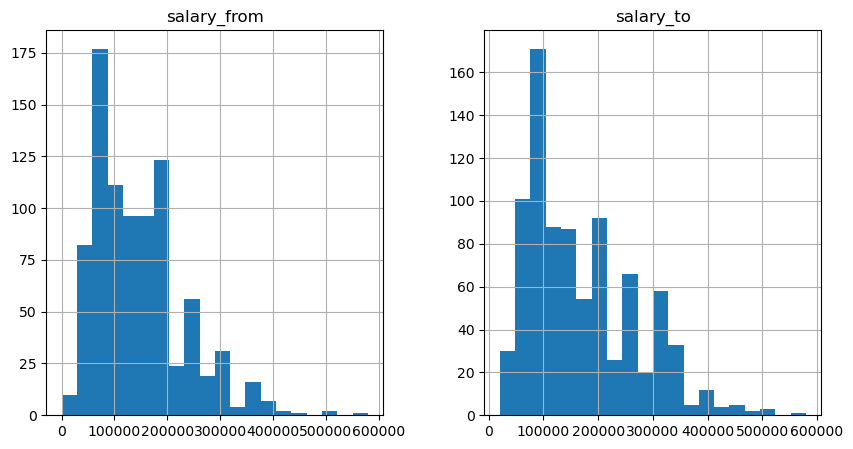

In [37]:
# отобразим распределение на тех.графике
df[['salary_from', 'salary_to']].hist(bins=20, figsize=(10,5));

In [38]:
# создадим список полей для удобства отображения
vision_list = ['name', 'published_at', 'alternate_url', 'employer', 'area', 'grade',
               'salary_from', 'salary_to', 'salary_bin', 'source']

In [39]:
# выведем минимальные значения в поле salary_from (5 шт)
df[vision_list].sort_values(['salary_from']).head()

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
1110,Аналитик данных в отдел развития на маркетплейсах,2024-05-11 21:45:07,https://hh.ru/vacancy/96943446,Репетуев Иван Дмитриевич,Москва,Junior,50,100001,От 100 тысяч до 200 тысяч,df_da
3271,Системный Аналитик Middle/Senior,2024-07-06 15:14:38,https://hh.ru/vacancy/91944373,Datanomica,Москва,Senior,280,340000,Больше 300 тысяч,df_sa
2672,Проект менеджер / Системный аналитик,2024-07-02 15:33:49,https://hh.ru/vacancy/103145776,Крылов Николай Алексеевич,Москва,Junior,20000,20000,Меньше 100 тысяч,df_sa
1478,Стажер Дата Аналитик,2024-05-12 15:30:23,https://hh.ru/vacancy/98480289,Автомакон,Москва,Junior,25000,25000,Меньше 100 тысяч,df_da
293,Стажер Дата Аналитик,2024-06-10 16:06:06,https://hh.ru/vacancy/101516298,Автомакон,Москва,Junior,25000,25000,Меньше 100 тысяч,df_da


In [40]:
# выведем максимальные значения в поле salary_from (5 шт)
# исключаем пустые значения
df[vision_list][df.salary_from.notna()].sort_values(['salary_from']).tail() 

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
982,Senior Data Analyst,2024-04-04 15:47:49,https://hh.ru/vacancy/96195495,Wanted,Москва,Middle,420750,420750,Больше 300 тысяч,df_da
3021,Ведущий системный аналитик,2024-07-08 12:34:55,https://hh.ru/vacancy/103496680,WMT,Москва,Middle,450000,450000,Больше 300 тысяч,df_sa
3274,Старший системный аналитик,2024-06-30 14:19:53,https://hh.ru/vacancy/92032011,БЕТСИТИ,Москва,Middle,500000,500000,Больше 300 тысяч,df_sa
3301,Старший системный аналитик,2024-06-30 14:19:58,https://hh.ru/vacancy/92907892,БЕТСИТИ,Ростов-на-Дону,Middle,500000,500000,Больше 300 тысяч,df_sa
3096,Системный аналитик Senior,2024-07-09 07:41:15,https://hh.ru/vacancy/103552148,Offer Now,Москва,Junior+,580000,580000,Больше 300 тысяч,df_sa


Заметили ошибку в первых двух значениях минимальной зарплаты. Скорее всего, подразумеваются значения в тысячах рублей. Исправим значения 50 руб и 280 руб на 50 тыс. руб и 280 тыс. руб соответственно. <br><br>
Необходимо также провести дополнительный анализ зарплаты и грейда кандидата. Сделаем это после проверки на дубликаты, так как возможно, что вакансия была переподана с исправленными данными. <br> <br>
Столбец salary_bin заполняется на основе данных из salary_to. Нужно заполнить salary_bin как среднее значение между salary_from и salary_to для отображение средней группы зарплаты <br> <br>

Аналогично проверим поле salary_from

In [41]:
# выведем минимальные значения в поле salary_to (5 шт)
df[vision_list].sort_values(['salary_to']).head()

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
2672,Проект менеджер / Системный аналитик,2024-07-02 15:33:49,https://hh.ru/vacancy/103145776,Крылов Николай Алексеевич,Москва,Junior,20000,20000,Меньше 100 тысяч,df_sa
2196,Системный аналитик-стажер,2024-07-08 10:10:01,https://hh.ru/vacancy/102335933,Автомакон,Москва,Junior,25000,25000,Меньше 100 тысяч,df_sa
1478,Стажер Дата Аналитик,2024-05-12 15:30:23,https://hh.ru/vacancy/98480289,Автомакон,Москва,Junior,25000,25000,Меньше 100 тысяч,df_da
293,Стажер Дата Аналитик,2024-06-10 16:06:06,https://hh.ru/vacancy/101516298,Автомакон,Москва,Junior,25000,25000,Меньше 100 тысяч,df_da
1102,"Стажер/Аналитик данных (Python, Power BI)",2024-05-03 17:10:07,https://hh.ru/vacancy/96829084,ППК Фонд развития территорий,Москва,Junior,26000,26000,Меньше 100 тысяч,df_da


In [42]:
# выведем максимальные значения в поле salary_to (5 шт)
# исключаем пустые значения
df[vision_list][df.salary_to.notna()].sort_values(['salary_to']).tail() 

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
238,Data Analyst (middle/senior),2024-06-11 10:52:45,https://hh.ru/vacancy/101326113,Fundraise Up,Москва,Middle,299200,495550,Больше 300 тысяч,df_da
1697,Data Analyst,2024-05-20 11:07:34,https://hh.ru/vacancy/99555701,Mayflower,Москва,Middle,398000,497500,Больше 300 тысяч,df_da
3301,Старший системный аналитик,2024-06-30 14:19:58,https://hh.ru/vacancy/92907892,БЕТСИТИ,Ростов-на-Дону,Middle,500000,500000,Больше 300 тысяч,df_sa
3274,Старший системный аналитик,2024-06-30 14:19:53,https://hh.ru/vacancy/92032011,БЕТСИТИ,Москва,Middle,500000,500000,Больше 300 тысяч,df_sa
3096,Системный аналитик Senior,2024-07-09 07:41:15,https://hh.ru/vacancy/103552148,Offer Now,Москва,Junior+,580000,580000,Больше 300 тысяч,df_sa


По salary_to нет явных ошибок. <br>
Также есть несоответствие грейда кандидата и указанная зарплата

In [43]:
# исправляем низкие solary_from 
# переводим т.руб в руб
df.loc[[1110, 3271], 'salary_from'] = df.loc[[1110, 3271], 'salary_from'] * 10**3 

df.loc[[1110, 3271]][vision_list] # проверка

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
1110,Аналитик данных в отдел развития на маркетплейсах,2024-05-11 21:45:07,https://hh.ru/vacancy/96943446,Репетуев Иван Дмитриевич,Москва,Junior,50000,100001,От 100 тысяч до 200 тысяч,df_da
3271,Системный Аналитик Middle/Senior,2024-07-06 15:14:38,https://hh.ru/vacancy/91944373,Datanomica,Москва,Senior,280000,340000,Больше 300 тысяч,df_sa


##### изменение категорий в salary_bin

Изменим категории в salary_bin. В salary_bin укажим средную зарплату между salary_from и salary_to. <br><br>
Будем использовать следующие категории:
* Менее 50 т.руб
* От 50 до 100 т.руб
* От 100 до 150 т.руб
* От 150 до 200 т.руб
* От 200 до 300 т.руб
* Свыше 300 т.руб
* ЗП не указана

Дополнительно поменяется тип поля на 'category'

In [44]:
# создадим поле со среднем размером зарплаты
df['salary_mean'] = ((df.salary_from+df.salary_to) / 2).round(0)
df.sample()

,id,name,published_at,alternate_url,type,employer,department,area,grade,key_skills,...,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source,education_req,hard_skills,soft_skills,salary_mean
2865,103304961,Системный Аналитик ELMA,2024-07-07 16:18:27,https://hh.ru/vacancy/103304961,Открытая,Лаборатория Безопасных Систем,no_data,Москва,Junior+,"[.net framework, bpmn, elma, xml, системная ин...",...,<NA>,ЗП не указана,"BPMN, Системная интеграция, XML, .NET Framewor...",NaN,NaN,df_sa,высокий технический экономический образование,"[bpmn, xml, системная интеграция]",no_data,<NA>


In [45]:
# создаем границы категорий в виде списка
boundaries = [0, 50*10**3, 100*10**3, 150*10**3, 200*10**3, 300*10**3, np.inf] # inf - бесконечность
# создаем метки категорий
labels = ['Менее 50 т.руб',
    'От 50 до 100 т.руб',
    'От 100 до 150 т.руб',
    'От 150 до 200 т.руб',
    'От 200 до 300 т.руб',
    'Свыше 300 т.руб']

# разделяем на новые категории
df['salary_bin'] = pd.cut(
    df['salary_mean'], # средняя запралата
    bins=boundaries,
    labels=labels,
    right=False  # не включая правую границу 
                    )

# меняем пропуски на категорию 'ЗП не указана'
df['salary_bin'] = df['salary_bin'].cat.add_categories('ЗП не указана'
                                                      ).fillna('ЗП не указана')


df[vision_list].sample(5) # проверка

,name,published_at,alternate_url,employer,area,grade,salary_from,salary_to,salary_bin,source
82,Product Data Analyst (удаленно),2024-05-28 13:12:30,https://hh.ru/vacancy/100490237,IBS,Москва,Middle,<NA>,<NA>,ЗП не указана,df_da
410,Аналитик данных / BI-аналитик,2024-05-08 08:23:05,https://hh.ru/vacancy/92027948,Кейсистемс,Чебоксары,Junior+,85000,100000,От 50 до 100 т.руб,df_da
2504,Системный аналитик (Система управления IT-бизн...,2024-07-01 10:17:40,https://hh.ru/vacancy/103026833,Ростелеком Информационные Технологии,Пермь,Junior+,<NA>,<NA>,ЗП не указана,df_sa
144,IT-специалист (аналитик данных),2024-05-30 15:24:58,https://hh.ru/vacancy/100726294,ГБУЗ Владимирской области Медицинский информац...,Владимир,Junior+,40000,40000,Менее 50 т.руб,df_da
101,Data analyst (India),2024-06-11 12:04:49,https://hh.ru/vacancy/100581593,Finstar Financial Group,Москва,Junior+,257125,257125,От 200 до 300 т.руб,df_da


**Вывод по подразделу:** <br>
* Исправили явные ошибки в заполнении минимальной зарплаты 
* [Изменили поле salary_bin](#изменение-категорий-в-salary_bin)
<br><br>
*Дополнительно после обработки дубликатов надо проверить соответствие зарплат и грейдов*

#### Удаление полей

Удаляем поля key_skills_from_key_skills_field, hard_skills_from_description, soft_skills_from_description т.к. пользоваться ими не будем (созданны аналоги). <br>
Удаляем поле type т.к. у нас только [открытые вакансии](#Проверка-категориальных-значений) 

In [46]:
# удаляем поля
df = df.drop(columns=['type','key_skills_from_key_skills_field', 
                      'hard_skills_from_description', 
                      'soft_skills_from_description'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      3716 non-null   int64         
 1   name                    3716 non-null   object        
 2   published_at            3716 non-null   datetime64[ns]
 3   alternate_url           3716 non-null   object        
 4   employer                3716 non-null   object        
 5   department              3716 non-null   object        
 6   area                    3716 non-null   object        
 7   grade                   3716 non-null   object        
 8   key_skills              3716 non-null   object        
 9   schedule                3716 non-null   object        
 10  employment              3716 non-null   object        
 11  description             3716 non-null   object        
 12  description_lemmatized  3716 non-null   object  

**Вывод по подразделу:** <br>
* Были удаленны поля key_skills_from_key_skills_field, hard_skills_from_description и soft_skills_from_description.

#### Проверка на дубликаты

In [47]:
# проверка дубликатов по id вакансии
df[df.duplicated(['id'], keep=False)].sort_values('id')

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean
344,85053195,System analyst DWH / Data Analyst,2024-06-03 09:36:32,https://hh.ru/vacancy/85053195,Axenix (ранее Accenture),no_data,Краснодар,Junior+,"[airflow, dwh, greenplum, hadoop, informatica,...",Удаленная работа,...,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[airflow, dwh, greenplum, hadoop, informatica,...",no_data,<NA>
3178,85053195,System analyst DWH,2024-07-01 10:11:06,https://hh.ru/vacancy/85053195,Axenix (ранее Accenture),no_data,Краснодар,Junior+,"[airflow, dwh, etl, greenplum, hadoop, informa...",Удаленная работа,...,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[airflow, dwh, etl, greenplum, hadoop, informa...",no_data,<NA>
1461,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-06-11 09:57:39,https://hh.ru/vacancy/98441008,AVO.UZ,no_data,Москва,Junior+,"[dwh, ms sql, системный анализ]",Полный день,...,команда avo services and technology создает по...,команда avo services and technology создавать ...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[dwh, ms sql, системный анализ]",no_data,<NA>
3559,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-07-08 09:57:40,https://hh.ru/vacancy/98441008,AVO.UZ,no_data,Москва,Junior+,"[dwh, ms sql, системный анализ]",Полный день,...,команда avo services and technology создает по...,команда avo services and technology создавать ...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[dwh, ms sql, системный анализ]",no_data,<NA>
102,100581829,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581829,Сеть Партнерств,no_data,Москва,Middle,"[api, confluence, dwh, etl, postgresql, python...",Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000,От 200 до 300 т.руб,df_da,no_data,"[api, confluence, dwh, etl, postgresql, python...",no_data,250000.0
1832,100581829,Аналитик данных \ Системный аналитик,2024-06-27 12:04:15,https://hh.ru/vacancy/100581829,Сеть Партнерств,no_data,Москва,Middle,"[api, confluence, dwh, etl, postgresql, python...",Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000,От 200 до 300 т.руб,df_sa,no_data,"[api, confluence, dwh, etl, postgresql, python...",no_data,250000.0
103,100581830,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581830,Сеть Партнерств,no_data,Краснодар,Middle,[confluence],Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000,От 200 до 300 т.руб,df_da,no_data,[confluence],no_data,250000.0
1833,100581830,Системный аналитик \ Аналитик данных,2024-06-27 12:12:35,https://hh.ru/vacancy/100581830,Сеть Партнерств,no_data,Краснодар,Middle,[confluence],Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000,От 200 до 300 т.руб,df_sa,no_data,[confluence],no_data,250000.0
104,100581831,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581831,Сеть Партнерств,no_data,Санкт-Петербург,Middle,[confluence],Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000,От 200 до 300 т.руб,df_da,no_data,[confluence],no_data,250000.0
1834,100581831,Системный аналитик \ Аналитик данных,2024-07-05 09:28:01,https://hh.ru/vacancy/100581831,Сеть Партнерств,no_data,Санкт-Петербург,Middle,[confluence],Полный день,...,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000,250000

Найдено 10 дубликатов по id вакансии. Так произошло из за того что ранее опубликованные вакансии редактировались и менялся поиск аналитика данных на системного аналитика. Будем считать, что поздние редакции правильные и удалим ранние вакансии.

In [48]:
# удаляем дубликаты по id (оставляем поздние версии)
df = df.drop(df[df.duplicated(['id'], keep='last')].sort_values('published_at').index)

In [49]:
# выведем дубликаты по списку полей для анализа
df[df.duplicated(
    ['name', 'employer', 'department','area', 
     'description_lemmatized', 'salary_from', 'salary_to'
    ], keep=False)].sort_values(['name', 'employer', 'department', 'published_at'])

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean
1408,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>
72,100463980,BI-аналитик/ Аналитик данных,2024-06-09 10:00:29,https://hh.ru/vacancy/100463980,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>
417,92196267,Data Analyst,2024-04-16 10:14:39,https://hh.ru/vacancy/92196267,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,lesta games разрабатывает игровые проекты в ра...,lesta games разрабатывать игровой проект разли...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>
1462,98449572,Data Analyst,2024-06-09 10:43:45,https://hh.ru/vacancy/98449572,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,lesta games разрабатывает игровые проекты в ра...,lesta games разрабатывать игровой проект разли...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>
1410,98138306,Data Analyst,2024-04-29 16:17:24,https://hh.ru/vacancy/98138306,Reinvent Baltics,no_data,Москва,Senior,"[analysis, data warehousing, eda, power bi, py...",Полный день,...,rozert is an international product company dev...,rozert is an international product company dev...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[power bi, python, sql, tableau, анализ рынка,...","[английский язык, коммуникация, решение проблем]",<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,96494928,Старший аналитик данных (маркетинг),2024-04-09 09:38:57,https://hh.ru/vacancy/96494928,Ozon,Ozon Офис и Коммерция,Москва,Middle,"[pandas, pr, python, sql, маркетинг, математич...",Удаленная работа,...,чем предстоит заниматься: отслеживать и собир...,предстоять заниматься отслеживать собирать раз...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[pandas, python, sql, математическая статистика]",no_data,<NA>
819,95548988,Урбан-аналитик данных,2024-03-26 15:33:29,https://hh.ru/vacancy/95548988,Mayak,no_data,Москва,Junior+,"[arcgis, gis, python, qgis, английский язык, д...",Полный день,...,обязанности: • анализ рынка/субрынков коммерче...,обязанность анализ рынок субрынок коммерческий...,100000,100000,От 100 до 150 т.руб,df_da,высокий образование,"[python, маркетинговый анализ, работа с больши...","[английский язык, многозадачность, тайм-менедж...",100000.0
1747,99737480,Урбан-аналитик данных,2024-06-08 17:13:09,https://hh.ru/vacancy/99737480,Mayak,no_data,Москва,Junior+,"[arcgis, gis, python, qgis, английский язык, д...",Полный день,...,обязанности: • анализ рынка/субрынков коммерче...,обязанность анализ рынок субрынок коммерческий...,100000,100000,От 100 до 150 т.руб,df_da,высокий образование,"[python, маркетинговый анализ, работа с больши...","[английский язык, многозадачность, тайм-менедж...",100000.0
1302,97652565,Эксперт-аналитик данных в группу цифрового аудита,2024-04-22 18:24:19,https://hh.ru/vacancy/97652565,Recruitment Boutique S.M.Art,no_data,Москва,Junior+,"[ms sql, python, аудит]",Полный день,...,ищем эксперта со знанием инструментов анализа ...,искать эксперт знание инструмент анализ данные...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[ms sql, python, аудит]",no_data,<NA>


Таких 'дубликатов' 460 строк. Но большинство из них выложено в разные даты. Возможно, был повторный найм на новое место или предыдущий кандидат не прошел испытательный срок. <br>
Проведем дополнительный анализ данного датафрейма. 

In [50]:
# создадим копию df с найденными 'дубликатами'
df_temp_dup = df[df.duplicated(
    ['name', 'employer', 'department','area', 
     'description_lemmatized', 'salary_from', 'salary_to'
    ], keep=False)].sort_values(['name', 'employer', 'department', 'published_at']).loc[:]

# создадим поле с указанием даты без времени
df_temp_dup['date'] = df['published_at'].dt.date

# создаем поле с разницой в днях между публикациями по группам
df_temp_dup['days_diff'] = df_temp_dup.groupby([
    'name', 'employer', 'department','area', 'description_lemmatized'])['date'].diff()
# приводим к deltatime в днях
df_temp_dup['days_diff'] = pd.to_timedelta(df_temp_dup['days_diff']).dt.days
# заменяем пропуски на -1 чтобы явно указать первые в группе
df_temp_dup['days_diff'] = df_temp_dup['days_diff'].fillna(-1)

df_temp_dup.head()

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,date,days_diff
1408,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>,2024-05-12,-1.0
72,100463980,BI-аналитик/ Аналитик данных,2024-06-09 10:00:29,https://hh.ru/vacancy/100463980,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>,2024-06-09,28.0
417,92196267,Data Analyst,2024-04-16 10:14:39,https://hh.ru/vacancy/92196267,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>,2024-04-16,-1.0
1462,98449572,Data Analyst,2024-06-09 10:43:45,https://hh.ru/vacancy/98449572,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>,2024-06-09,54.0
1410,98138306,Data Analyst,2024-04-29 16:17:24,https://hh.ru/vacancy/98138306,Reinvent Baltics,no_data,Москва,Senior,"[analysis, data warehousing, eda, power bi, py...",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[power bi, python, sql, tableau, анализ рынка,...","[английский язык, коммуникация, решение проблем]",<NA>,2024-04-29,-1.0


Видим, что некоторые публикации вакансий были сделаны через продолжительное время, а некоторые нет. <br>
Будем считать, что если публикация повторяется менее чем через две недели, то это дубликат. Оставим первую публикацию и удалим последующие.

In [51]:
# получаем индексы строк для удаления
drop_index = df_temp_dup[(df_temp_dup.days_diff >=0) & (df_temp_dup.days_diff<14)].index

# удаляем по-индексо дубликаты 
# удаляем дубликаты по id (оставляем поздние версии)
df = df.drop(drop_index)

Остается проверить аналогичные дубликаты, в которые вносились изменения по зарплате.

In [52]:
# создадим копию df с найденными дубликатами без учета дублей по зарплате
df_temp_dup = df[df.duplicated(
    ['name', 'employer', 'department','area', 
     'description_lemmatized'
    ], keep=False)].sort_values(['name', 'employer', 'department', 'published_at']).loc[:]

# создадим поле с указанием даты без времени
df_temp_dup['date'] = df['published_at'].dt.date

# создаем поле с разницой в днях между публикациями по группам
df_temp_dup['days_diff'] = df_temp_dup.groupby([
    'name', 'employer', 'department','area', 'description_lemmatized'])['date'].diff()
# приводим к deltatime в днях
df_temp_dup['days_diff'] = pd.to_timedelta(df_temp_dup['days_diff']).dt.days
# заменяем пропуски на -1 чтобы явно указать первые в группе
df_temp_dup['days_diff'] = df_temp_dup['days_diff'].fillna(-1)

df_temp_dup.head()

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,date,days_diff
1408,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>,2024-05-12,-1.0
72,100463980,BI-аналитик/ Аналитик данных,2024-06-09 10:00:29,https://hh.ru/vacancy/100463980,Сэлвим,no_data,Москва,Junior+,[pandas],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,[pandas],no_data,<NA>,2024-06-09,28.0
417,92196267,Data Analyst,2024-04-16 10:14:39,https://hh.ru/vacancy/92196267,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>,2024-04-16,-1.0
1462,98449572,Data Analyst,2024-06-09 10:43:45,https://hh.ru/vacancy/98449572,Lesta Games,no_data,Санкт-Петербург,Junior+,"[finebi, python, sql]",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[finebi, python, sql]",no_data,<NA>,2024-06-09,54.0
1273,97463573,Data Analyst,2024-04-19 18:45:38,https://hh.ru/vacancy/97463573,Mayflower,no_data,Москва,Middle,"[airflow, big data, python, sql, tableau, а/в-...",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[airflow, big data, python, sql, tableau, а/в-...","[английский язык, коммуникация, критическое мы...",<NA>,2024-04-19,-1.0


In [53]:
# далее перезапишем временный df и оставим только дубликаты первичные и повторы до 14 дней
df_temp_dup = df_temp_dup[df_temp_dup.days_diff <14]

# выведем из получившегося df дубликаты без учета зарплаты
df_temp_dup[df_temp_dup.duplicated(
    ['name', 'employer', 'department','area', 'description_lemmatized'], keep=False)].sort_values(
            ['name', 'employer', 'department', 'published_at'])

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,date,days_diff
752,95186988,Аналитик данных,2024-03-25 15:01:08,https://hh.ru/vacancy/95186988,ГКУ Центр занятости населения города Москвы,no_data,Москва,Junior+,"[excel, machine learning, powerpoint, python, ...",Полный день,...,80000,98000,От 50 до 100 т.руб,df_da,no_data,"[excel, machine learning, powerpoint, python, ...",no_data,89000.0,2024-03-25,-1.0
921,95965579,Аналитик данных,2024-04-23 15:18:00,https://hh.ru/vacancy/95965579,ГКУ Центр занятости населения города Москвы,no_data,Москва,Junior+,"[excel, powerbi, python, sql, vba, сводные таб...",Полный день,...,100000,100000,От 100 до 150 т.руб,df_da,высокий экономический образование,"[excel, powerbi, python, sql, vba, сводные таб...",no_data,100000.0,2024-04-23,-1.0
1352,97877596,Аналитик данных,2024-04-25 09:58:47,https://hh.ru/vacancy/97877596,ГКУ Центр занятости населения города Москвы,no_data,Москва,Junior+,[power bi],Полный день,...,70000,90000,От 50 до 100 т.руб,df_da,no_data,[power bi],no_data,80000.0,2024-04-25,0.0
1369,97929739,Аналитик данных,2024-04-25 17:27:28,https://hh.ru/vacancy/97929739,ГКУ Центр занятости населения города Москвы,no_data,Москва,Junior+,"[excel, powerbi, python, sql, vba, сводные таб...",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,высокий экономический образование,"[excel, powerbi, python, sql, vba, сводные таб...",no_data,<NA>,2024-04-25,2.0
1368,97929624,Аналитик данных,2024-05-25 17:24:22,https://hh.ru/vacancy/97929624,ГКУ Центр занятости населения города Москвы,no_data,Москва,Junior+,"[excel, powerbi, python, sql, vba, сводные таб...",Полный день,...,150000,150000,От 150 до 200 т.руб,df_da,высокий экономический образование,"[excel, powerbi, python, sql, vba, сводные таб...",no_data,150000.0,2024-05-25,1.0
929,95986278,Аналитик данных IVR,2024-04-02 13:02:02,https://hh.ru/vacancy/95986278,СБЕР,Сбер для экспертов,Адыгейск,Junior+,"[python, qlikview, spark, sql, навыки презента...",Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[python, qlikview, spark, sql]",[навыки презентации],<NA>,2024-04-02,-1.0
979,96176248,Аналитик данных IVR,2024-04-04 12:43:00,https://hh.ru/vacancy/96176248,СБЕР,Сбер для экспертов,Адыгейск,Junior+,"[python, qlikview, spark, sql, навыки презента...",Полный день,...,45000,50000,Менее 50 т.руб,df_da,no_data,"[python, qlikview, spark, sql]",[навыки презентации],47500.0,2024-04-04,2.0


Строк не много, можно произвести визуальный анализ:
* Строки 929 и 979 отличаются в 2 дня публикации и указанием зарплаты. Удалим первичную строку 929 без указания зарплаты. 
* Строки 752 и 1368 отличаются месяцем публикации. Оставляем их.
* В строке 1352 есть кординальные отличия по навыкам. Оставляем ее.
* Оставшиеся строки 921 и 1369 отличаются только в указании зарплаты. Т.к. в строке 921 есть указание зарплаты - ее оставим, а строку 1369 удалим.
<br> <br>
**К удалению строки с индексами 929 и 1369**

In [54]:
# удаляем строки с дубликатами 929 и 1369
df = df.drop([929, 1369])

df.info() # проверка итогового df

<class 'pandas.core.frame.DataFrame'>
Index: 3691 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      3691 non-null   int64         
 1   name                    3691 non-null   object        
 2   published_at            3691 non-null   datetime64[ns]
 3   alternate_url           3691 non-null   object        
 4   employer                3691 non-null   object        
 5   department              3691 non-null   object        
 6   area                    3691 non-null   object        
 7   grade                   3691 non-null   object        
 8   key_skills              3691 non-null   object        
 9   schedule                3691 non-null   object        
 10  employment              3691 non-null   object        
 11  description             3691 non-null   object        
 12  description_lemmatized  3691 non-null   object       

**Вывод по подразделу:** <br>
* За дубликаты приняли вакансии с одинаковыми id и одинаковые вакансии с разницей в размещении менее 14 дней.
* Удалили 25 дубликатов. 


#### Проверка на соотношении зарплат и грейда

##### Проверка соответствий grade и названию вакансии

Сначала создадим временное поля с указанием грейда из наименования вакансии.

In [55]:
# передаем список слов в нижнем регистре
# название берем в нижнем регистре
# выдаем списки всего что можем через функцию find_words

# создаем список искомых слов 
searched_words = ['junior', 'junior+', 'middle', 'senior', 'стажер', 
                  'руководитель', 'директор', 'lead', 'cto', 'head', 
                  'глава', 'новичек', 'начинающий', 'старший']

# функция find_words определена в п.1.2.1
df['grade_from_name'] = df.name.str.lower().transform(find_words, 
                                                      words=searched_words, 
                                                      return_list=False)

# проверка
df.grade_from_name.value_counts()

grade_from_name
{}                                3087
{middle}                           201
{senior}                           117
{junior}                            91
{старший}                           76
{стажер}                            43
{lead}                              23
{middle, senior}                    17
{руководитель}                      12
{senior, старший}                    6
{начинающий}                         6
{middle, junior}                     6
{lead, старший}                      3
{руководитель, lead}                 1
{middle, старший}                    1
{руководитель, директор, lead}       1
Name: count, dtype: int64

In [56]:
# выполним преобразование не регламентированных грейдов в регламентированные

# напишим функцию для переименования
def temp_rename_set(input_set, replace_dict):
    # возвращаем множество переименованных элементов, 
    # если нет в ключе словаря, то исходный элекмент
    return {replace_dict.get(elem, elem) for elem in input_set}  

# создаем переменную для фильтрации всех пустых множеств
flag_empty_set = df.grade_from_name.transform(len)!=0

# создаем словарь замен с вложениями (ключ регламентированное название)
repl_dict = {
    'junior': {'стажер', 'начинающий'},
    'senior': {'lead', 'старший', 'руководитель', 'директор'}
            }

# "переворачиваем" словарь c помощью dictionary comprehension
flattened_dict = {original: new for new, originals in repl_dict.items() for original in originals}

# выполняем преобразование
df.loc[flag_empty_set, 'grade_from_name'] = df.loc[flag_empty_set, 'grade_from_name'
                                ].transform(temp_rename_set, replace_dict=flattened_dict)

df.loc[flag_empty_set, 'grade_from_name'].value_counts() #проверка

grade_from_name
{senior}            239
{middle}            201
{junior}            140
{middle, senior}     18
{middle, junior}      6
Name: count, dtype: int64

Т.к. по названиям нет разделение на junior и junior+ будем считать грейды равнозначными. <br>
Добавим ко всем множествам где есть элемент 'junior' элемент 'junior+' 

In [57]:
# добавляем junior+ к junior
# x.add изменяет исходное множество и возращает None
# x.add or x возвращает измененное множество x т.к. слево None
df['grade_from_name'] = df['grade_from_name'].transform(
    lambda x: x.add('junior+') or x if 'junior' in x else x)

df.loc[flag_empty_set, 'grade_from_name'].value_counts() #проверка

grade_from_name
{senior}                     239
{middle}                     201
{junior, junior+}            140
{middle, senior}              18
{middle, junior, junior+}      6
Name: count, dtype: int64

In [58]:
# создадим булеву маску проверки что значение grade
# не содержится в множестве grade_from_name
mask_grade = df.apply(lambda x: x.grade.lower() not in x.grade_from_name, axis=1) # сверка по строкам

# выводим df где в название указан grade_from_name и он не соответствует полю grade
df[flag_empty_set & mask_grade]

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,grade_from_name
5,100059110,Senior Data Analyst (Цифровой билайн),2024-06-11 11:45:29,https://hh.ru/vacancy/100059110,билайн,"билайн: ИТ, Data, Digital",Москва,Middle,"[python, sql, математическая статистика]",Удаленная работа,...,сегодня билайн компания изменение чутко реагир...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[python, sql, математическая статистика]",no_data,<NA>,{senior}
22,100103797,Старший аналитик данных (клиентский опыт),2024-05-28 13:45:38,https://hh.ru/vacancy/100103797,Ozon,Ozon Офис и Коммерция,Москва,Middle,"[pandas, python, sql, математическая статистик...",Полный день,...,команда дирекция клиентский опыт группа продук...,<NA>,<NA>,ЗП не указана,df_da,высокий технический экономический математическ...,"[pandas, python, sql, математическая статистика]",no_data,<NA>,{senior}
23,100108743,Senior Data Analyst (Ads Platform),2024-06-11 13:48:36,https://hh.ru/vacancy/100108743,WILDBERRIES,no_data,Москва,Middle,"[bi, python, sql, а/в-тестирования]",Удаленная работа,...,wildberries крупный игрок российский рынок e c...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[bi, python, sql, а/в-тестирования]",no_data,<NA>,{senior}
27,100161630,Старший Аналитик данных в Яндекс Маркет,2024-06-05 16:32:52,https://hh.ru/vacancy/100161630,Яндекс,Яндекс.Маркет,Москва,Middle,"[sql, математическая статистика, статистически...",Полный день,...,платформа b2c сердце пользовательский продукт ...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[sql, математическая статистика, статистически...",no_data,<NA>,{senior}
32,100303511,Senior Data Analyst,2024-05-27 09:16:36,https://hh.ru/vacancy/100303511,WILDBERRIES,no_data,Москва,Junior+,"[dwh, power bi, sql]",Полный день,...,wildberries крупный маркетплейс россия wildber...,<NA>,<NA>,ЗП не указана,df_da,no_data,"[dwh, power bi, sql]",no_data,<NA>,{senior}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663,99178000,Middle system analyst (Web),2024-07-08 09:43:32,https://hh.ru/vacancy/99178000,Совкомбанк Технологии,no_data,Краснодар,Junior+,"[agile, bpmn, confluence, confluence, jira, po...",Полный день,...,амбициозный быстрорастущий ита подразделение к...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[bpmn, confluence, confluence, jira, postman, ...","[agile, scrum, управление проектами]",<NA>,{middle}
3664,99178829,Middle system analyst (Web),2024-07-08 09:43:39,https://hh.ru/vacancy/99178829,Совкомбанк Технологии,no_data,Самара,Junior+,"[agile, bpmn, confluence, confluence, jira, po...",Полный день,...,амбициозный быстрорастущий ита подразделение к...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[bpmn, confluence, confluence, jira, postman, ...","[agile, scrum, управление проектами]",<NA>,{middle}
3673,99275260,Middle/senior Системный аналитик (МТС Голосова...,2024-07-01 18:50:17,https://hh.ru/vacancy/99275260,МТС,"«МТС», Digital",Москва,Junior+,"[bpmn, json api, rest, soap, uml, xml, аналити...",Удаленная работа,...,мтс digital единый центр технологический разви...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[bpmn, json api, rest, soap, uml, xml]",[аналитическое мышление],<NA>,{middle}
3679,99557686,Старший системный аналитик,2024-07-04 18:30:12,https://hh.ru/vacancy/99557686,ЦРТ | Группа компаний,no_data,Санкт-Петербург,Middle,"[confluence, коммуникация]",Полный день,...,наш команда реализовать амбициозный проект раз...,<NA>,<NA>,ЗП не указана,df_sa,no_data,[confluence],[коммуникация],<NA>,{senior}


Таких строк 339. Будем полагать, что работодатель знает какой уровень компетенции ему нужен от сотрудника и в приоритете будут градации из названия вакансии.

In [59]:
# выводим уникальные значение и их кол-во
df[flag_empty_set & mask_grade].grade_from_name.value_counts() 

grade_from_name
{senior}            223
{middle}            110
{middle, senior}      6
Name: count, dtype: int64

In [60]:
# выводим сдвоенное обозначение
# через маску т.к. работаем со множеством
mask_temp = df['grade_from_name'].apply(lambda x: x == {'senior', 'middle'})

df[flag_empty_set & mask_grade & mask_temp] # вывод

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,grade_from_name
2198,102341313,Системный аналитик (middle+/senior),2024-07-08 11:01:18,https://hh.ru/vacancy/102341313,Архимед плюс,no_data,Казань,Junior+,"[rest, soap, sql, аналитическое мышление, пост...",Удаленная работа,...,архимед плюс российский разработчик программны...,200000,200000,От 200 до 300 т.руб,df_sa,высокий технический образование,"[rest, soap, sql, постановка задач разработчик...","[аналитическое мышление, системное мышление, у...",200000.0,"{middle, senior}"
2251,102623461,Системный аналитик (middle / senior),2024-07-06 19:22:24,https://hh.ru/vacancy/102623461,Медицина,no_data,Уфа,Junior+,"[sql, бизнес-анализ, коммуникация, моделирован...",Удаленная работа,...,компания команда команда zabota 2 являться лид...,120000,180000,От 150 до 200 т.руб,df_sa,no_data,"[sql, бизнес-анализ, моделирование бизнес проц...",[коммуникация],150000.0,"{middle, senior}"
2252,102623462,Системный аналитик (middle / senior),2024-07-06 19:22:24,https://hh.ru/vacancy/102623462,Медицина,no_data,Новосибирск,Junior+,"[sql, бизнес-анализ, коммуникация, моделирован...",Удаленная работа,...,компания команда команда zabota 2 являться лид...,120000,180000,От 150 до 200 т.руб,df_sa,no_data,"[sql, бизнес-анализ, моделирование бизнес проц...",[коммуникация],150000.0,"{middle, senior}"
2259,102657070,"Системный аналитик (middle, senior)",2024-07-07 10:20:26,https://hh.ru/vacancy/102657070,AFFINAGE,no_data,Москва,Junior+,"[html, rest, soap, xml]",Удаленная работа,...,affinage топовый веб продакшн россия мощный fr...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[html, rest, soap, xml]",no_data,<NA>,"{middle, senior}"
3134,103583874,Системный аналитик middle / senior удаленно,2024-07-09 12:38:43,https://hh.ru/vacancy/103583874,MKomov Studio,no_data,Петрозаводск,Junior+,"[bpmn, user story, клиент-серверная архитектур...",Полный день,...,mkomov studio студия решение задача государств...,240000,280000,От 200 до 300 т.руб,df_sa,no_data,"[bpmn, user story, разработка проектной докуме...",[проактивность],260000.0,"{middle, senior}"
3394,95234955,"Системный аналитик (middle, senior)",2024-07-08 09:59:26,https://hh.ru/vacancy/95234955,Т1,ГК Иннотех | Финтех (Иннотех),Москва,Junior+,"[bpmn, oracle, postgresql, rest api, soap]",Удаленная работа,...,важный заметка кандидат просить учитывать весь...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[bpmn, oracle, postgresql, rest api, soap]",no_data,<NA>,"{middle, senior}"


Т.к. по грейду из API hh.ru все сдвоенные middle/senior являются junior+, оставим только грейд middle в grade_from_name

In [61]:
# удаляем из сдвоенных множеств senior 
df['grade_from_name'] = df['grade_from_name'].transform(
    lambda x: x.discard('senior') or x if {'senior', 'middle'}.issubset(x) else x)

# получаем df с несоответствиями с единичными значениями 
df[flag_empty_set & mask_grade].grade_from_name.value_counts() # проверка 

grade_from_name
{senior}    223
{middle}    116
Name: count, dtype: int64

In [62]:
# заменяем данные значения grade на значения из наименования вакансии
# с переводом в формат значений grade (с большой буквы)
df.loc[flag_empty_set & mask_grade, 'grade'] = df[flag_empty_set & mask_grade
                                    ].grade_from_name.transform(lambda x: x.pop()
                                                               ).str.capitalize()

df.grade.unique() # проверка

array(['Junior', 'Junior+', 'Middle', 'Senior'], dtype=object)

In [63]:
# удаляем временное поле
df = df.drop(columns=['grade_from_name'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3691 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      3691 non-null   int64         
 1   name                    3691 non-null   object        
 2   published_at            3691 non-null   datetime64[ns]
 3   alternate_url           3691 non-null   object        
 4   employer                3691 non-null   object        
 5   department              3691 non-null   object        
 6   area                    3691 non-null   object        
 7   grade                   3691 non-null   object        
 8   key_skills              3691 non-null   object        
 9   schedule                3691 non-null   object        
 10  employment              3691 non-null   object        
 11  description             3691 non-null   object        
 12  description_lemmatized  3691 non-null   object       

##### Проверка соотношения

In [64]:
# проверка распределения junior

# создаем ссылку на нужный Series
series = df[df.grade=='Junior']['salary_bin'] 

# функция описана в п.1.2.1 
create_df_abs_rel(series)

,count,proportion
salary_bin,,
Менее 50 т.руб,18,8.071749
От 50 до 100 т.руб,84,37.668161
От 100 до 150 т.руб,8,3.587444
От 150 до 200 т.руб,2,0.896861
От 200 до 300 т.руб,0,0.000000
Свыше 300 т.руб,3,1.345291
ЗП не указана,108,48.430493


In [65]:
# выводим подозрительные
df[(df.grade=='Junior') & (df.salary_to>150*10**3)]

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean
2042,101661009,Аналитик (Системный аналитик/Бизнес аналитик),2024-07-07 17:19:34,https://hh.ru/vacancy/101661009,Корпорация ДМ,no_data,Москва,Junior,"[api, bpmn, git, json, nosql, sql, uml, xml, и...",Полный день,...,обязанности и задачи анализ и документировани...,обязанность задача анализ документирование биз...,160000,160000,От 150 до 200 т.руб,df_sa,no_data,"[api, bpmn, git, json, nosql, sql, uml, xml, и...",no_data,160000.0
2406,102908517,Системный аналитик RTB,2024-07-07 10:58:17,https://hh.ru/vacancy/102908517,ProfIT Family,no_data,Москва,Junior,"[big data, confluence, ml, sql, базы данных, р...",Удаленная работа,...,привет! profitfamily - мы крупнейшая в снг ком...,привет profitfamily крупный снг компания сфера...,300000,300000,Свыше 300 т.руб,df_sa,no_data,"[big data, confluence, ml, sql, базы данных, р...",no_data,300000.0
2477,103011715,Системный аналитик,2024-07-01 07:39:42,https://hh.ru/vacancy/103011715,Offer Now,no_data,Санкт-Петербург,Junior,"[bpmn, sql, uml, проектирование баз данных, уд...",Полный день,...,обязанности: написание технического задание н...,обязанность написание технический задание разр...,418000,418000,Свыше 300 т.руб,df_sa,высокий образование,"[bpmn, sql, uml, проектирование баз данных]",[удаленная работа],418000.0
2651,103130566,Релизный менеджер / Системный аналитик,2024-07-02 12:53:10,https://hh.ru/vacancy/103130566,Снэп АйТи,no_data,Москва,Junior,"[bpmn, confluence, json, openapi, sql, swagger...",Полный день,...,мы команда snap it - представители самой техно...,команда snap it представитель технологичный ст...,170000,170000,От 150 до 200 т.руб,df_sa,no_data,"[bpmn, confluence, json, openapi, sql, swagger...",no_data,170000.0
3143,73086362,Системный аналитик,2024-07-09 09:44:02,https://hh.ru/vacancy/73086362,Команда Ф5,no_data,Чебоксары,Junior,"[b2b продажи, bpmn, автоматизация процессов, а...",Полный день,...,"команда ф5 - это аккредитованная it-компания, ...",команда ф5 аккредитовать it компания системный...,35500,150800,От 50 до 100 т.руб,df_sa,no_data,"[bpmn, автоматизация процессов, постановка зад...","[коммуникация, ориентация на результат]",93150.0
3160,82863866,Системный аналитик (System analyst),2024-07-07 00:05:10,https://hh.ru/vacancy/82863866,Консалт Плюс,no_data,Москва,Junior,"[agile, bpmn, confluence, confluence, jira, op...",Полный день,...,компания отвечает за создание и развитие высок...,компания отвечать создание развитие высоконагр...,350000,350000,Свыше 300 т.руб,df_sa,высокий технический образование,"[bpmn, confluence, confluence, jira, openapi, ...","[agile, коммуникация]",350000.0


Работодатель 'Команда Ф5' размещает нерелевантные вакансии. <br>
Согласно списку ключевых навыков с зарплатой от 150 до 200 т.руб требуется специалист примерно уровня Junior+/Middle, а с зарплатой свыше 300 т.руб - Middle/Senior.
<br><br>
Удалим все вакансии 'Команда Ф5', а остальные вакансии рассмотрим по итогу.


In [66]:
# удаляем все вакансии 'Команда Ф5'
df = df.drop(df[df.employer=='Команда Ф5'].index)

In [67]:
# проверка распределения junior+

# создаем ссылку на нужный Series
series = df[df.grade=='Junior+']['salary_bin'] 

# функция описана в п.1.2.1 
create_df_abs_rel(series)

,count,proportion
salary_bin,,
Менее 50 т.руб,17,0.953984
От 50 до 100 т.руб,134,7.519641
От 100 до 150 т.руб,122,6.846240
От 150 до 200 т.руб,81,4.545455
От 200 до 300 т.руб,57,3.198653
Свыше 300 т.руб,5,0.280584
ЗП не указана,1366,76.655443


In [68]:
# проверка распределения middle

# создаем ссылку на нужный Series
series = df[df.grade=='Middle']['salary_bin'] 

# функция описана в п.1.2.1 
create_df_abs_rel(series)

,count,proportion
salary_bin,,
Менее 50 т.руб,0,0.000000
От 50 до 100 т.руб,14,0.994318
От 100 до 150 т.руб,44,3.125000
От 150 до 200 т.руб,51,3.622159
От 200 до 300 т.руб,122,8.664773
Свыше 300 т.руб,52,3.693182
ЗП не указана,1125,79.900568


In [69]:
# проверка распределения senior

# создаем ссылку на нужный Series
series = df[df.grade=='Senior']['salary_bin'] 

# функция описана в п.1.2.1 
create_df_abs_rel(series)

,count,proportion
salary_bin,,
Менее 50 т.руб,0,0.000000
От 50 до 100 т.руб,0,0.000000
От 100 до 150 т.руб,3,1.079137
От 150 до 200 т.руб,3,1.079137
От 200 до 300 т.руб,13,4.676259
Свыше 300 т.руб,18,6.474820
ЗП не указана,241,86.690647


grade присваивается на основании требований к опыту работы и не указывается работодателем явно (случаи когда работодатель указал грейд в названии вакансии уже [обработан](#Проверка-соответствий-grade-и-названию-вакансии)). С увеличением уровня грейда значение требуемого опыта уменьшается, а большее внимание уделяется навыкам специалиста. <br><br>
Для устранения явных несоответствий обработаем грейды по следующему алгоритму: <br>
Если относительное распределение по зарплате составляет менее 1,5%, присвоим ближайший допустимый грейд в соответствии с "идеальным распределением грейда/зарплаты". <br><br>

'Идеальное распределение грейда/зарплаты':
* Junior - от 0 до 150 т.руб
* Junior+ - от 50 т.руб до 200 т.руб
* Middle - от 100 т.руб до 300 т.руб
* Senior - от 150 т.руб до 300+ т.руб

In [70]:
# меняем грейды

# junior
df.loc[(df.grade=='Junior') & (df.salary_bin=='От 150 до 200 т.руб'), 'grade']='Junior+'
df.loc[(df.grade=='Junior') & (df.salary_bin=='Свыше 300 т.руб'), 'grade']='Senior'

# junior+
df.loc[(df.grade=='Junior+') & (df.salary_bin=='Менее 50 т.руб'), 'grade']='Junior'
df.loc[(df.grade=='Junior+') & (df.salary_bin=='Свыше 300 т.руб'), 'grade']='Senior'

# middle
df.loc[(df.grade=='Middle') & (df.salary_bin=='От 100 до 150 т.руб'), 'grade']='Junior+'

# senior
df.loc[(df.grade=='Senior') & (df.salary_bin=='От 100 до 150 т.руб'), 'grade']='Middle'
df.loc[(df.grade=='Senior') & (df.salary_bin=='От 150 до 200 т.руб'), 'grade']='Middle'

df.grade.unique()

array(['Junior', 'Junior+', 'Middle', 'Senior'], dtype=object)

**Вывод по подразделу:** <br>
* Проведена проверка на соответствие указанного грейда и названия вакансии. В случаях обнаружения противоречий предпочтение было отдано названию вакансии.
* Скорректированы грейды для вакансий, где уровень зарплаты значительно отклонялся от ожидаемого для указанного уровня.
* Вакансии работодателя "Команда Ф5" были исключены из анализа из-за публикации нерелевантных объявлений.


#### Добавляем переменные для фильтрации 

Для удобства объявим переменные с масками для фильтрации df

In [71]:
flag_da = (df.source=='df_da') # фильтр DA 
flag_sa = (df.source=='df_sa') # фильтр SA 
flag_junior = (df.grade=='Junior') # фильтр Junior 
flag_junior_p = (df.grade=='Junior+') # фильтр Junior+
flag_middle = (df.grade=='Middle') # фильтр Middle
flag_senior = (df.grade=='Senior') # фильтр Senior

flags_spec = [flag_da, flag_sa] # список флагов специализации
flags_grade = [flag_junior, flag_junior_p,
               flag_middle, flag_senior] # список флагов по grade

names_spec = ['DA', 'SA'] # упородоченный перечень имен специализации 
names_grade = ['Junior', 'Junior+', 
              'Middle', 'Senior'] # упородоченный перечень имен grade 

flag_hard = (df.hard_skills!='no_data') # фильтр наличия hard скиллов
flag_soft = (df.soft_skills!='no_data') # фильтр наличия soft скиллов

df.shape[0] == df[flag_sa | flag_da].shape[0] # проверка по кол-ву строк через фильтры

True

### Исследовательский анализ данных


In [72]:
# cоздадим смежную таблицу с распределением по DA/SA
df_cnt_source = df.pivot_table(index='source', values='id', aggfunc='count', margins=True)

# добавляем столбец с отношением
df_cnt_source['percent'] = (df_cnt_source['id'] / df_cnt_source.loc[('All', 'id')] *100).round(2)

df_cnt_source

,id,percent
source,,
df_da,1786,48.4
df_sa,1904,51.6
All,3690,100.0


Всего вакансий в итоговом датасете 3691 шт. <br>
Вакансий SA больше, чем вакансий DA на 119 шт, что составляет 3,22%. Это нужно иметь ввиду при оценке отношений DA/SA.

#### Анализ распределения по датам публикации

В [п.1.1](#Открытие-файлов-с-данными-и-вывод-общей-информации) было выявлено, что данные по вакансиям DA собраны за период с 13.02.2024 по 11.06.2024. А по вакансиям SA с 27.06.2024 по 09.07.2024. Вычислим кол-во дней за которые отбирались данные.


In [73]:
# получаем кол-во дней, за которые были отобранны вакансии DA
days_da = (df.loc[flag_da, 'published_at'].max() -
                       df.loc[flag_da, 'published_at'].min()).days

# получаем кол-во дней, за которые были отобранны вакансии SA
days_sa = (df.loc[flag_sa, 'published_at'].max() -
                       df.loc[flag_sa, 'published_at'].min()).days

print('Вакансии DA были отобранны за:', days_da, 'дней')
print('Вакансии SA были отобранны за:', days_sa, 'дней')

Вакансии DA были отобранны за: 118 дней
Вакансии SA были отобранны за: 12 дней


In [74]:
# посчитыаем среднее кол-во вакансий в день

# для DA
avg_cnt_day_da = df[flag_da].shape[0]/days_da

# для SA
avg_cnt_day_sa = df[flag_sa].shape[0]/days_sa

print('Среднее кол-во вакансий DA в день:', round(avg_cnt_day_da, 4))
print('Среднее кол-во вакансий SA в день:', round(avg_cnt_day_sa, 4))

Среднее кол-во вакансий DA в день: 15.1356
Среднее кол-во вакансий SA в день: 158.6667


In [75]:
# выведем разницу в абсолютных значениях и относительных
print("Разница по количеству вакансий:",
      abs(df_cnt_source.loc[('df_da', 'id')] - df_cnt_source.loc[('df_sa', 'id')]), 'шт')

print("Разница по количеству вакансий:", 
      abs(df_cnt_source.loc[('df_da', 'percent')] - df_cnt_source.loc[
                                            ('df_sa', 'percent')]).round(2), '%')

Разница по количеству вакансий: 118 шт
Разница по количеству вакансий: 3.2 %


**Вывод по подразделу:** <br>
* Вакансии DA собирались в течение 118 дней, а вакансии SA — в течение 12 дней.
* Объем вакансий, собранных за день, различается более чем в 10 раз. **Это делает невозможным анализ общей востребованности на рынке труда.** Для корректного анализа необходимо собрать данные за одинаковый период.
* Причины такой значительной разницы в количестве вакансий в день могут быть различными. В первую очередь, требуется изучить алгоритм отбора данных.


#### Анализ распределения по грейдам

Распределение согласно грейдам отобразим на гистограмме.

In [76]:
# создадим сводную таблицу с указанием распределение грейдов и источника
df_cnt_grade = df.pivot_table(index='grade', columns='source',
                    values='id', aggfunc='count', margins=True).reset_index()

df_cnt_grade

source,grade,df_da,df_sa,All
0,Junior,155,79,234
1,Junior+,1017,789,1806
2,Middle,481,889,1370
3,Senior,133,147,280
4,All,1786,1904,3690


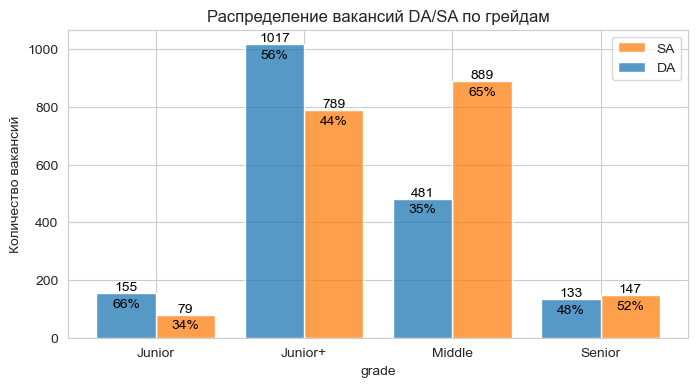

In [77]:
# выведем гистограмму грейдов по категориям DA/SA
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем гистограмму
sns.histplot(data=df, x='grade', hue='source', multiple='dodge',
            shrink=0.8, #ширина отображения столбца в %
            )

# настройки графика
ax.set_title("Распределение вакансий DA/SA по грейдам")
ax.set_ylabel("Количество вакансий")
ax.set_xlabel("grade")
fig.set_figheight(4)
fig.set_figwidth(8)

# добавление меток (с указанием значений над каждым столбцом и процентом)
for p in ax.patches:
#     print(p)
#     print(plt.xticks())
#     print(plt.xticks()[1])
    
    count_in_grade = int(p.get_height()) # значение текущего столбца
    # получаем название текущего грейда
    grade_name = plt.xticks()[1][int((p.get_x()).round(0))].get_text() 
    # получаем общее количество по текущему источнику и грейду
    cnt = df_cnt_grade.loc[df_cnt_grade.grade==grade_name, 'All'].iloc[0]
    percent = count_in_grade/cnt*100 # получаем процентное соотношение
    
    # наносим подписи
    ax.annotate(count_in_grade, (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 2), 
                textcoords='offset points')
    ax.annotate(f'{percent:.0f}%', (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, -10), 
                textcoords='offset points')

# переименовываем легенду
plt.legend(labels=['SA','DA'])
# включаем сетку
plt.grid(True)

plt.show()

* Вакансий для Junior DA на 32% больше, чем для Junior SA (155 против 80).
* Для Junior+ DA вакансий на 12% больше, чем для Junior+ SA (1019 против 790).
* Для Middle DA вакансий на 30% меньше, чем для Middle SA (479 против 888).
* Для Senior DA вакансий на 4% меньше, чем для Senior SA (133 против 147).

**Вывод по подразделу:** <br>
* Количество вакансий для SA превышает количество вакансий для DA на 119 единиц, что составляет 3,22%.
* Для позиций Junior и Junior+ спрос на специалистов DA значительно выше, чем на SA.
* Для специалистов уровня Middle спрос на SA заметно выше, чем на DA.
* Для уровня Senior, с учетом общей разницы в количестве вакансий, спрос на специалистов SA и DA примерно одинаков.
* Наибольший спрос наблюдается на специалистов уровня Junior+ и Middle.
* Небольшое количество вакансий уровня Senior может быть связано с тем, что таких специалистов чаще нанимают через закрытые каналы, а не через публичные объявления.

*Примечание: по данным датасетам [нельзя оценить общую востребованность DA/SA специалистов](#Анализ-распределения-по-датам-публикации)*

#### Определение типичного места работы DA/SA специалистов

##### Работодатели с наибольшим числом вакансий

Оцениваем активность работодателей в найме

Для начало попробуем оценить активность работодателя и среднюю зарплату, которую он предлагает.

In [78]:
# создаем смежную таблицу для Junior DA
# с указанием кол-ва вакансий, кол-во вакансий с указанной зарплатой,
# средняя зарплата
# выводим топ 10 работодателей по кол-ву вакансий
df[flag_da & flag_junior].pivot_table(index='employer', values=['id', 'salary_mean'],
                            aggfunc={'id':'count', 'salary_mean':['mean', 'count']}
                                     ).sort_values(('id', 'count'), ascending=False).head(10)

id salary_mean  \
                                                   count       count   
employer                                                               
СБЕР                                                  14           4   
МАГНИТ, Розничная сеть                                 7           7   
DNS Технологии                                         4           4   
Согласие, страховая компания                           4           0   
ANCOR                                                  3           2   
Ростелеком                                             3           3   
ГБУЗ Владимирской области Медицинский информаци...     3           3   
Юникон АП                                              3           0   
Ростелеком - Центры обработки данных                   2           0   
НАО ИРМАСТ-ХОЛДИНГ                                     2           2   

                                                                  
                                                            mean  
employer                                                          
СБЕР                                                     56500.0  
МАГНИТ, Розничная сеть                              80714.285714  
DNS Технологии                                           66250.0  
Согласие, страховая компания                                <NA>  
ANCOR                                                   142000.0  
Ростелеком                                               35872.0  
ГБУЗ Владимирской области Медицинский информаци...       40000.0  
Юникон АП                                                   <NA>  
Ростелеком - Центры обработки данных                        <NA>  
НАО ИРМАСТ-ХОЛДИНГ                                       90000.0

Из-за небольшой выборки расчет средних зарплат некорректен. Например, у СБЕР указаны зарплаты только для 4 вакансий из 14, и **отображение средней зарплаты может ввести в заблуждение.** <br>
Будем оценивать только активность работодателей исходя из количества размещенных вакансий.<br>
Функция temp_df_cnt для построения df и функция draw_bps для отрисовки графиков описаны в [п.1.2.1](#Определяем-функции)

In [79]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ работодателей', name_2, name_1)
        display(temp_df_cnt(df, flag_1, flag_2, 'employer'))

Топ работодателей Junior DA


,employer,count,percent
0,СБЕР,14,9.03
1,"МАГНИТ, Розничная сеть",7,4.52
2,"Согласие, страховая компания",4,2.58
3,DNS Технологии,4,2.58
4,ANCOR,3,1.94
5,ГБУЗ Владимирской области Медицинский информац...,3,1.94
6,Ростелеком,3,1.94
7,Юникон АП,3,1.94


Топ работодателей Junior+ DA


,employer,count,percent
0,СБЕР,140,13.77
1,Банк ВТБ (ПАО),22,2.16
2,Ozon,17,1.67
3,Центральный банк Российской Федерации,12,1.18
4,Okko,12,1.18


Топ работодателей Middle DA


,employer,count,percent
0,СБЕР,64,13.31
1,WILDBERRIES,28,5.82
2,Т1,20,4.16
3,МТС,14,2.91
4,Яндекс,13,2.70


Топ работодателей Senior DA


,employer,count,percent
0,СБЕР,21,15.79
1,билайн,6,4.51
2,Okko,6,4.51
3,«UZUM TECHNOLOGIES».,4,3.01
4,Ozon,4,3.01
5,"МАГНИТ, Розничная сеть",4,3.01
6,Сравни,4,3.01


Топ работодателей Junior SA


,employer,count,percent
0,Aston,16,20.25
1,Компания Апогей (1С-франчайзи),7,8.86
2,TWIGA Communication Group,5,6.33
3,Дунайс,4,5.06
4,Центр финансовых технологий,3,3.80
5,Ред Софт,3,3.80
6,Т1,3,3.80


Топ работодателей Junior+ SA


,employer,count,percent
0,СБЕР,39,4.94
1,Aston,25,3.17
2,Совкомбанк Технологии,19,2.41
3,"Красное & Белое, розничная сеть",16,2.03
4,Т1,14,1.77


Топ работодателей Middle SA


,employer,count,percent
0,Т1,58,6.52
1,СБЕР,47,5.29
2,Aston,23,2.59
3,ПСБ (ПАО «Промсвязьбанк»),20,2.25
4,Совкомбанк Технологии,17,1.91
5,Т-Банк,17,1.91


Топ работодателей Senior SA


,employer,count,percent
0,СБЕР,7,4.76
1,БФТ-Холдинг (Бюджетные и Финансовые Технологии),5,3.40
2,Sminex,4,2.72
3,Т1,3,2.04
4,билайн,3,2.04
5,Группа компаний Астра,3,2.04


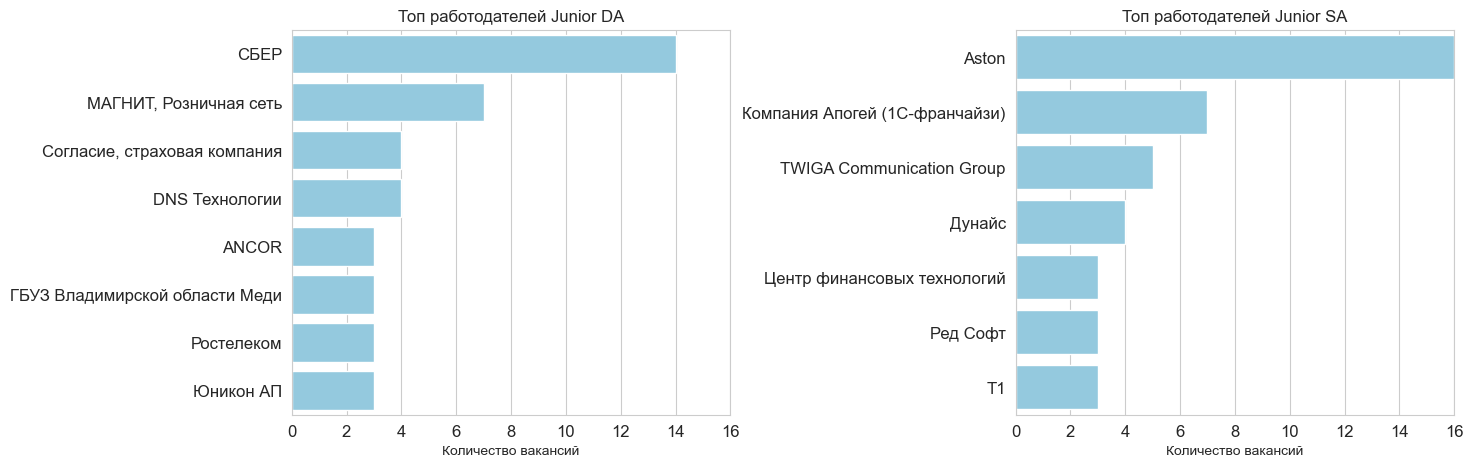

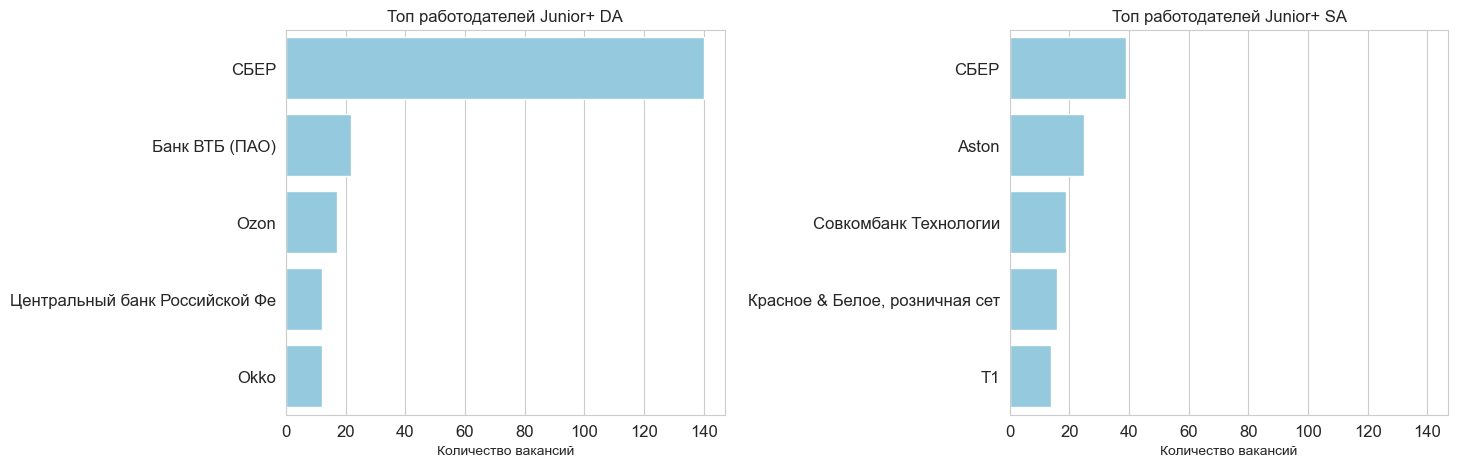

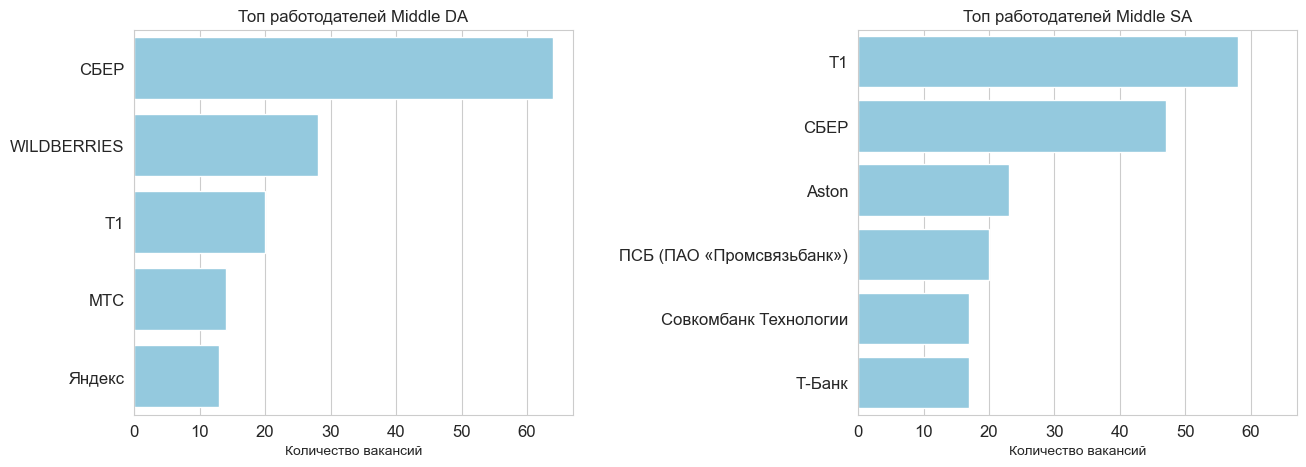

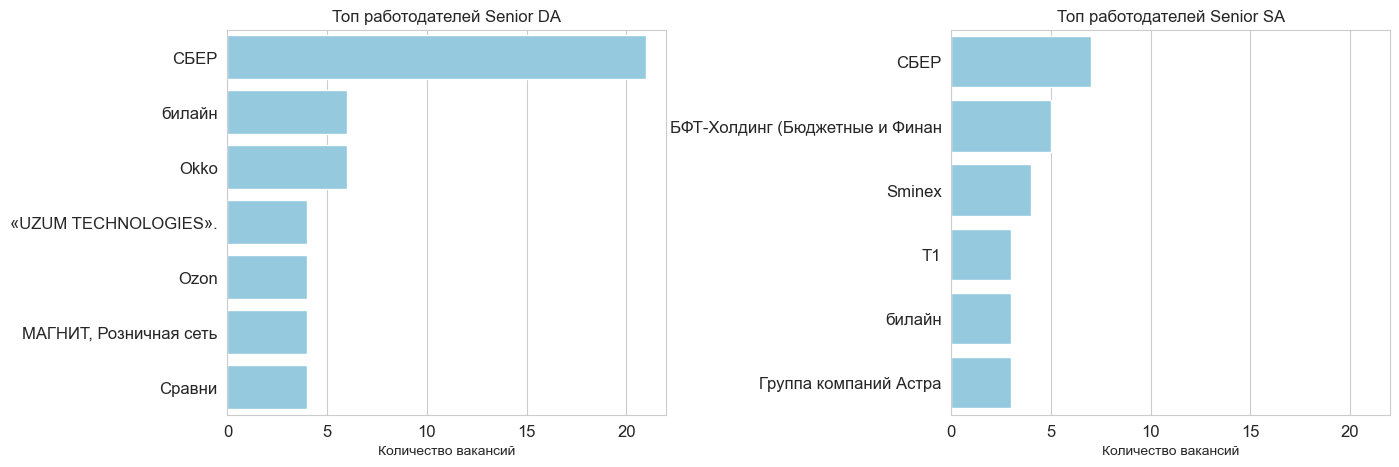

In [80]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'employer', flag_1, name_1, 'Топ работодателей')

In [81]:
# выведем топ работодателей DA без учета грейдов
temp_df_cnt(df, flag_da, None, 'employer')

,employer,count,percent
0,СБЕР,239,13.38
1,WILDBERRIES,42,2.35
2,Ozon,34,1.90
3,Банк ВТБ (ПАО),28,1.57
4,Т1,26,1.46


In [82]:
# выведем топ работодателей SA без учета грейдов
temp_df_cnt(df, flag_sa, None, 'employer')

,employer,count,percent
0,СБЕР,95,4.99
1,Т1,78,4.10
2,Aston,65,3.41
3,Совкомбанк Технологии,37,1.94
4,ПСБ (ПАО «Промсвязьбанк»),30,1.58


* СБЕР является самым активным работодателем для всех грейдов DA (13.38% от всех вакансий).
* Если не учитывать грейды, для DA/SA СБЕР также лидирует по количеству размещенных вакансий.
* Для Junior SA и Middle SA основными работодателями стали Aston и T1 соответственно. Для остальных грейдов SA лидирует СБЕР.
* Для большинства грейдов наблюдается значительный разрыв между первым местом и остальными работодателями. Исключения — Junior+ SA и Senior SA.
* Из-за ограниченного объема данных расчет средних зарплат по работодателям, специализациям и грейдам может быть некорректным и способен привести к ошибочным выводам.

##### Распределение вакансий по городам

In [83]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ городов', name_2, name_1)
        display(temp_df_cnt(df, flag_1, flag_2, 'area'))

Топ городов Junior DA


,area,count,percent
0,Москва,71,45.81
1,Санкт-Петербург,18,11.61
2,Владивосток,11,7.10
3,Нижний Новгород,8,5.16
4,Новосибирск,6,3.87


Топ городов Junior+ DA


,area,count,percent
0,Москва,672,66.08
1,Санкт-Петербург,108,10.62
2,Екатеринбург,32,3.15
3,Новосибирск,20,1.97
4,Нижний Новгород,20,1.97


Топ городов Middle DA


,area,count,percent
0,Москва,380,79.00
1,Санкт-Петербург,44,9.15
2,Казань,10,2.08
3,Екатеринбург,10,2.08
4,Новосибирск,6,1.25


Топ городов Senior DA


,area,count,percent
0,Москва,114,85.71
1,Санкт-Петербург,10,7.52
2,Екатеринбург,4,3.01
3,Самара,2,1.50
4,Новосибирск,1,0.75
5,Кемерово,1,0.75
6,Нижний Новгород,1,0.75


Топ городов Junior SA


,area,count,percent
0,Москва,22,27.85
1,Санкт-Петербург,5,6.33
2,Екатеринбург,5,6.33
3,Новосибирск,4,5.06
4,Красноярск,4,5.06


Топ городов Junior+ SA


,area,count,percent
0,Москва,393,49.81
1,Санкт-Петербург,93,11.79
2,Екатеринбург,33,4.18
3,Новосибирск,30,3.80
4,Казань,28,3.55


Топ городов Middle SA


,area,count,percent
0,Москва,596,67.04
1,Санкт-Петербург,103,11.59
2,Казань,22,2.47
3,Екатеринбург,17,1.91
4,Новосибирск,15,1.69
5,Нижний Новгород,15,1.69


Топ городов Senior SA


,area,count,percent
0,Москва,114,77.55
1,Санкт-Петербург,22,14.97
2,Екатеринбург,4,2.72
3,Ростов-на-Дону,3,2.04
4,Калининград,1,0.68
5,Тюмень,1,0.68
6,Таганрог,1,0.68
7,Самара,1,0.68


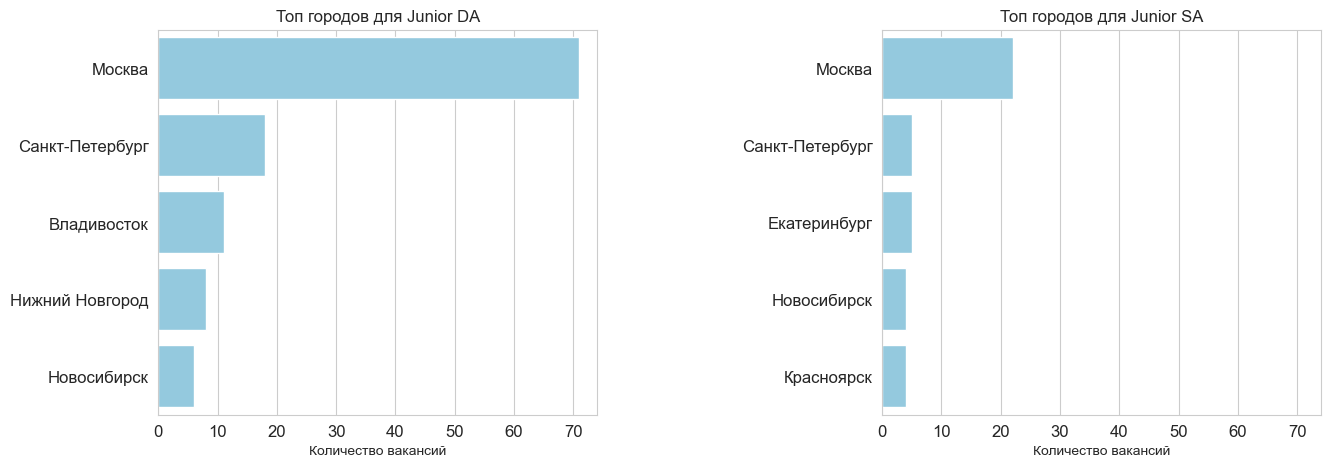

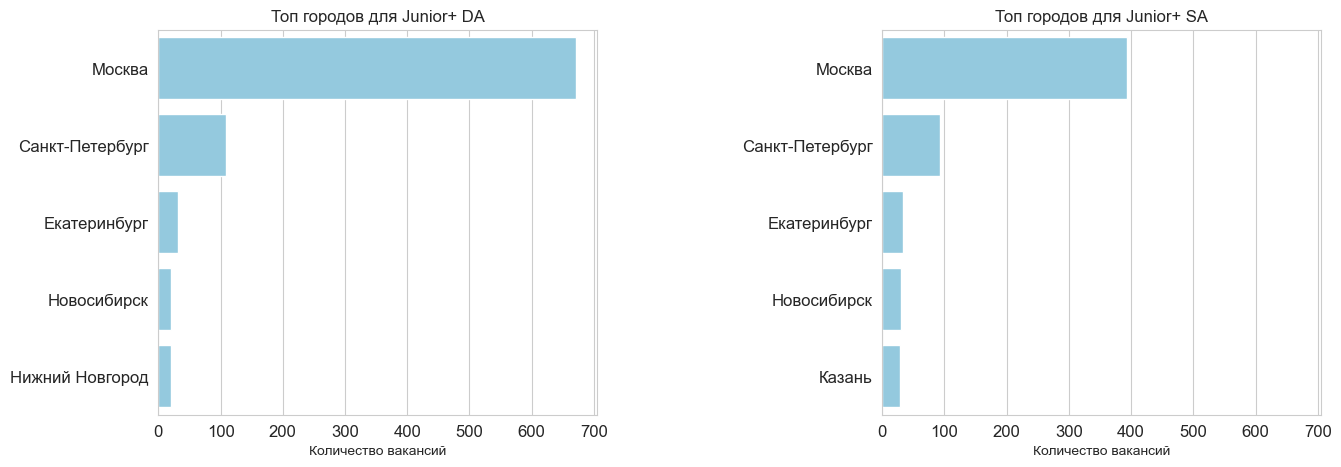

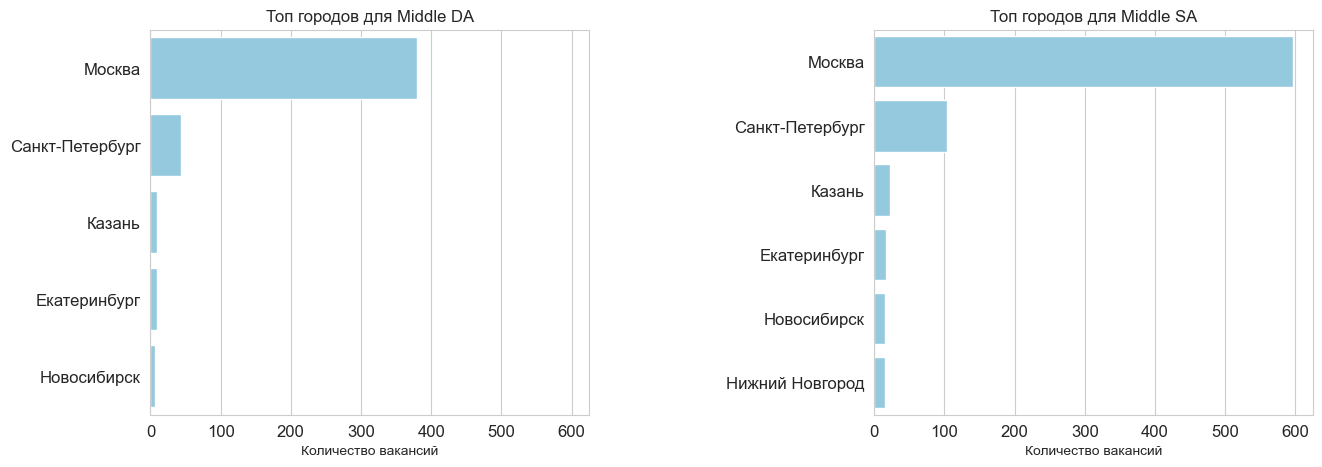

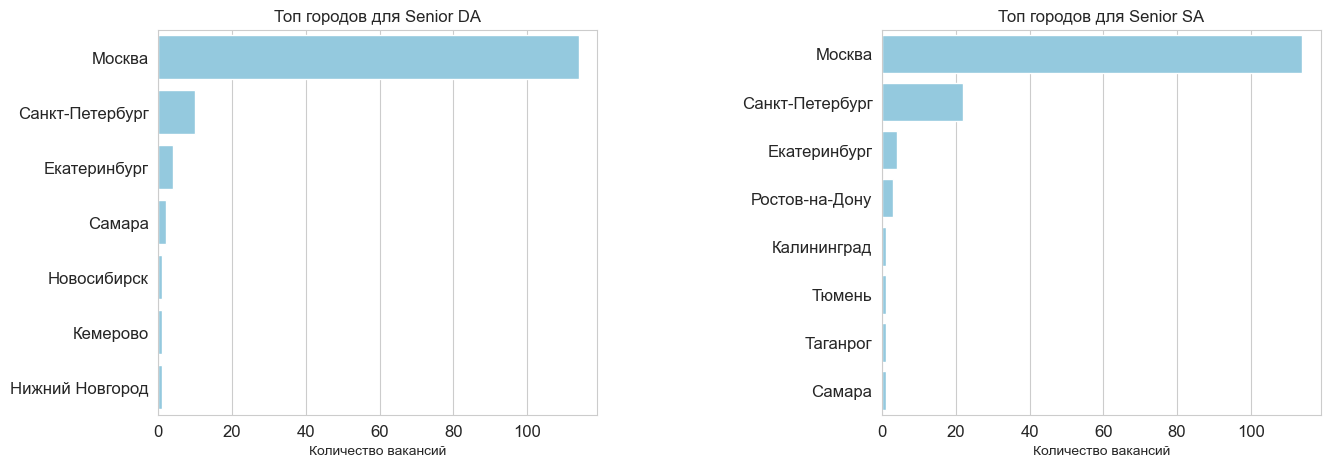

In [84]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'area', flag_1, name_1, 'Топ городов для')

In [85]:
# выведем топ городов для DA без учета грейдов
temp_df_cnt(df, flag_da, None, 'area')

,area,count,percent
0,Москва,1237,69.26
1,Санкт-Петербург,180,10.08
2,Екатеринбург,51,2.86
3,Новосибирск,33,1.85
4,Нижний Новгород,33,1.85


In [86]:
# выведем топ городов для SA без учета грейдов
temp_df_cnt(df, flag_sa, None, 'area')

,area,count,percent
0,Москва,1125,59.09
1,Санкт-Петербург,223,11.71
2,Екатеринбург,59,3.10
3,Казань,51,2.68
4,Новосибирск,49,2.57


* Москва лидирует как основной город трудоустройства для DA и SA специалистов, занимая 69% и 59% всех вакансий соответственно.
* Среди всех грейдов Москва уверенно занимает первое место с существенным отрывом от других городов.
* Санкт-Петербург стабильно находится на втором месте для всех грейдов.
* В топ-5 городов для DA специалистов вошел Новосибирск (1,85%), а для SA специалистов — Казань (2,68%).

##### Распределение зарплат по грейдам для DA/SA

Сначало определимся для какого процента вакансий указаны зарплаты.

In [87]:
temp_df_cnt(df, flag_da, None, 'salary_bin')

,salary_bin,count,percent
0,ЗП не указана,1367,76.54
1,От 50 до 100 т.руб,157,8.79
2,От 100 до 150 т.руб,116,6.49
3,От 150 до 200 т.руб,53,2.97
4,От 200 до 300 т.руб,51,2.86


In [88]:
temp_df_cnt(df, flag_sa, None, 'salary_bin')

,salary_bin,count,percent
0,ЗП не указана,1473,77.36
1,От 200 до 300 т.руб,141,7.41
2,От 150 до 200 т.руб,84,4.41
3,От 50 до 100 т.руб,74,3.89
4,От 100 до 150 т.руб,61,3.20
5,Свыше 300 т.руб,61,3.20


Для обеих специализаций большая часть вакансий не содержит информации о зарплате (76-77%).

Для анализа средних зарплат будем брать средную от среднего (между min/max вакансии) вакансии.

In [89]:
# создадим сводную таблицу с указанием минимальной, максимальной 
# и средней зарплаты по грейдам и источнику
df_temp_salary = df.pivot_table(index='grade', columns='source',
                values=('salary_from', 'salary_to','salary_mean'),
                aggfunc={'salary_from':'min', 'salary_to':'max', 'salary_mean':('mean','count')}
                                                                    ).reset_index()
# переименовываем столбцы
df_temp_salary = df_temp_salary.rename(columns={
    'salary_from':'min_salary', 'salary_to':'max_salary', 'salary_mean':'mean_salary'})
# округляем дробную часть для средней
df_temp_salary['mean_salary'] = df_temp_salary['mean_salary'].round(0)

df_temp_salary

grade min_salary         mean_salary                            \
                       min               count            mean             
source               df_da   df_sa       df_da df_sa     df_da     df_sa   
0        Junior      25000   20000          82    44   63987.0   64195.0   
1       Junior+      40000   40000         257   183  114535.0  142416.0   
2        Middle      40000   80000          73   172  212498.0  245343.0   
3        Senior     150000  150000           7    32  276393.0  324573.0   

       max_salary          
              max          
source      df_da   df_sa  
0          142000  130000  
1          300000  300000  
2          497500  450000  
3          467500  580000

Заметно выделяется минимальная зарплата у Middle DA. Выведем ее для анализа.

In [90]:
df[flag_middle & flag_da & (df.salary_from == 40000)]

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,description,description_lemmatized,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean
1144,97088981,Аналитик данных / BI - аналитик (помощник руко...,2024-05-05 21:29:42,https://hh.ru/vacancy/97088981,Министерство экологии Челябинской области,no_data,Челябинск,Middle,"[аналитическое мышление, базы данных, деловая ...",Полный день,...,помощник руководителя обязан исполнять следующ...,помощник руководитель обязывать исполнять след...,40000,60000,От 50 до 100 т.руб,df_da,no_data,"[базы данных, подготовка отчетов, работа с баз...","[аналитическое мышление, деловая переписка, де...",50000.0


Такая вакансия размещена от ГБУ Челябинской области.

In [91]:
# избавимся от мультииндекса и создадим df с указанием нужной информации
df_temp_salary_mean = (df_temp_salary.set_index('grade')
                            .xs('mean', level=1, axis=1).droplevel(0, axis=1).reset_index())

# преобразуем DataFrame в "длинный" формат
# разделение на df_da/df_sa будет построчно
df_temp_salary_mean = df_temp_salary_mean.melt(id_vars=['grade'], value_vars=['df_da', 'df_sa'],
                  var_name='source', value_name='salary_mean')
# переименовываем источник
df_temp_salary_mean['source'] = df_temp_salary_mean['source'
                                    ].replace({'df_da': 'DA', 'df_sa': 'SA'})

df_temp_salary_mean

,grade,source,salary_mean
0,Junior,DA,63987.0
1,Junior+,DA,114535.0
2,Middle,DA,212498.0
3,Senior,DA,276393.0
4,Junior,SA,64195.0
5,Junior+,SA,142416.0
6,Middle,SA,245343.0
7,Senior,SA,324573.0


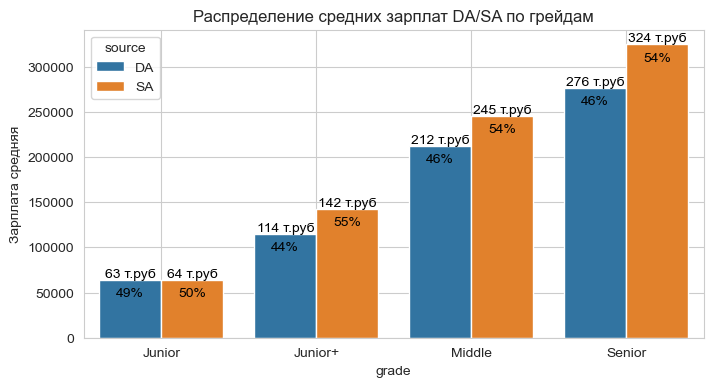

In [92]:
# средние зарплаты отобразим в графическом виде

# выведем столбчатый график распределения зарплат
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.barplot(data=df_temp_salary_mean, x='grade', y='salary_mean', hue='source',
            dodge=True, width=0.8)

# настройки графика
ax.set_title("Распределение средних зарплат DA/SA по грейдам")
ax.set_ylabel("Зарплата средняя")
ax.set_xlabel("grade")
fig.set_figheight(4)
fig.set_figwidth(8)

# добавление меток (с указанием значений над каждым столбцом)
for p in ax.patches[:-2]: # в двух последних значениях '0'
    # print(p)
    count_in_grade = int(p.get_height()/1000) # значение текущего столбца  
    # получаем название текущего грейда
    grade_name = plt.xticks()[1][int((p.get_x()).round(0))].get_text() 
    # получаем общее количество по текущему источнику и грейду
    cnt = df_temp_salary_mean.loc[df_temp_salary_mean.grade==grade_name, 'salary_mean'].sum()
    percent = count_in_grade/cnt*100*1000 # получаем процентное соотношение (перевод в т.руб)
    # наносим подписи
    ax.annotate(f"{count_in_grade} т.руб", (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 2), 
                textcoords='offset points')
    ax.annotate(f'{percent:.0f}%', (p.get_x() + p.get_width()/2, p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, -12), 
                textcoords='offset points')    
    
# включаем сетку
plt.grid(True)

plt.show()

* Минимальные уровни зарплат для специалистов DA и SA совпадают.
* Максимальные зарплаты у специалистов DA немного выше, чем у SA.
* Из-за небольшого объема данных зарплатные показатели для уровня Senior, особенно для Senior DA (всего 7 вакансий с указанием зарплаты), не являются релевантными.
* Средние зарплаты для Junior DA и SA находятся на одинаковом уровне.
* Для остальных уровней средние зарплаты отличаются примерно на 10% в пользу специалистов SA.


##### Распределение по типу занятости и грейду между DA/SA

In [93]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Тип занятости', name_2, name_1)
        display(temp_df_cnt(df, flag_1, flag_2, 'employment'))

Тип занятости Junior DA


,employment,count,percent
0,Полная занятость,136,87.74
1,Стажировка,15,9.68
2,Частичная занятость,3,1.94
3,Проектная работа,1,0.65


Тип занятости Junior+ DA


,employment,count,percent
0,Полная занятость,1003,98.62
1,Частичная занятость,10,0.98
2,Проектная работа,3,0.29
3,Стажировка,1,0.10


Тип занятости Middle DA


,employment,count,percent
0,Полная занятость,477,99.17
1,Частичная занятость,3,0.62
2,Проектная работа,1,0.21


Тип занятости Senior DA


,employment,count,percent
0,Полная занятость,133,100.0


Тип занятости Junior SA


,employment,count,percent
0,Полная занятость,49,62.03
1,Стажировка,29,36.71
2,Частичная занятость,1,1.27


Тип занятости Junior+ SA


,employment,count,percent
0,Полная занятость,787,99.75
1,Частичная занятость,1,0.13
2,Проектная работа,1,0.13


Тип занятости Middle SA


,employment,count,percent
0,Полная занятость,884,99.44
1,Частичная занятость,3,0.34
2,Проектная работа,2,0.22


Тип занятости Senior SA


,employment,count,percent
0,Полная занятость,146,99.32
1,Частичная занятость,1,0.68


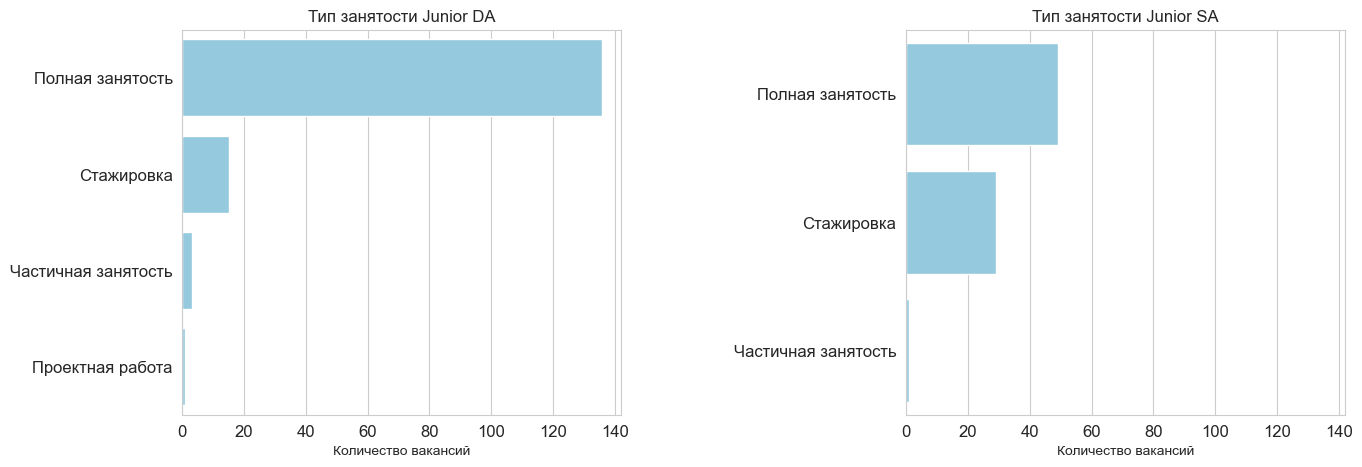

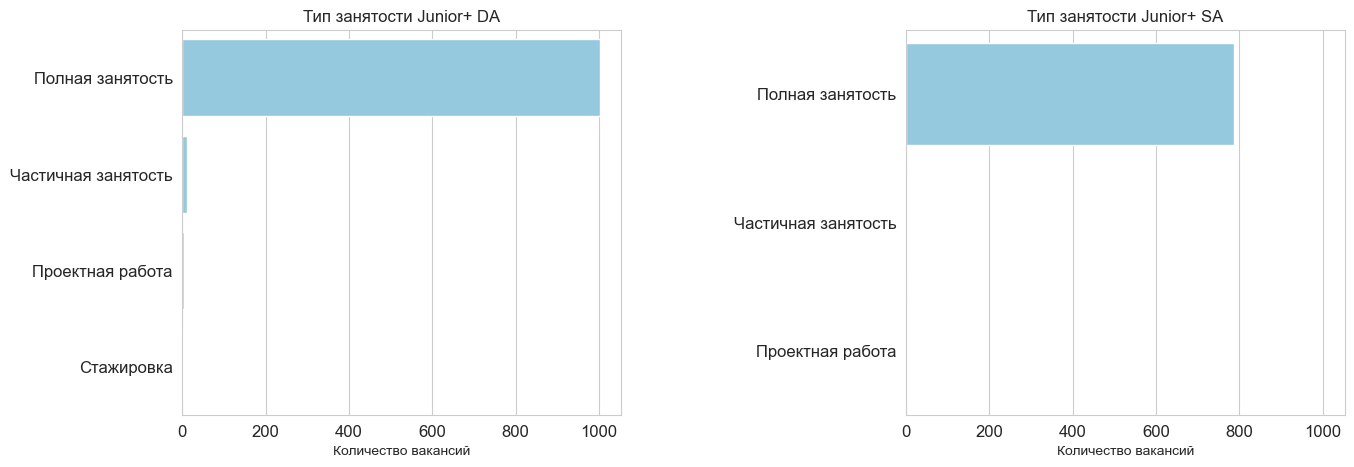

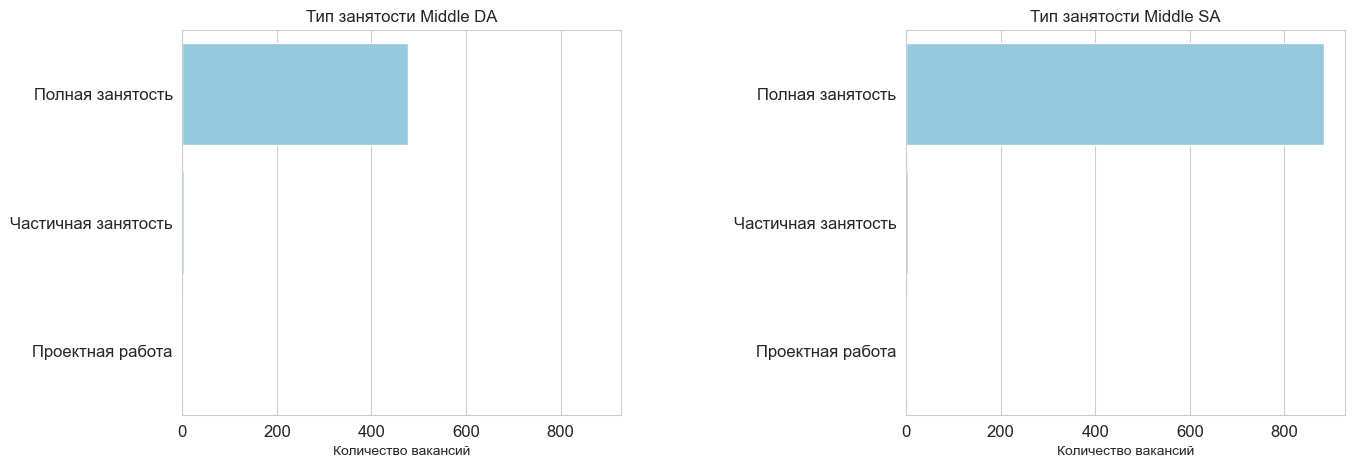

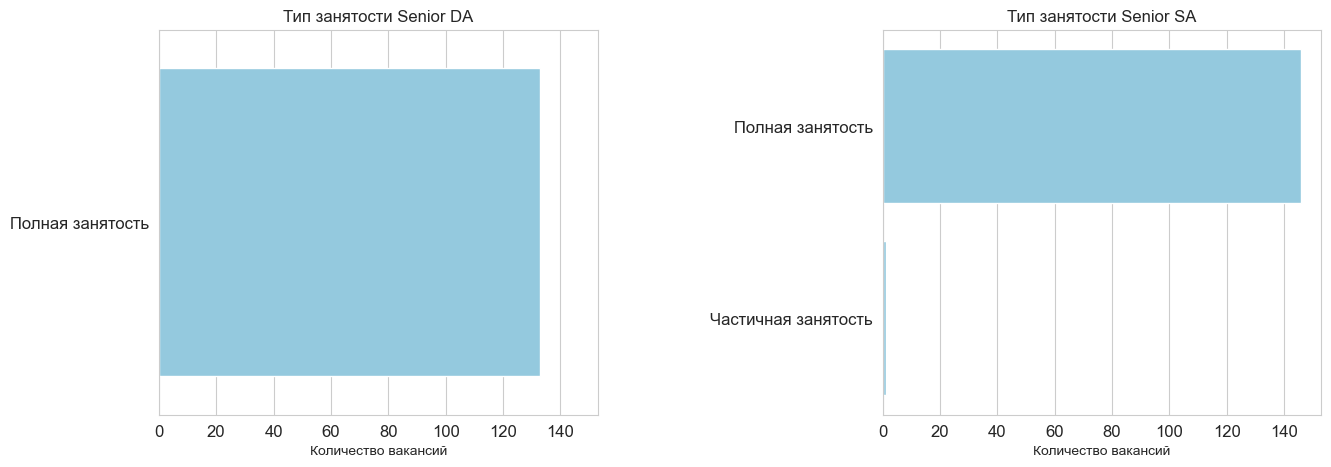

In [94]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'employment', flag_1, name_1, 'Тип занятости')

* Основная доля вакансий предполагает полную занятость.
* Значимый процент вакансий с типом "Стажировка" наблюдается только для позиций Junior DA и SA.

##### Распределение по графику работы и грейду между DA/SA

In [95]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('График работы', name_2, name_1)
        display(temp_df_cnt(df, flag_1, flag_2, 'schedule'))

График работы Junior DA


,schedule,count,percent
0,Полный день,133,85.81
1,Удаленная работа,16,10.32
2,Гибкий график,4,2.58
3,Сменный график,2,1.29


График работы Junior+ DA


,schedule,count,percent
0,Полный день,845,83.09
1,Удаленная работа,148,14.55
2,Гибкий график,17,1.67
3,Сменный график,7,0.69


График работы Middle DA


,schedule,count,percent
0,Полный день,357,74.22
1,Удаленная работа,108,22.45
2,Гибкий график,16,3.33


График работы Senior DA


,schedule,count,percent
0,Полный день,95,71.43
1,Удаленная работа,36,27.07
2,Гибкий график,2,1.50


График работы Junior SA


,schedule,count,percent
0,Полный день,45,56.96
1,Удаленная работа,28,35.44
2,Гибкий график,6,7.59


График работы Junior+ SA


,schedule,count,percent
0,Полный день,526,66.67
1,Удаленная работа,232,29.40
2,Гибкий график,31,3.93


График работы Middle SA


,schedule,count,percent
0,Полный день,524,58.94
1,Удаленная работа,346,38.92
2,Гибкий график,18,2.02
3,Сменный график,1,0.11


График работы Senior SA


,schedule,count,percent
0,Полный день,101,68.71
1,Удаленная работа,41,27.89
2,Гибкий график,5,3.40


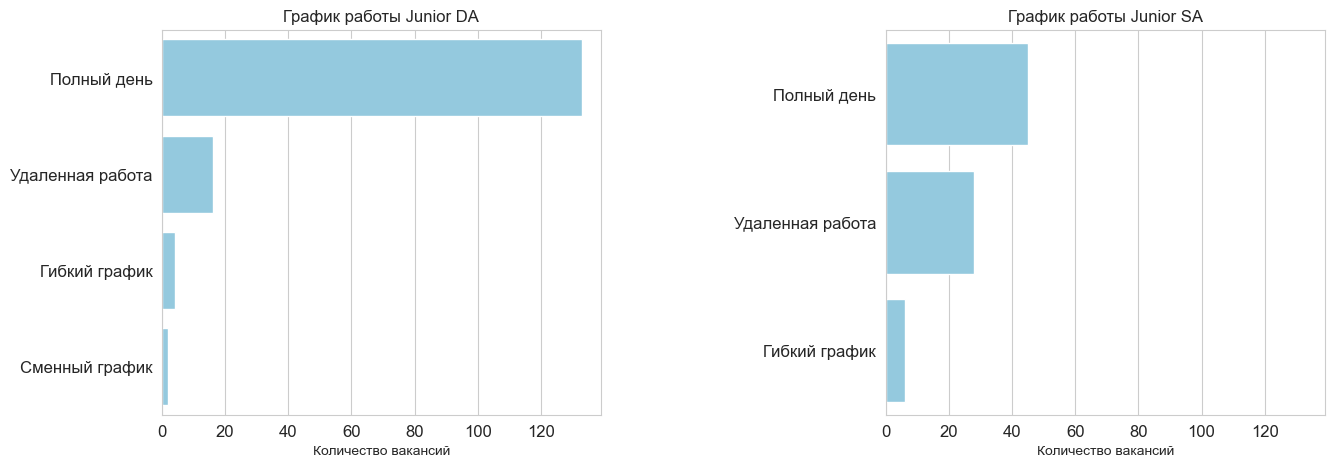

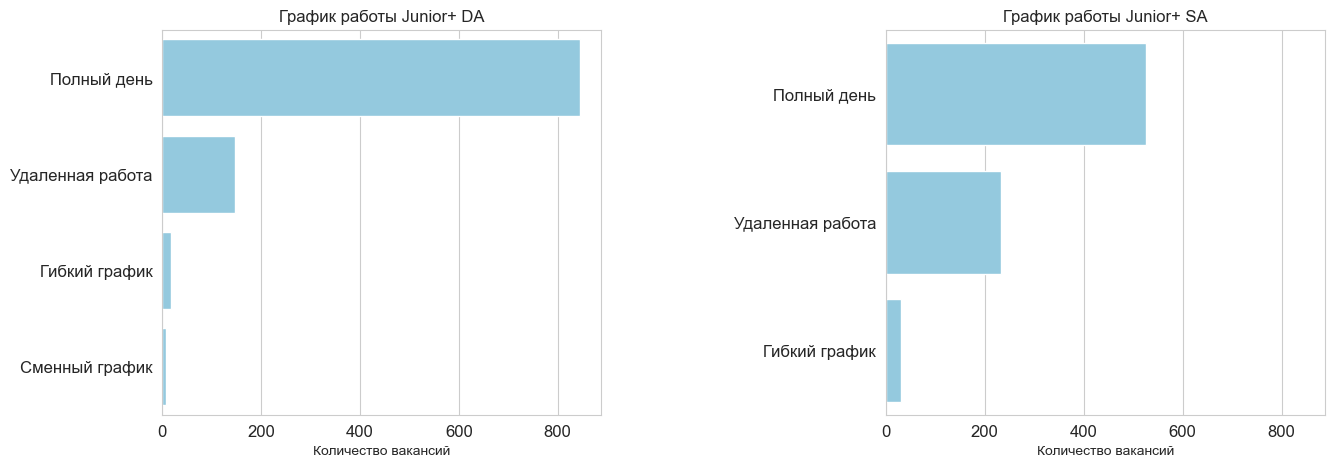

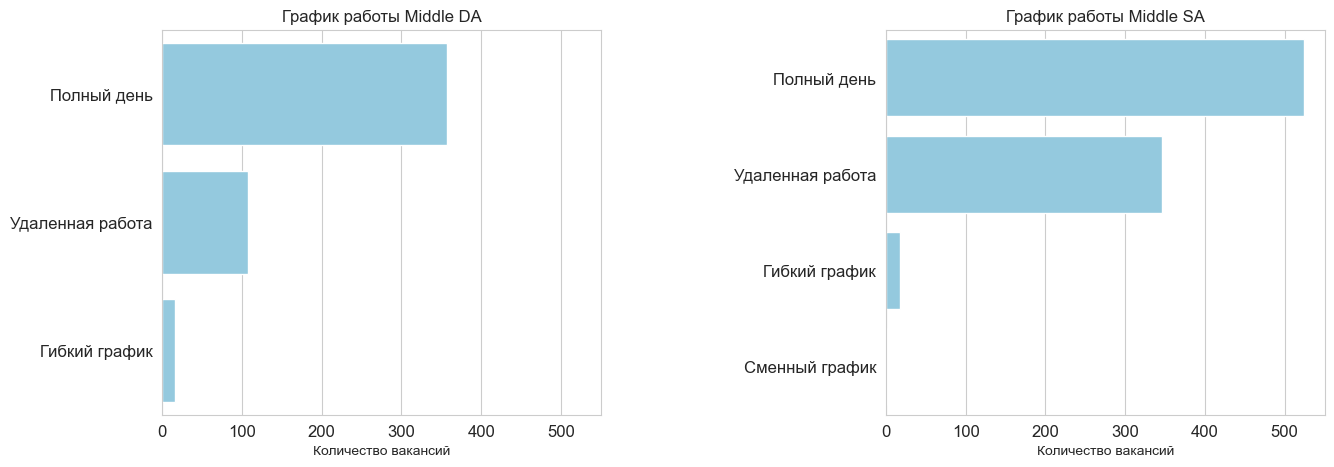

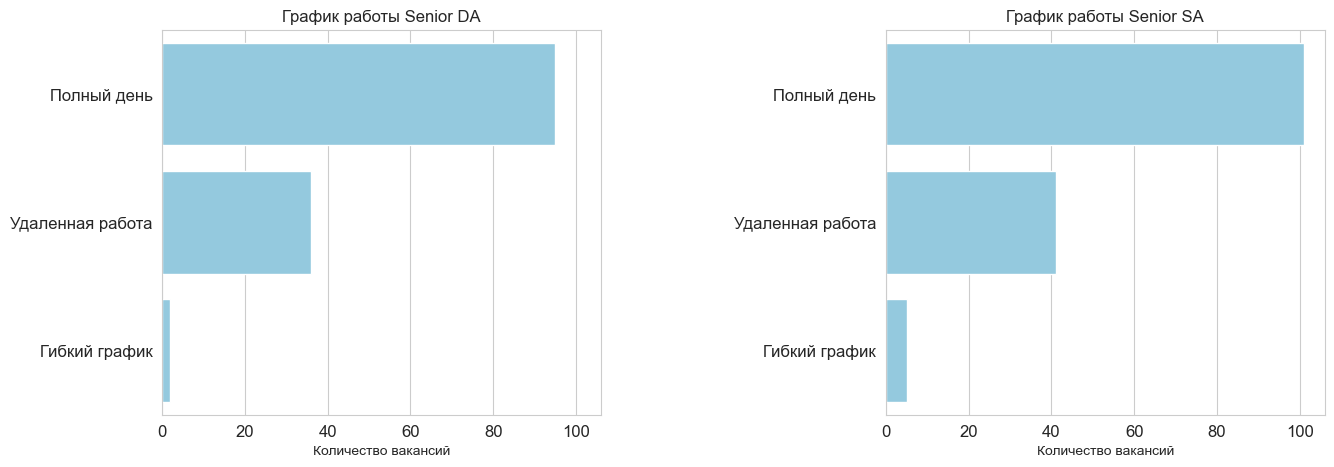

In [96]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'schedule', flag_1, name_1, 'График работы')

In [97]:
# выведем графики работы для DA без учета грейдов
temp_df_cnt(df, flag_da, None, 'schedule')

,schedule,count,percent
0,Полный день,1430,80.07
1,Удаленная работа,308,17.25
2,Гибкий график,39,2.18
3,Сменный график,9,0.50


In [98]:
# выведем графики работы для SA без учета грейдов
temp_df_cnt(df, flag_sa, None, 'schedule')

,schedule,count,percent
0,Полный день,1196,62.82
1,Удаленная работа,647,33.98
2,Гибкий график,60,3.15
3,Сменный график,1,0.05


In [99]:
# создадим сводную таблицу с распределением графиков работы по городам
df_schedule_area = df.pivot_table(index='area', columns=('source', 'schedule'),
                                  values=('id'), aggfunc='count', margins=True)

# оставим только топ5 городов по числу вакансий
df_schedule_area = df_schedule_area.sort_values('All', ascending=False).head(6)

# добавим общее по источникам
df_schedule_area['df_da', 'All_da'] = df_schedule_area['df_da'].sum(axis=1)
df_schedule_area['df_sa', 'All_sa'] = df_schedule_area['df_sa'].sum(axis=1)

# добавим значения в % 
s_l_t = ['df_da', 'df_sa'] #source_list_temp

for source in s_l_t:
    sch_l_t = df_schedule_area[source].columns #schedule_list_temp
    for schedule in sch_l_t:
        df_schedule_area[source, f'{schedule} %'] = (
            df_schedule_area[source, schedule]/df_schedule_area[source, sch_l_t[-1]]
                                                    *100).round(2)

print('Из-за большого кол-ва столбцов DA/SA рассматривается отдельно')

Из-за большого кол-ва столбцов DA/SA рассматривается отдельно


In [100]:
# рассматриваем данные для DA
df_schedule_area['df_da'].sort_index(axis=1)

schedule,All_da,All_da %,Гибкий график,Гибкий график %,Полный день,Полный день %,Сменный график,Сменный график %,Удаленная работа,Удаленная работа %
area,,,,,,,,,,
All,1786.0,100.0,39.0,2.18,1430.0,80.07,9.0,0.50,308.0,17.25
Москва,1237.0,100.0,31.0,2.51,984.0,79.55,5.0,0.40,217.0,17.54
Санкт-Петербург,180.0,100.0,NaN,NaN,145.0,80.56,2.0,1.11,33.0,18.33
Екатеринбург,51.0,100.0,NaN,NaN,42.0,82.35,NaN,NaN,9.0,17.65
Новосибирск,33.0,100.0,2.0,6.06,22.0,66.67,NaN,NaN,9.0,27.27
Казань,29.0,100.0,NaN,NaN,25.0,86.21,NaN,NaN,4.0,13.79


In [101]:
# рассматриваем данные для SA
df_schedule_area['df_sa'].sort_index(axis=1)

schedule,All_sa,All_sa %,Гибкий график,Гибкий график %,Полный день,Полный день %,Сменный график,Сменный график %,Удаленная работа,Удаленная работа %
area,,,,,,,,,,
All,1904.0,100.0,60.0,3.15,1196.0,62.82,1.0,0.05,647.0,33.98
Москва,1125.0,100.0,37.0,3.29,728.0,64.71,1.0,0.09,359.0,31.91
Санкт-Петербург,223.0,100.0,6.0,2.69,133.0,59.64,NaN,NaN,84.0,37.67
Екатеринбург,59.0,100.0,2.0,3.39,34.0,57.63,NaN,NaN,23.0,38.98
Новосибирск,49.0,100.0,2.0,4.08,35.0,71.43,NaN,NaN,12.0,24.49
Казань,51.0,100.0,NaN,NaN,27.0,52.94,NaN,NaN,24.0,47.06


Часть данных не является релевантной из-за недостаточного объема выборки.

* Большинство вакансий предполагают полный рабочий день: 80% для DA и 63% для SA специалистов.
* Удаленный формат работы занимает второе место по популярности. Он более востребован среди SA специалистов: 17% для DA и 34% для SA.
* Гибкий график встречается лишь в 2-3% вакансий.
* Среди Junior SA специалистов наблюдается повышенный спрос на удаленный формат работы.
* В топовых городах заметны различия в популярности удаленной работы между Москвой и Санкт-Петербургом.

##### Типичное место работы DA/SA специалистов:


**Типичное место работы для DA специалиста:**
* **Сфера**: Банковская сфера или маркетплейс
* **Город**: Москва
* **Зарплата**: 
   * Junior ≈ 63 т.руб
   * Junior+ ≈ 114 т.руб
   * Middle ≈ 212 т.руб
   * Senior ≈ 276 т.руб
* **Тип занятости**: Полная занятость
* **График работы**: Полный день (редко удаленная работа)

**Типичное место работы для SA специалиста:**
* **Сфера**: Банковская сфера или консалтинг/аутсорс 
* **Город**: Москва
* **Зарплата**: 
   * Junior ≈ 64 т.руб
   * Junior+ ≈ 142 т.руб
   * Middle ≈ 245 т.руб
   * Senior ≈ 324 т.руб
* **Тип занятости**: Полная занятость
* **График работы**: Полный день (иногда удаленная работа)

В расспределении вакансий DA/SA прослеживаются явные лидеры по всем категориям

#### Анализ требований к навыкам

Определим общее количество hard/soft навыков с разделением DA/SA специальностям.

In [102]:
# посчитаем общее количество вакансий с указанием навыков
# flag_* см. в п.1.2.11

# собираем df с указанием количества заполненных строк для hard/soft навыков
# все строки по DA/SA
df_cnt_h_s = df.pivot_table(index='source', values=('id'
            ), aggfunc='count', margins=True).rename(columns={'id':'All'})

# hard skills по DA/SA
df_cnt_h_s = df_cnt_h_s.join(df[flag_hard].pivot_table(index='source', values=('hard_skills'
            ), aggfunc='count', margins=True))
# soft skills по DA/SA
df_cnt_h_s = df_cnt_h_s.join(df[flag_soft].pivot_table(index='source', values=('soft_skills'
            ), aggfunc='count', margins=True))

# добавляем относительные (от общего) значение
for col in df_cnt_h_s.columns:
    df_cnt_h_s[f'{col} %'] = ((df_cnt_h_s[col] / df_cnt_h_s['All']) * 100).round(2)

df_cnt_h_s.sort_index(axis=1)

,All,All %,hard_skills,hard_skills %,soft_skills,soft_skills %
source,,,,,,
df_da,1786,100.0,1644,92.05,794,44.46
df_sa,1904,100.0,1773,93.12,911,47.85
All,3690,100.0,3417,92.60,1705,46.21


* Для 92-93% всех вакансий указаны требования по hard скиллам.
* Для 44-47% всех вакансий указаны требования по soft скиллам.

Далее разделим их по грейдам

In [103]:
# анологично создаем df с дополнительным разделением по грейдам
df_cnt_skill_grade = df.pivot_table(index=('grade','source'), values=('id'
            ), aggfunc='count', margins=True).rename(columns={'id':'All'})

# hard skills по DA/SA
df_cnt_skill_grade = df_cnt_skill_grade.join(df[flag_hard].pivot_table(
                                        index=('grade','source'), values=('hard_skills'), 
                                            aggfunc='count', margins=True))
# soft skills по DA/SA
df_cnt_skill_grade = df_cnt_skill_grade.join(df[flag_soft].pivot_table(
                                        index=('grade','source'), values=('soft_skills'),
                                                    aggfunc='count', margins=True))

# добавляем относительные (от общего) значение
for col in df_cnt_skill_grade.columns:
    df_cnt_skill_grade[f'{col} %'] = ((df_cnt_skill_grade[col] / 
                                       df_cnt_skill_grade['All']) * 100).round(2)

df_cnt_skill_grade.sort_index(axis=1)

All  All %  hard_skills  hard_skills %  soft_skills  \
grade   source                                                         
Junior  df_da    155  100.0          143          92.26           93   
        df_sa     79  100.0           60          75.95           59   
Junior+ df_da   1017  100.0          928          91.25          472   
        df_sa    789  100.0          730          92.52          411   
Middle  df_da    481  100.0          451          93.76          181   
        df_sa    889  100.0          846          95.16          365   
Senior  df_da    133  100.0          122          91.73           48   
        df_sa    147  100.0          137          93.20           76   
All             3690  100.0         3417          92.60         1705   

                soft_skills %  
grade   source                 
Junior  df_da           60.00  
        df_sa           74.68  
Junior+ df_da           46.41  
        df_sa           52.09  
Middle  df_da           37.63  
        df_sa           41.06  
Senior  df_da           36.09  
        df_sa           51.70  
All                     46.21

In [104]:
# подготавливаем df для графиков
df_cnt_skill_grade = df_cnt_skill_grade.drop('All', level=0).reset_index()
df_cnt_skill_grade['source'] = df_cnt_skill_grade['source'].replace({'df_da': 'DA', 'df_sa': 'SA'}) 

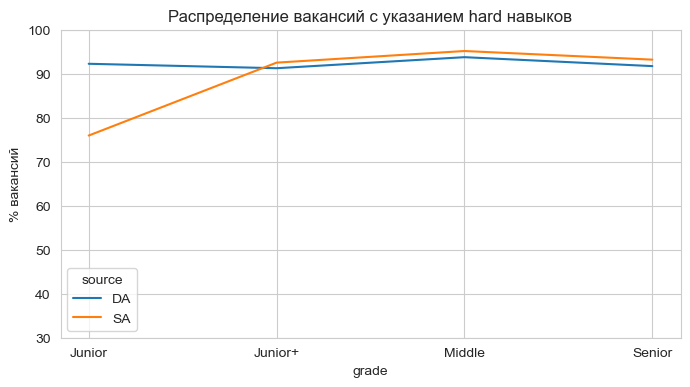

In [105]:
# график наличия требований 

# выведем линейный график наличия требований по скиллам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.lineplot(data=df_cnt_skill_grade, x='grade', y='hard_skills %', hue='source')

# настройки графика
ax.set_title("Распределение вакансий с указанием hard навыков")
ax.set_ylabel("% вакансий")
ax.set_xlabel("grade")
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_ylim(30, 100)  # устанавливаем одинаковую градацию по Y

# включаем сетку
plt.grid(True)

plt.show()

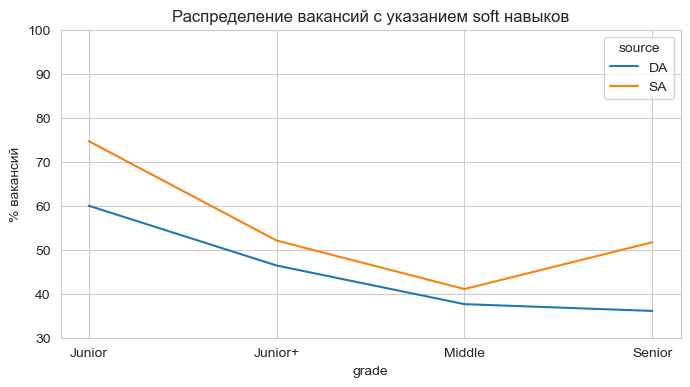

In [106]:
# график наличия требований 

# выведем линейный график наличия требований по скиллам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.lineplot(data=df_cnt_skill_grade, x='grade', y='soft_skills %', hue='source')

# настройки графика
ax.set_title("Распределение вакансий с указанием soft навыков")
ax.set_ylabel("% вакансий")
ax.set_xlabel("grade")
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_ylim(30, 100)  # устанавливаем одинаковую градацию по Y

# включаем сетку
plt.grid(True)

plt.show()

* Наличие требований к hard навыкам распределены равномерно (исключение Junior SA).
* Для Junior SA меньше вакансий с требованиями по hard навыкам (76% при среднем 93%), но больше с требованиями по soft навыкам (75% при среднем 46%).
* Наличие требований к soft навыкам больше к специалистам Junior уровню. 
* Требования к soft навыкам чаще встречаются у SA вакансий, чем к DA.

##### Анализ количества требований

Добавим столбцы с указанием количества требуемых hard/soft навыков

In [107]:
# добавляем кол-во навыков по hard навыкам
df.loc[flag_hard, 'cnt_hard'] = df[flag_hard].hard_skills.transform(len)

# добавляем кол-во навыков по soft навыкам
df.loc[flag_soft, 'cnt_soft'] = df[flag_soft].soft_skills.transform(len)

df.sample(5) # проверка

,id,name,published_at,alternate_url,employer,department,area,grade,key_skills,schedule,...,salary_from,salary_to,salary_bin,source,education_req,hard_skills,soft_skills,salary_mean,cnt_hard,cnt_soft
2246,102600896,System Analyst / Business Analyst,2024-07-09 09:50:22,https://hh.ru/vacancy/102600896,Макс,no_data,Москва,Junior+,"[confluence, коммуникация]",Полный день,...,<NA>,<NA>,ЗП не указана,df_sa,no_data,[confluence],[коммуникация],<NA>,1.0,1.0
3565,98483055,Системный аналитик (AmoCRM),2024-07-01 07:12:30,https://hh.ru/vacancy/98483055,Страна Девелопмент,no_data,Тюмень,Junior+,"[bi, bpmn, crm, draw.io, json, kafka, plantuml...",Удаленная работа,...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[bi, bpmn, crm, draw.io, json, kafka, plantuml...",no_data,<NA>,12.0,NaN
2804,103270973,Системный аналитик,2024-07-04 10:03:37,https://hh.ru/vacancy/103270973,Газпромбанк,Газпромбанк,Москва,Junior+,"[excel, sql, многозадачность]",Полный день,...,<NA>,<NA>,ЗП не указана,df_sa,no_data,"[excel, sql]",[многозадачность],<NA>,2.0,1.0
1403,98081879,Аналитик данных,2024-04-27 15:40:01,https://hh.ru/vacancy/98081879,СБЕР,Сбер для экспертов,Екатеринбург,Junior+,[confluence],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,no_data,[confluence],no_data,<NA>,1.0,NaN
663,94827220,Data Analyst,2024-03-15 13:54:00,https://hh.ru/vacancy/94827220,СБЕР,Сбер для экспертов,Санкт-Петербург,Junior+,[креативность],Полный день,...,<NA>,<NA>,ЗП не указана,df_da,высокий бухгалтерия экономика образование,no_data,[креативность],<NA>,NaN,1.0


In [108]:
# создаем df с колличеством требований по навыкам
# и средним количеством требований к вакансии
df_cnt_skills = df.pivot_table(index='source', values=('cnt_hard', 'cnt_soft'), 
                   aggfunc=['sum', 'mean'], margins=True)

# округлим средние значения
df_cnt_skills['mean'] = df_cnt_skills['mean'].round(2)

df_cnt_skills

sum              mean         
       cnt_hard cnt_soft cnt_hard cnt_soft
source                                    
df_da    7845.0   1218.0     4.77     1.53
df_sa   10258.0   1462.0     5.79     1.60
All      8799.0   2345.0     6.04     1.61

* Количество навыков, как hard так и soft, требуеют больше для SA специалистов, чем для DA.
<br><br>
Гипотеза: разница между количеством hard навыков и soft объясняется меньшим общим количеством soft навыков. Для проверки составим множества hard и soft навыков из df_skill (df получен из файла после обработки множества всех навыков [в п.1.2.5.2](#замена-в-hard_skills_from_description-/-soft_skills_from_description) 

In [109]:
print('Количество уникальных hard навыков:', df_skill[df_skill.hard].shape[0])
print('Количество уникальных soft навыков:', df_skill[df_skill.soft].shape[0])

Количество уникальных hard навыков: 258
Количество уникальных soft навыков: 53


soft навыков в 5 раз меньше, чем hard. Это может быть связана с унифицированностью soft навыков. Гипотеза потверждена. 

Далее разделяем количество требований навыков по грейдам.

In [110]:
# создаем df с дополнительным разделением по грейдам
df_cnt_skills_grade = df.pivot_table(index=('grade','source'), values=('cnt_hard', 'cnt_soft'), 
                   aggfunc=['sum', 'mean'], margins=True)

df_cnt_skills_grade

sum               mean          
               cnt_hard cnt_soft  cnt_hard  cnt_soft
grade   source                                      
Junior  df_da     519.0    157.0  3.629371  1.688172
        df_sa     517.0    175.0  8.616667  2.966102
Junior+ df_da    4308.0    688.0  4.642241  1.457627
        df_sa    4181.0    650.0  5.727397  1.581509
Middle  df_da    2399.0    295.0  5.319290  1.629834
        df_sa    4770.0    531.0  5.638298  1.454795
Senior  df_da     619.0     78.0  5.073770  1.625000
        df_sa     790.0    106.0  5.766423  1.394737
All              8799.0   2345.0  6.043269  1.610577

In [111]:
# подготавливаем df для графиков
# переименование выполняем через set_axis по порядку 
# (rename с мультииндексом запустить не получилось)
df_cnt_skills_grade = df_cnt_skills_grade.drop('All', level=0).set_axis(
        ['cnt_hard', 'cnt_soft', 'mean_hard', 'mean_soft'], axis=1).reset_index()

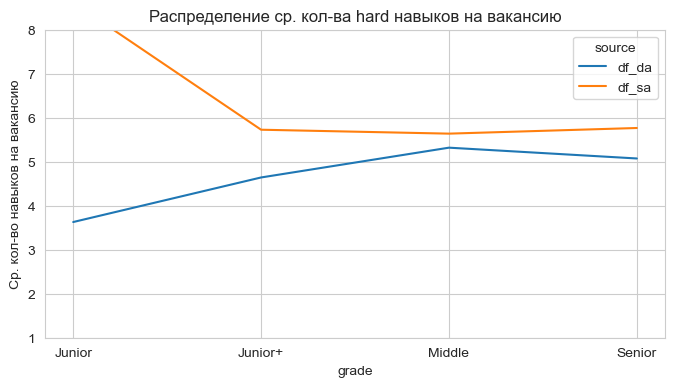

In [112]:
# график среднего количества требований 

# выведем линейный график ср. количества требований по навыкам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.lineplot(data=df_cnt_skills_grade, x='grade', y='mean_hard', hue='source')

# настройки графика
ax.set_title("Распределение ср. кол-ва hard навыков на вакансию")
ax.set_ylabel("Ср. кол-во навыков на вакансию")
ax.set_xlabel("grade") 
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_ylim(1, 8)  # устанавливаем одинаковую градацию по Y

# включаем сетку
plt.grid(True)

plt.show()

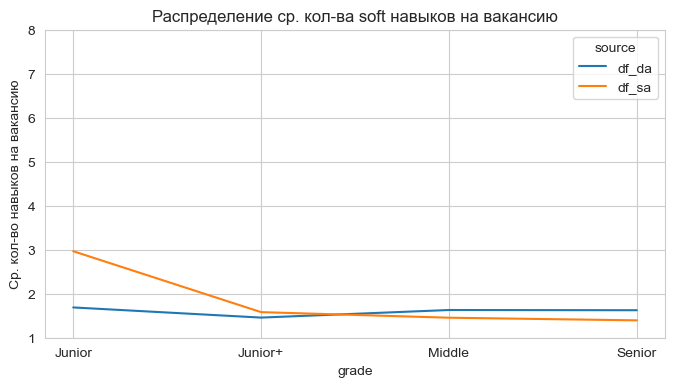

In [113]:
# график среднего количества требований 

# выведем линейный график ср. количества требований по навыкам
sns.set_style("whitegrid")
fig, ax = plt.subplots()

# создаем график
sns.lineplot(data=df_cnt_skills_grade, x='grade', y='mean_soft', hue='source')

# настройки графика
ax.set_title("Распределение ср. кол-ва soft навыков на вакансию")
ax.set_ylabel("Ср. кол-во навыков на вакансию")
ax.set_xlabel("grade") 
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_ylim(1, 8)  # устанавливаем одинаковую градацию по Y

# включаем сетку
plt.grid(True)

plt.show()

* Hard-навыки: SA специалисты сталкиваются с более высокими требованиями, особенно на уровне Junior.
* Soft-навыки: Junior SA специалисты должны обладать большим набором soft-навыков, однако для Middle и Senior специалистов требования к DA выше, чем к SA. <br> <br>
* Динамика требований:
    * У SA специалистов количество требуемых hard/soft-навыков снижается с ростом грейда.
    * У DA специалистов, напротив, количество требуемых навыков увеличивается с повышением грейда.


**Вывод по подразделу:**
* В среднем требования по всем навыком больше к SA специалистам.
* Только количество soft навыков middle/senior DA чуть опережают аналогичные уровни SA.
* Существенная разница в требованиях DA/SA наблюдается только на уровне Junior

#### Анализ самых важных навыков

##### Анализ важных hard навыков 

In [114]:
# выведем топ 10 всех hard навыков
hard_skills = df.hard_skills.explode()
hard_skills = hard_skills.value_counts().reset_index()
hard_skills.head(10)

,hard_skills,count
0,sql,1972
1,python,868
2,confluence,832
3,bpmn,768
4,uml,718
5,системный анализ,575
6,rest,490
7,excel,432
8,power bi,339
9,pandas,330


In [115]:
# выведем топ hard навыков для DA без учета грейдов
temp_df_cnt(df, flag_da, flag_hard, 'hard_skills', min_val=10)

,hard_skills,count,percent
0,sql,1120,68.13
1,python,809,49.21
2,excel,390,23.72
3,power bi,329,20.01
4,pandas,327,19.89
5,работа с базами данных,196,11.92
6,работа с большим объемом информации,183,11.13
7,ms sql,166,10.10
8,bi,144,8.76
9,базы данных,133,8.09


In [116]:
# выведем топ hard навыков для SA без учета грейдов
temp_df_cnt(df, flag_sa, flag_hard, 'hard_skills', min_val=10)

,hard_skills,count,percent
0,sql,852,48.05
1,bpmn,745,42.02
2,confluence,707,39.88
3,uml,704,39.71
4,системный анализ,564,31.81
5,rest,486,27.41
6,soap,327,18.44
7,xml,275,15.51
8,разработка технических заданий,254,14.33
9,api,250,14.10


In [117]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ hard навыков', name_2, name_1)
        display(temp_df_cnt(df, flag_1, (flag_2 & flag_hard), 'hard_skills'))

Топ hard навыков Junior DA


,hard_skills,count,percent
0,sql,66,46.15
1,excel,66,46.15
2,python,46,32.17
3,pandas,21,14.69
4,работа с большим объемом информации,20,13.99


Топ hard навыков Junior+ DA


,hard_skills,count,percent
0,sql,632,68.10
1,python,418,45.04
2,excel,252,27.16
3,power bi,202,21.77
4,pandas,166,17.89


Топ hard навыков Middle DA


,hard_skills,count,percent
0,sql,316,70.07
1,python,256,56.76
2,pandas,115,25.50
3,power bi,88,19.51
4,excel,60,13.30


Топ hard навыков Senior DA


,hard_skills,count,percent
0,sql,106,86.89
1,python,89,72.95
2,pandas,25,20.49
3,power bi,22,18.03
4,а/в-тестирования,21,17.21


Топ hard навыков Junior SA


,hard_skills,count,percent
0,sql,34,56.67
1,системный анализ,26,43.33
2,uml,25,41.67
3,bpmn,24,40.00
4,бизнес-анализ,22,36.67


Топ hard навыков Junior+ SA


,hard_skills,count,percent
0,sql,326,44.66
1,bpmn,295,40.41
2,confluence,282,38.63
3,uml,265,36.30
4,системный анализ,206,28.22


Топ hard навыков Middle SA


,hard_skills,count,percent
0,sql,423,50.00
1,bpmn,365,43.14
2,uml,347,41.02
3,confluence,346,40.90
4,системный анализ,283,33.45


Топ hard навыков Senior SA


,hard_skills,count,percent
0,sql,69,50.36
1,uml,67,48.91
2,confluence,65,47.45
3,bpmn,61,44.53
4,rest,49,35.77
5,системный анализ,49,35.77


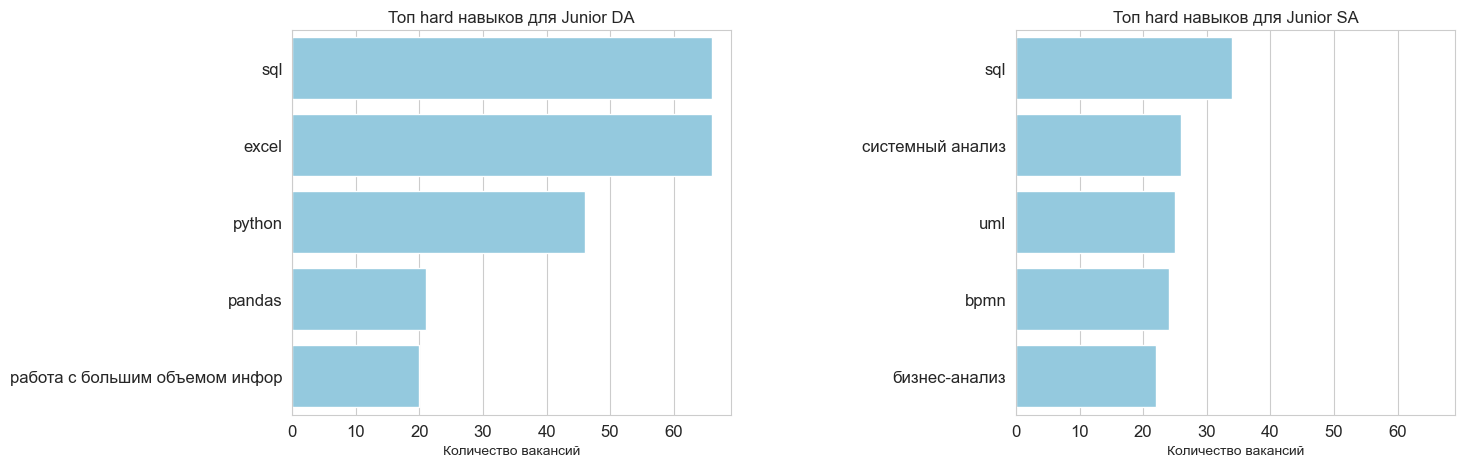

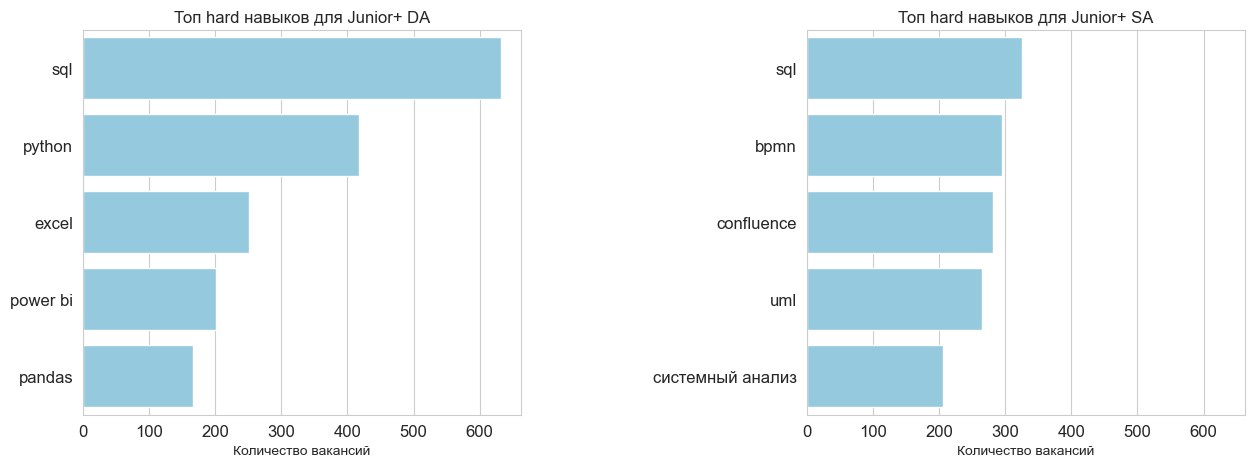

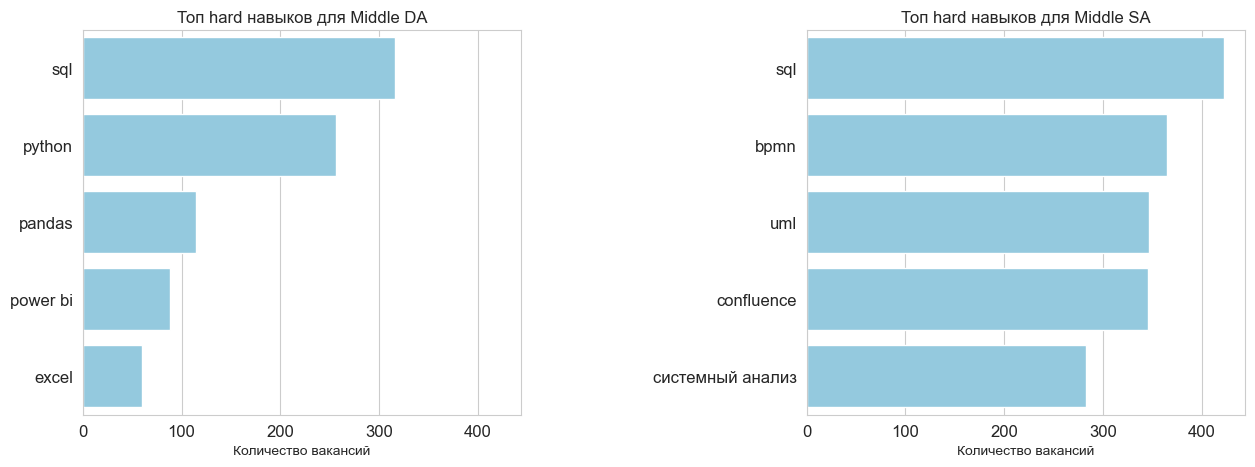

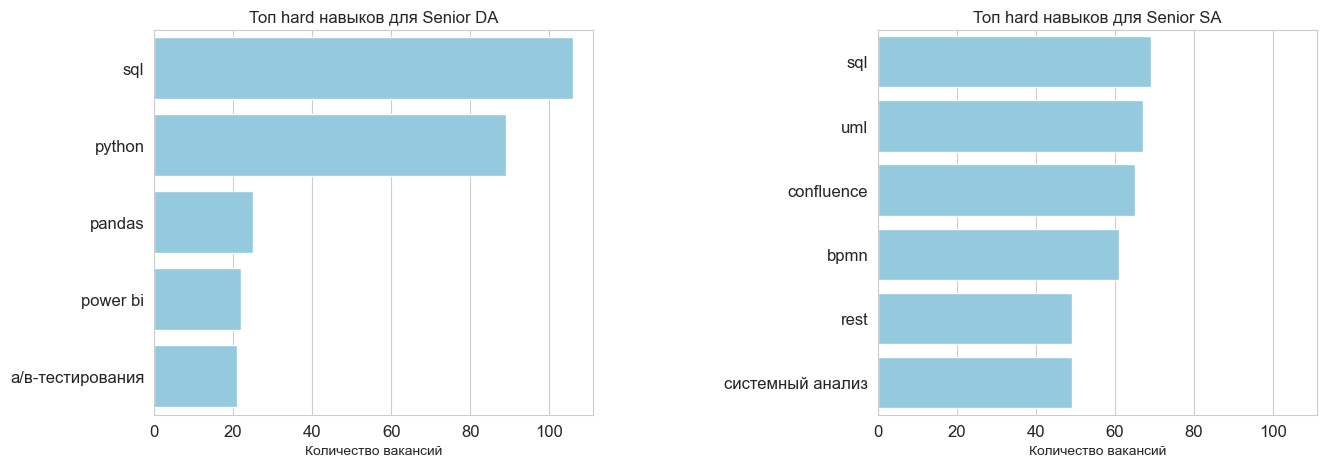

In [118]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'hard_skills', (flag_1 & flag_hard), name_1, 'Топ hard навыков для')

* Самый востребованный навык для DA/SA специалистов (без учета грейдов) — SQL.
* Для DA специалистов:
    * Junior: SQL и Excel встречаются одинаково часто, на третьем месте — Python.
    * Junior+: SQL на первом месте, Python на втором, Excel на третьем.
    * Middle: SQL на первом месте, Python на втором, Pandas на третьем.
    * Senior: SQL на первом месте, Python на втором, Pandas на третьем.
* Для SA специалистов:
    * Junior: SQL на первом месте, системный анализ на втором, UML на третьем.
    * Junior+: SQL на первом месте, BPMN на втором, Confluence на третьем.
    * Middle: SQL на первом месте, BPMN на втором, UML на третьем.
    * Senior: SQL на первом месте, UML на втором, Confluence на третьем.
* Особенность для SA: Нет значительного разрыва в востребованности навыков, распределение в топ-5 довольно равномерное.


##### Анализ важных soft навыков

In [119]:
# выведем топ 10 всех soft навыков
soft_skills = df[flag_soft].soft_skills.explode()
soft_skills = soft_skills.value_counts().reset_index()
soft_skills.head(10)

,soft_skills,count
0,аналитическое мышление,666
1,коммуникация,458
2,agile,147
3,scrum,108
4,проактивность,101
5,английский язык,94
6,ответственность,84
7,работа в команде,72
8,системное мышление,66
9,подготовка презентаций,54


In [120]:
# выведем топ soft навыков для DA без учета грейдов
temp_df_cnt(df, flag_da, flag_soft, 'soft_skills', min_val=10)

,soft_skills,count,percent
0,аналитическое мышление,371,46.73
1,коммуникация,179,22.54
2,английский язык,55,6.93
3,проактивность,51,6.42
4,ответственность,46,5.79
5,подготовка презентаций,41,5.16
6,навыки презентации,41,5.16
7,работа в команде,33,4.16
8,agile,32,4.03
9,деловая коммуникация,25,3.15


In [121]:
# выведем топ soft навыков для SA без учета грейдов
temp_df_cnt(df, flag_sa, flag_soft, 'soft_skills', min_val=10)

,soft_skills,count,percent
0,аналитическое мышление,295,32.38
1,коммуникация,279,30.63
2,agile,115,12.62
3,scrum,101,11.09
4,проактивность,50,5.49
5,системное мышление,49,5.38
6,agile project management,44,4.83
7,английский язык,39,4.28
8,работа в команде,39,4.28
9,переговоры,38,4.17


In [122]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ soft навыков', name_2, name_1)
        display(temp_df_cnt(df, flag_1, (flag_2 & flag_soft), 'soft_skills'))

Топ soft навыков Junior DA


,soft_skills,count,percent
0,аналитическое мышление,49,52.69
1,коммуникация,17,18.28
2,ответственность,13,13.98
3,работа в команде,11,11.83
4,английский язык,7,7.53


Топ soft навыков Junior+ DA


,soft_skills,count,percent
0,аналитическое мышление,231,48.94
1,коммуникация,101,21.40
2,английский язык,31,6.57
3,навыки презентации,26,5.51
4,проактивность,26,5.51


Топ soft навыков Middle DA


,soft_skills,count,percent
0,аналитическое мышление,80,44.20
1,коммуникация,44,24.31
2,подготовка презентаций,14,7.73
3,проактивность,14,7.73
4,английский язык,13,7.18


Топ soft навыков Senior DA


,soft_skills,count,percent
0,коммуникация,17,35.42
1,аналитическое мышление,11,22.92
2,навыки презентации,9,18.75
3,управление командой,5,10.42
4,проактивность,5,10.42


Топ soft навыков Junior SA


,soft_skills,count,percent
0,аналитическое мышление,47,79.66
1,аналитический склад ума,18,30.51
2,agile,10,16.95
3,scrum,10,16.95
4,business analysis,9,15.25
5,waterfall,9,15.25
6,обучение и развитие,9,15.25


Топ soft навыков Junior+ SA


,soft_skills,count,percent
0,аналитическое мышление,148,36.01
1,коммуникация,115,27.98
2,scrum,44,10.71
3,agile,37,9.00
4,agile project management,30,7.30


Топ soft навыков Middle SA


,soft_skills,count,percent
0,коммуникация,126,34.52
1,аналитическое мышление,87,23.84
2,agile,60,16.44
3,scrum,39,10.68
4,проактивность,25,6.85


Топ soft навыков Senior SA


,soft_skills,count,percent
0,коммуникация,32,42.11
1,аналитическое мышление,13,17.11
2,agile,8,10.53
3,scrum,8,10.53
4,business analysis,4,5.26
5,системное мышление,4,5.26
6,английский язык,4,5.26


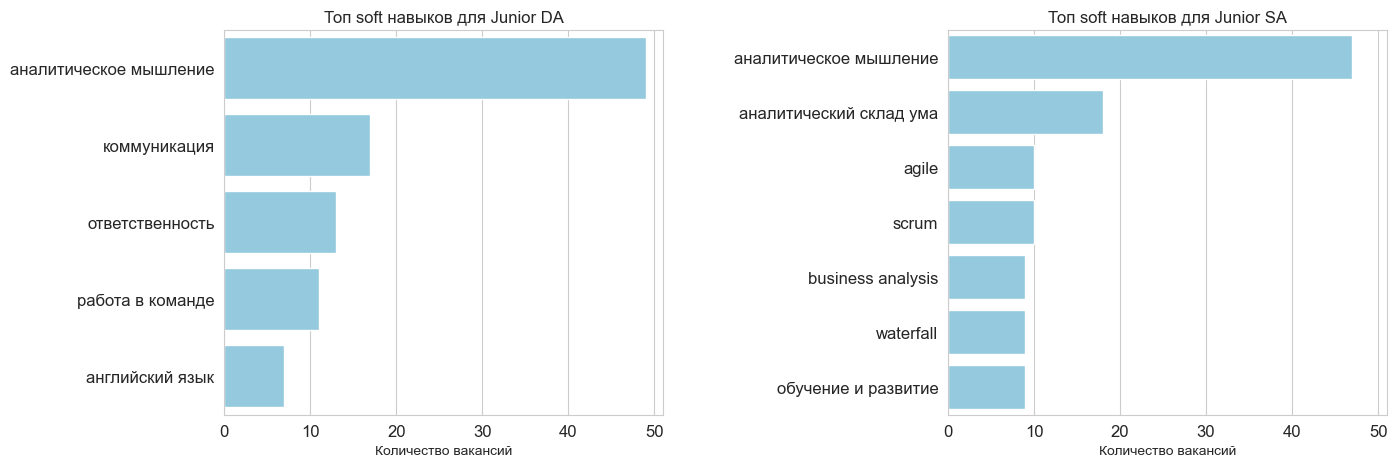

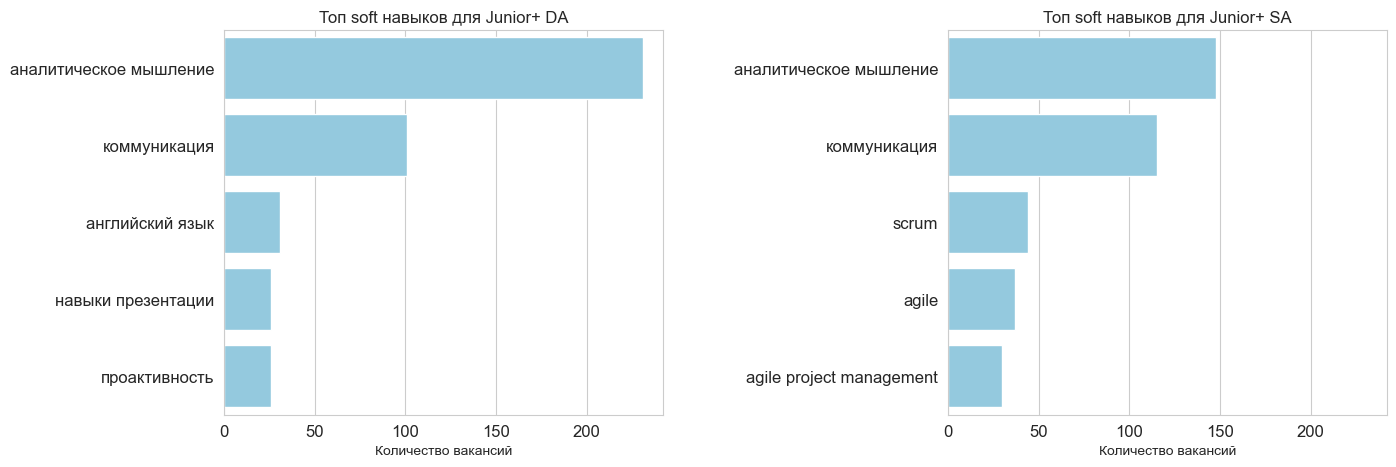

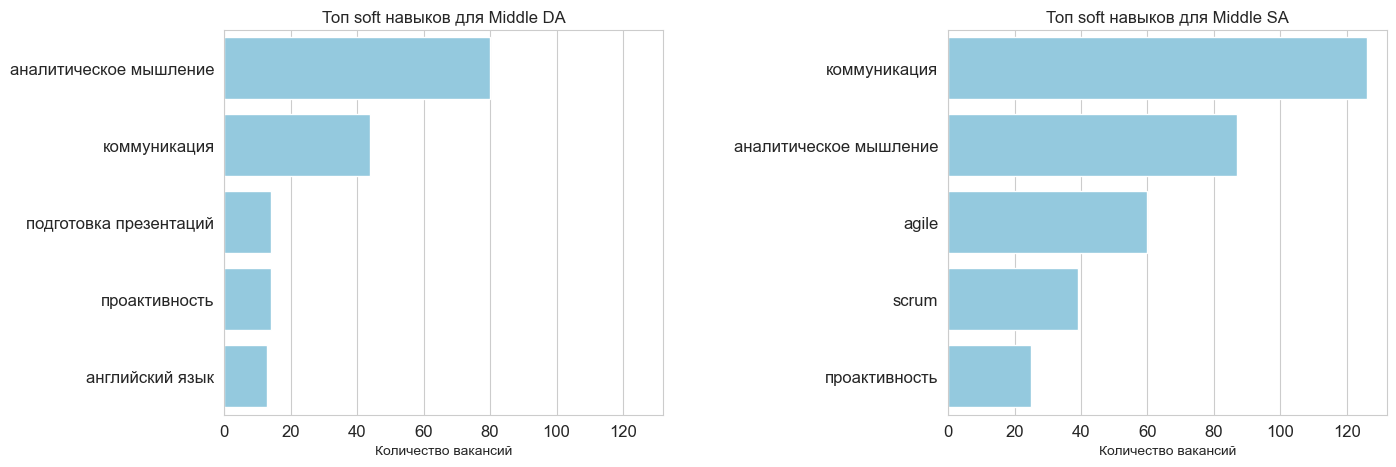

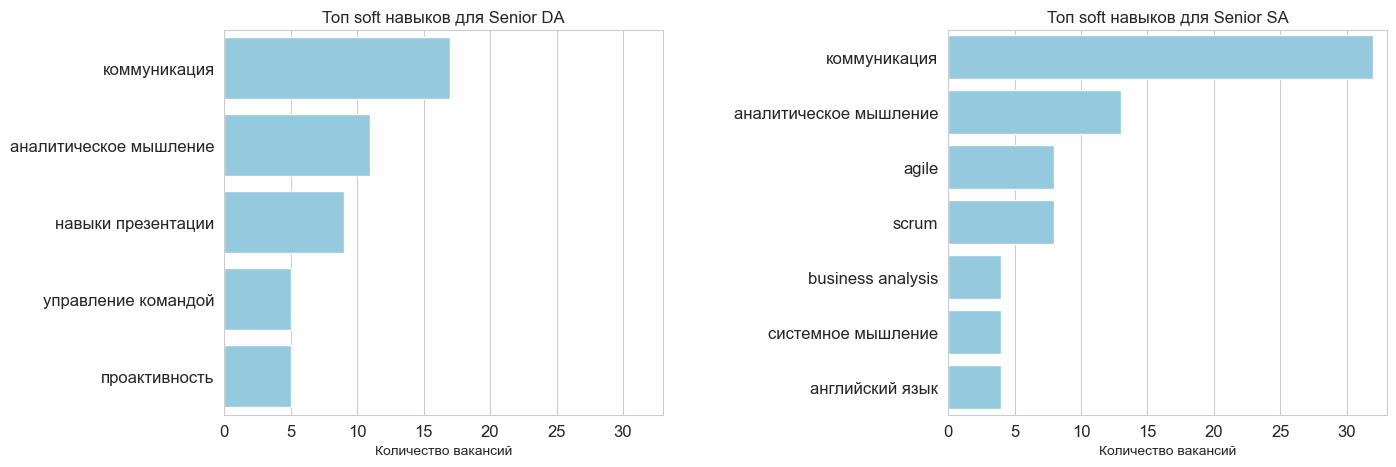

In [123]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'soft_skills', (flag_1 & flag_soft), name_1, 'Топ soft навыков для')

* Самый востребованный навык для DA/SA специалистов (без учета грейдов) — аналитическое мышление.

* Для DA:
	* Junior: на первом месте аналитическое мышление, на втором коммуникация, на третьем ответственность.
	* Junior+: на первом месте аналитическое мышление, на втором коммуникация, на третьем английский язык.
	* Middle: на первом месте аналитическое мышление, на втором коммуникация, на третьем подготовка презентаций.
	* Senior: на первом коммуникация, на втором аналитическое мышление, на третьем навыки презентации.
* Для SA:
	* Junior: на первом месте аналитическое мышление, на втором аналитический склад ума, на третьем и четвертом agile/scrum.
	* Junior+: на первом месте аналитическое мышление, на втором коммуникация, на третьем и четвертом scrum/agile.
	* Middle: на первом коммуникация, на втором аналитическое мышление, на третьем и четвертом agile/scrum.
	* Senior: на первом коммуникация, на втором аналитическое мышление, на третьем и четвертом agile/scrum.
* Из soft навыков востребован английский язык.
<br>
*Примечание: agile/scrum связанные методологии управления проектами.*

##### Востребованный  кандидат DA/SA:

**Основные навыки для DA специалиста:**
* Вне зависимости от уровня:
    * Hard навыки:
        * SQL
        * Python
        * Pandas
        * BI системы (самая популярная Power BI)
    * Soft навыки:
        * Аналитическое мышление
        * Коммуникация
        * Подготовка презентаций
        * Английский язык
        * Ответственность
* Для Junior/Junior+ уровня добавить:
    * Excel
* Для Middle/Senior уровня добавить:
    * a/b тесты
    
<br>
*Примечание: soft навыки универсальны для всех грейдов. На высоких уровнях часто добавляются навыки руководителя.*

**Основные навыки для SA специалиста:**
* Вне зависимости от уровня:
    * Hard навыки:
        * SQL
        * BPMN
        * Confluence
        * UML
        * Системный анализ
    * Soft навыки:
        * Аналитическое мышление
        * Коммуникация
        * Agile/scrum методология
        * Английский язык
        * Ответственность
* Для Junior уровня добавить:
    * Бизнес анализ
* Для Senior уровня добавить:
    * Rest
    
<br>
*Примечание: soft навыки универсальны для всех грейдов. На высоких уровнях часто добавляются навыки руководителя.*

#### Анализ требований к образованию

In [124]:
# добавим дополнительный флаг/фильтр
flag_edu = (df.education_req != 'no_data')
# выведем леммы всех образований, которые есть в df
education = df[flag_edu].education_req.str.split().explode()
education = education.value_counts().reset_index()
education = education.drop(education[education.education_req=='образование'].index)

education

,education_req,count
1,высокий,1177
2,технический,664
3,экономический,265
4,математический,244
5,математика,173
6,статистика,87
7,экономика,85
8,профильный,66
9,профессиональный,38
10,средний,25


Гипотеза: образование фундаментальное и не сильно зависит от грейда специалиста.

In [125]:
# чтобы работали функция переделаем строку в список
df['education_req_lst'] = df[flag_edu].education_req.str.split()

# удаляем элемент 'образование' если он есть, иначе возвращаем список
df.loc[flag_edu, 'education_req_lst'] = df.loc[flag_edu, 'education_req_lst'].transform(
    lambda x: [item for item in x if item != 'образование'] if 'образование' in x else x)

# переименовывем лемму
repl_dict_lemm = {'высокий':'высшее',
                 'технический':'техническое', 'математический':'математическое',
                  'экономический':'экономическое', 'математика':'математическое',
                  'экономика':'экономическое', 'профильный':'профильное',
                  'профессиональный':'профильное', 'средний':'среднее',
                  'юридический':'юридическое', 'бухгалтерия':'бухгалтерское'
                 }

df.loc[flag_edu, 'education_req_lst'] = df.loc[flag_edu, 'education_req_lst'].transform(
    lambda x: [repl_dict_lemm.get(item, item) for item in x])
    
df['education_req_lst'].sample(5) # проверка

3614                      NaN
445     [высшее, техническое]
3077                      NaN
1458                      NaN
176                       NaN
Name: education_req_lst, dtype: object

In [126]:
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ требований к образованию', name_2, name_1)
        display(temp_df_cnt(df, flag_1, (flag_2 & flag_edu), 'education_req_lst'))

Топ требований к образованию Junior DA


,education_req_lst,count,percent
0,высшее,73,89.02
1,математическое,37,45.12
2,техническое,35,42.68
3,экономическое,22,26.83
4,статистика,7,8.54


Топ требований к образованию Junior+ DA


,education_req_lst,count,percent
0,высшее,436,94.78
1,математическое,204,44.35
2,техническое,193,41.96
3,экономическое,171,37.17
4,статистика,46,10.00


Топ требований к образованию Middle DA


,education_req_lst,count,percent
0,высшее,141,83.93
1,математическое,96,57.14
2,техническое,88,52.38
3,экономическое,52,30.95
4,статистика,26,15.48


Топ требований к образованию Senior DA


,education_req_lst,count,percent
0,высшее,28,84.85
1,техническое,14,42.42
2,математическое,12,36.36
3,экономическое,11,33.33
4,статистика,7,21.21


Топ требований к образованию Junior SA


,education_req_lst,count,percent
0,высшее,31,93.94
1,техническое,21,63.64
2,экономическое,18,54.55
3,профильное,3,9.09
4,математическое,3,9.09


Топ требований к образованию Junior+ SA


,education_req_lst,count,percent
0,высшее,231,93.52
1,техническое,158,63.97
2,экономическое,39,15.79
3,математическое,28,11.34
4,профильное,20,8.10


Топ требований к образованию Middle SA


,education_req_lst,count,percent
0,высшее,201,94.37
1,техническое,129,60.56
2,экономическое,35,16.43
3,математическое,31,14.55
4,профильное,15,7.04


Топ требований к образованию Senior SA


,education_req_lst,count,percent
0,высшее,36,90.0
1,техническое,26,65.0
2,математическое,6,15.0
3,экономическое,2,5.0
4,профильное,1,2.5


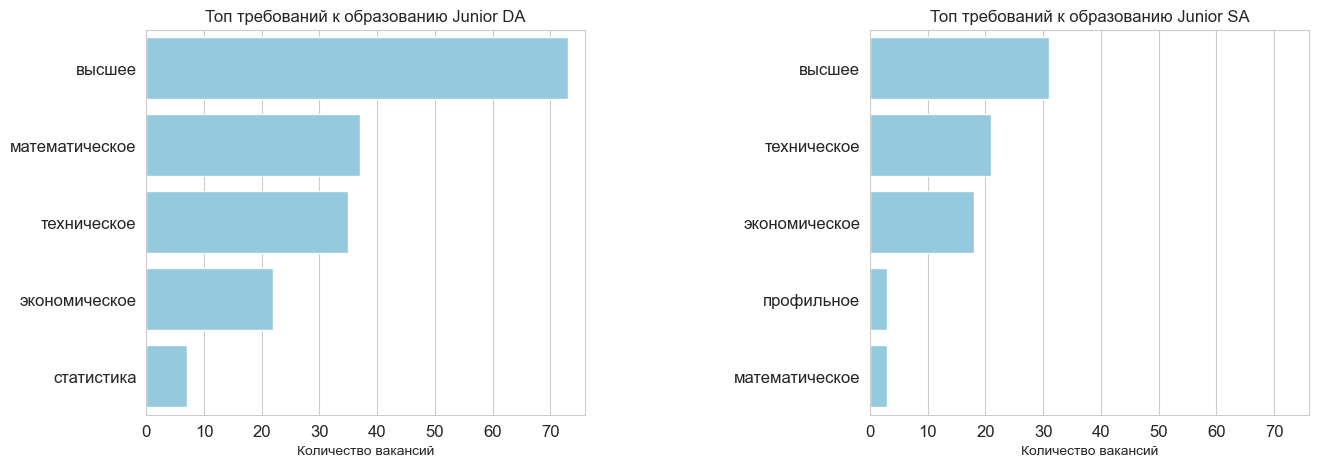

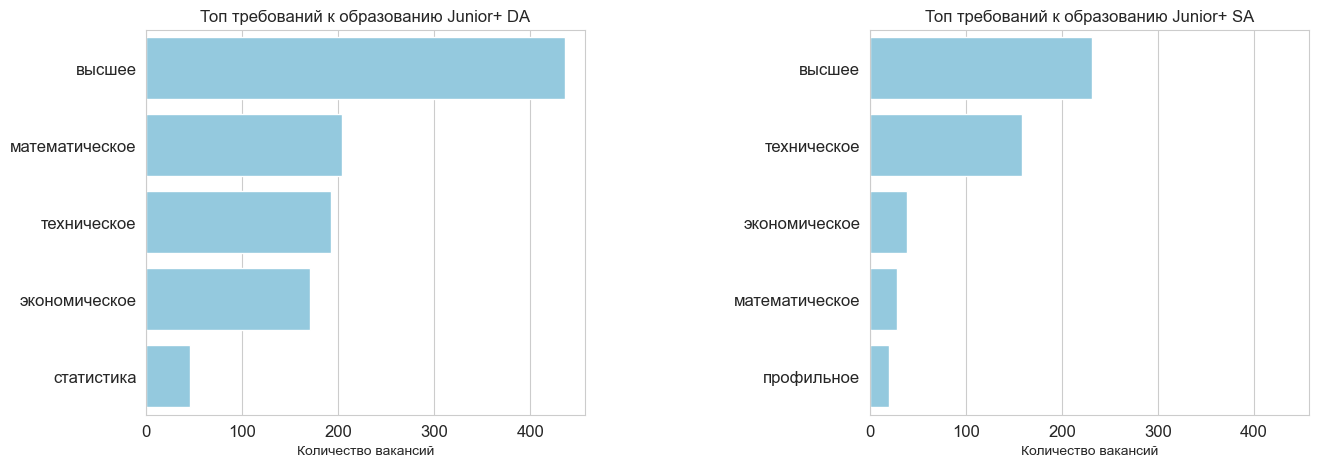

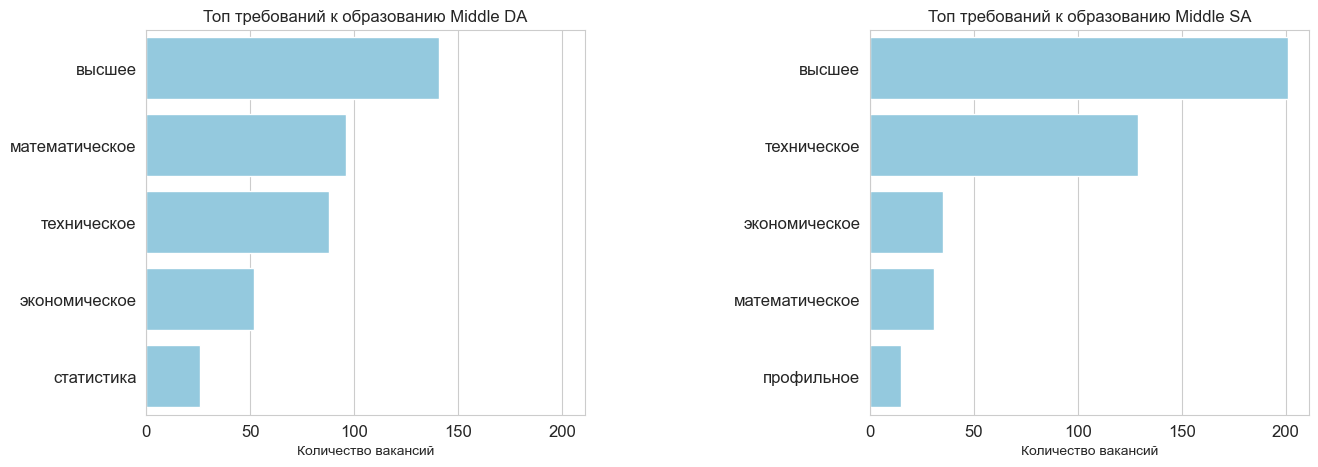

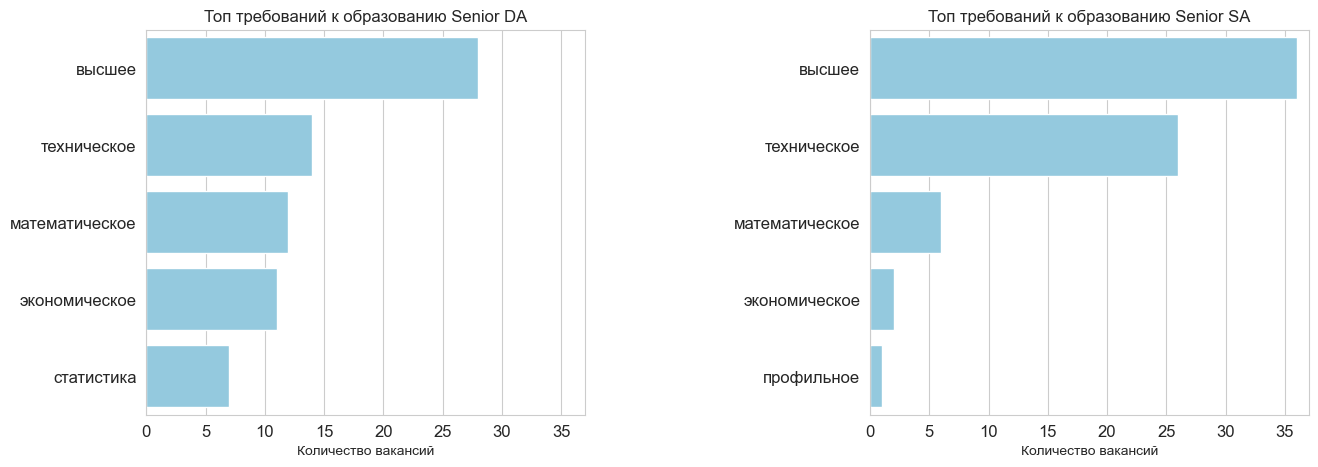

In [127]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(df, 'education_req_lst', (flag_1 & flag_edu), name_1, 'Топ требований к образованию')

Гипотеза потвердилась - требование к фундаментальному образованию не сильно зависит от грейда. 


**Вывод по подразделу:**
* Требований к образованию для SA специалистов встречается реже, чем к DA.
* Самое частое требование для DA/SA - высшее образование.
* Для DA специалистов чуть больше ценится математическое образование, чем техническое. 
* Для SA специалистов заметное больше ценится техническое образование, чем математическое.
* В большинстве вакансий требования к образованию не указано.
* Среднее образование очень редко указывается в вакансия DA/SA специалистов.

#### Анализ названий вакансий (базовый)

Проведем базовый анализ слов в наименовании вакансий. 

In [128]:
# выведем топ 10 самых частых слов в наименовании вакансий DA
words_name_da = df[flag_da].name.str.lower().str.split().explode()
words_name_da = words_name_da.value_counts().reset_index()

words_name_da.head(10) # выводим топ 10

,name,count
0,аналитик,1352
1,данных,1268
2,data,530
3,analyst,490
4,/,206
5,в,142
6,ведущий,55
7,senior,54
8,дата,50
9,и,49


In [129]:
# выведем топ 10 самых частых слов в наименовании вакансий SA
words_name_sa = df[flag_sa].name.str.lower().str.split().explode()
words_name_sa = words_name_sa.value_counts().reset_index()

words_name_sa.head(10) # выводим топ 10

,name,count
0,аналитик,1729
1,системный,1669
2,analyst,160
3,system,143
4,1с,121
5,/,114
6,ведущий,104
7,в,44
8,старший,38
9,по,36


In [131]:
# топ 5 с учетом грейда и специализации
prepared_df = df.loc[:] # копия основного df
prepared_df['name'] = prepared_df.name.str.lower().str.split() # подготавливаем df
    
# выведем DataFrame с разделением по грейду и специальности
for flag_1, name_1 in zip(flags_spec, names_spec):
    for flag_2, name_2 in zip(flags_grade, names_grade):
        print('Топ слов в названии', name_2, name_1)
        display(temp_df_cnt(prepared_df, flag_1, flag_2, 'name'))

Топ слов в названии Junior DA


,name,count,percent
0,данных,122,78.71
1,аналитик,121,78.06
2,data,23,14.84
3,analyst,19,12.26
4,стажер,12,7.74


Топ слов в названии Junior+ DA


,name,count,percent
0,аналитик,831,81.71
1,данных,791,77.78
2,data,233,22.91
3,analyst,213,20.94
4,/,107,10.52


Топ слов в названии Middle DA


,name,count,percent
0,аналитик,339,70.48
1,данных,294,61.12
2,data,191,39.71
3,analyst,178,37.01
4,/,73,15.18


Топ слов в названии Senior DA


,name,count,percent
0,data,83,62.41
1,analyst,80,60.15
2,аналитик,61,45.86
3,данных,61,45.86
4,senior,53,39.85


Топ слов в названии Junior SA


,name,count,percent
0,системный,70,88.61
1,аналитик,55,69.62
2,(стажер),16,20.25
3,analysis,16,20.25
4,1с,14,17.72


Топ слов в названии Junior+ SA


,name,count,percent
0,аналитик,745,94.42
1,системный,718,91.00
2,/,66,8.37
3,1с,62,7.86
4,analyst,53,6.72


Топ слов в названии Middle SA


,name,count,percent
0,аналитик,809,91.00
1,системный,762,85.71
2,analyst,84,9.45
3,system,79,8.89
4,ведущий,58,6.52


Топ слов в названии Senior SA


,name,count,percent
0,аналитик,120,81.63
1,системный,119,80.95
2,старший,37,25.17
3,senior,29,19.73
4,analyst,21,14.29


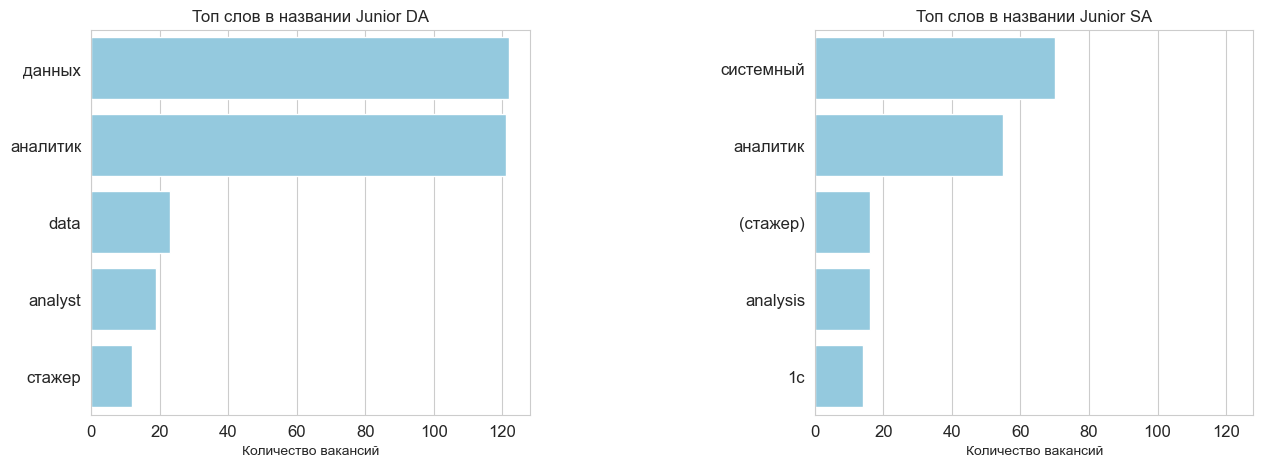

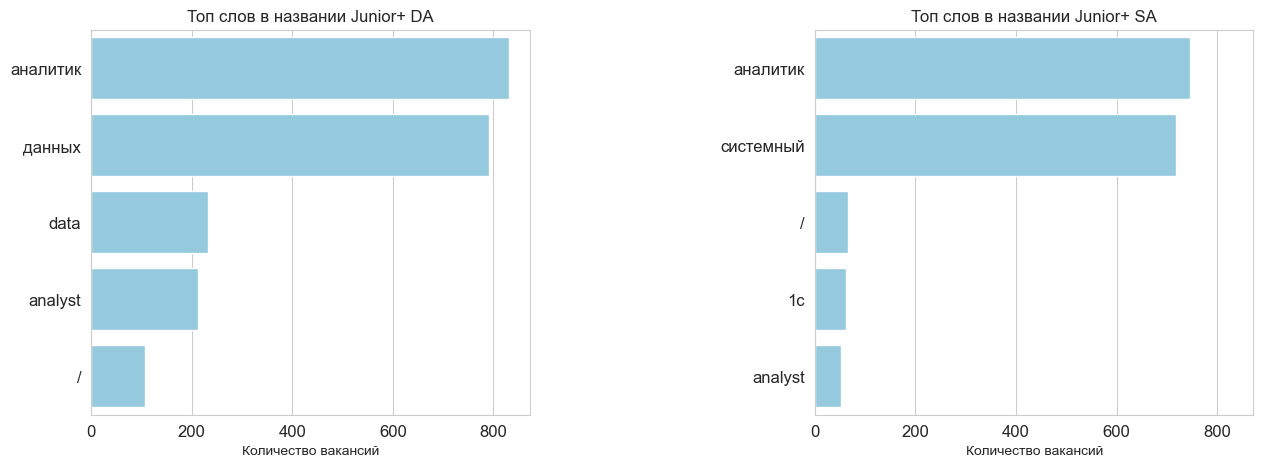

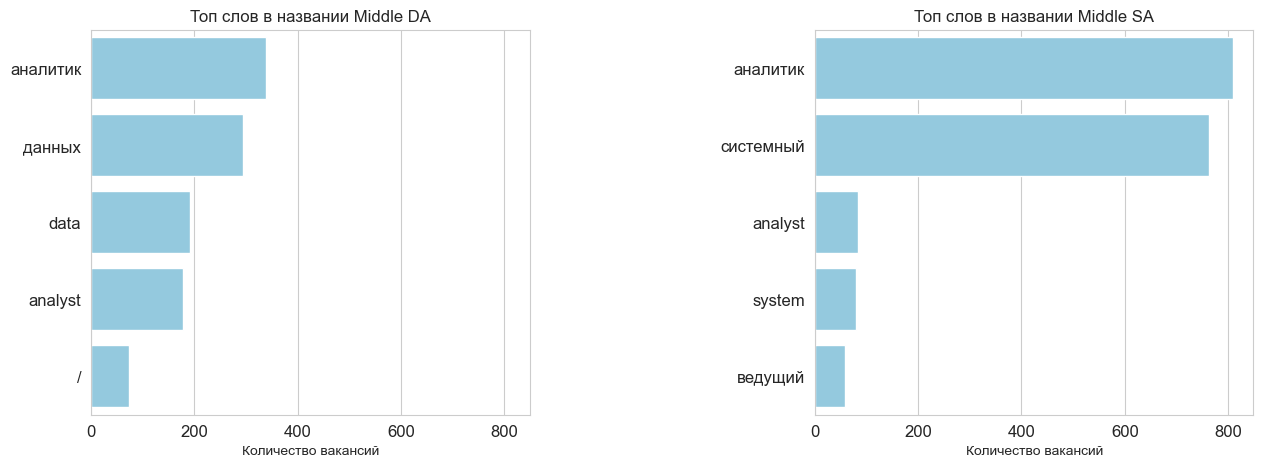

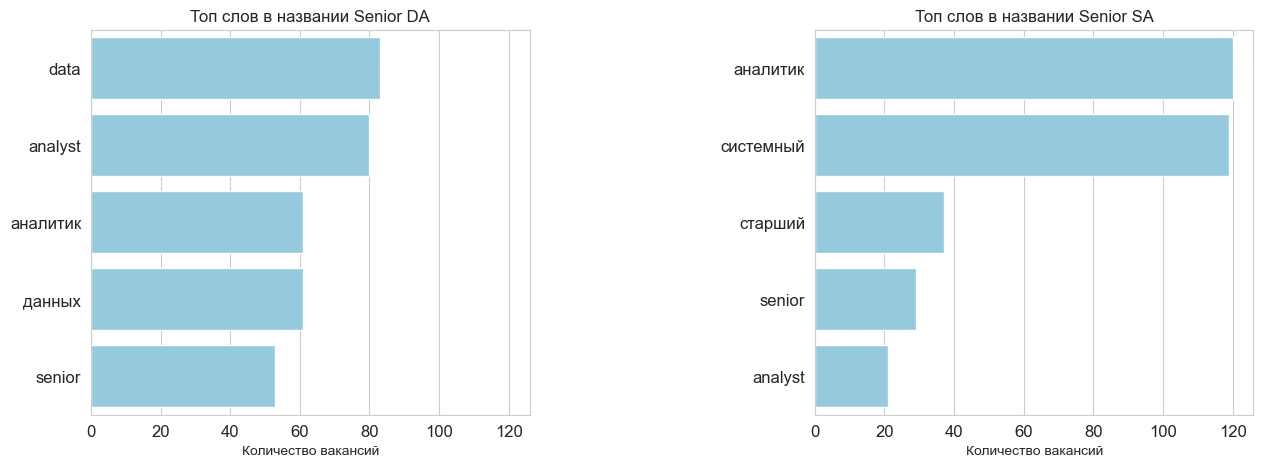

In [132]:
# отобразим распределение выше графически

# для каждого грейда своя линия отображения
for flag_1, name_1 in zip(flags_grade, names_grade):
    draw_bps(prepared_df, 'name', flag_1, name_1, 'Топ слов в названии')

**Вывод по подразделу:**
* Для DA специалистов наблюдается тенденция: с ростом грейда чаще используется английское наименование специальности. На уровне Junior преобладает русскоязычное название "аналитик данных", тогда как для Senior чаще применяется "data analyst". Для SA специалистов такой зависимости нет — во всех грейдах доминирует русскоязычное наименование "системный аналитик".
* Есть востребованность 1с SA как отдельной подкатегорией специалистов.

### Общий вывод

**Предобработка данных:** <br>
- [Объединили два источника в один df](#Объединяем-датафреймы)
- [Преобразованы типы данных из float в Int64](#Изменение-формата-данных)
- [Добавлены новые поля](#Добавляем-новые-поля)
- [Произведена замен пропусков](#Заменяем-пропуски-в-необходимых-столбцах) и [разделены hard/soft навыки при помощи генеративной нейросети](#разделение_навыков).
- Произведена проверка [категориальных](#Проверка-категориальных-значений) и [количественных](#Проверка-количественных-значений) данных
- [Произведена проверка на дубликаты](#Проверка-на-дубликаты)
- [Произведена проверка на соотношении зарплаты и грейда](#Проверка-на-соотношении-зарплат-и-грейда)
<br> <br>
*Подробная информация о выполненной предобработке данных представлена в конце каждого подраздела.*

**Исследовательский анализ данных:**
- Небольшой объем данных по Senior специалистам.
- [Анализ распределения по датам публикации](#Анализ-распределения-по-датам-публикации):
    * Вакансии **DA собирались в течение 118 дней**, а вакансии **SA — в течение 12 дней**.
    * Объем вакансий, собранных за день, различается более чем в 10 раз. **Это делает невозможным анализ общей востребованности на рынке труда.**
    
- [Анализ распределения по грейдам](#Анализ-распределения-по-грейдам):
    * Количество вакансий для SA превышает количество вакансий для DA на 119 единиц, что составляет 3%.
    * Для позиций Junior и Junior+ спрос на специалистов DA значительно выше, чем на SA.
    * Для специалистов уровня Middle спрос на SA заметно выше, чем на DA.
    * Для уровня Senior, с учетом общей разницы в количестве вакансий, спрос на специалистов SA и DA примерно одинаков.
    * Наибольший спрос наблюдается на специалистов уровня Junior+ и Middle.
- [Определение типичного места работы DA/SA специалистов](#Определение-типичного-места-работы-DA/SA-специалистов):
    * В расспределении вакансий DA/SA прослеживаются явные лидеры по всем категориям.
________________________
    Типичное место работы для DA специалиста: 
    Сфера: Банковская сфера или маркетплейс
    Город: Москва
    Зарплата: 
        Junior ≈ 63 т.руб
        Junior+ ≈ 114 т.руб
        Middle ≈ 212 т.руб
        Senior ≈ 276 т.руб
    Тип занятости: Полная занятость
    График работы: Полный день (редко удаленная работа)
___________
    Типичное место работы для SA специалиста:
     Сфера: Банковская сфера или консалтинг/аутсорс 
     Город: Москва
     Зарплата: 
        Junior ≈ 64 т.руб
        Junior+ ≈ 142 т.руб
        Middle ≈ 245 т.руб
        Senior ≈ 324 т.руб
     Тип занятости: Полная занятость
     График работы: Полный день (иногда удаленная работа)

- [Анализ требований к навыкам](#Анализ-требований-к-навыкам):
    * В среднем требований по всем навыком больше к SA специалистам.
    * Только количество soft навыков middle/senior DA чуть опережают аналогичные уровни SA.
    * Существенная разница в требованиях к DA/SA специалистам наблюдается только на уровне Junior.
- [Анализ самых важных навыков](#Анализ-самых-важных-навыков):
    * Soft навыки универсальны для всех грейдов. На высоких уровнях часто добавляются навыки руководителя.
    * Ключевое значение имеет не наличие навыка, а степень его освоения. <br> 
    *Аристотель: "Мы — это то, что мы делаем постоянно. Совершенство, следовательно, не действие, а привычка."*
 _____
    Основные навыки для DA специалиста:
     Вне зависимости от уровня:
         Hard навыки:
             SQL
             Python
             Pandas
             BI системы (самая популярная Power BI)
         Soft навыки:
             Аналитическое мышление
             Коммуникация
             Подготовка презентаций
             Английский язык
             Ответственность
     Для Junior/Junior+ уровня добавить:
         Excel
     Для Middle/Senior уровня добавить:
         a/b тесты
______
        Основные навыки для SA специалиста:
         Вне зависимости от уровня:
             Hard навыки:
                 SQL
                 BPMN
                 Confluence
                 UML
                 Системный анализ
             Soft навыки:
                 Аналитическое мышление
                 Коммуникация
                 Agile/scrum методология
                 Английский язык
                 Ответственность
         Для Junior уровня добавить:
             Бизнес анализ
         Для Senior уровня добавить:
             Rest
- [Анализ требований к образованию](#Анализ-требований-к-образованию):
    * Требований к образованию для SA специалистов встречается реже, чем к DA.
    * Самое частое требование для DA/SA - высшее образование.
    * Для DA специалистов чуть больше ценится математическое образование, чем техническое. 
    * Для SA специалистов заметное больше ценится техническое образование, чем математическое.
- [Анализ названий вакансий (базовый)](#Анализ-названий-вакансий-(базовый)):
    * Для DA специалистов наблюдается тенденция: с ростом грейда чаще используется английское наименование специальности. На уровне Junior преобладает русскоязычное название "аналитик данных", тогда как для Senior чаще применяется "data analyst". Для SA специалистов такой зависимости нет — во всех грейдах доминирует русскоязычное наименование "системный аналитик".
    * Есть востребованность 1с SA как отдельной подкатегорией специалистов.

### Рекомендации

Для повышения точности исследования:
* Увеличить объем выборки, что позволит добавить дополнительные грейды или аналитические срезы.


Для анализа общей востребованности:
* Собрать данные за единый временной период и утвердить алгоритм распределения вакансий между DA и SA специалистами.
* Собрать данные по дате закрытия вакансии, по количеству просмотров, по количеству откликов.

**Рекомендации для работодателей:**
* Придерживаться стандартизированных формулировок в названиях вакансий.
* Четко указывать требуемые навыки и уровень их владения.
* Внимательно соотносить требования к опыту работы с указанием грейда.
* Если отсутствуют необходимые компетенции, стоит обратиться за помощью к специалистам.

**Рекомендации для соискателей:**
* Расширять поиск вакансий, учитывая различные варианты наименований должностей.
* Заранее оценить готовность к переезду и участие в обучающих программах.
* Сравнивать зарплатные ожидания с актуальными предложениями на рынке труда.
* Использовать закрытые каналы для поиска работы, такие как прямое взаимодействие с работодателями, профильные мероприятия и специализированные ресурсы.
